# Montecarlo aproximated function



In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import sys
sys.path.append('../')  # Enable importing from `src` folder

In [3]:
%matplotlib inline
from collections import defaultdict
from typing import List

import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import gym

import src.agents as agents
import src.episode as episode
import src.environment as environment
import src.aux_plots as aux_plots

In [4]:
def print_result(i, scores, total_reward, score):
    if i % 10 == 0:
        print(f"Run [{i:4}] - Total reward: {total_reward:7.2f} Mean scores: {sum(scores) / len(scores):.2f} Means Scores[:-10]: {sum(scores[-10:]) / len(scores[-10:]):5.2f} Score: {score:2} ")

In [5]:
RAM_mask = [
      14  # Chicken Y
    , 16  # Chicken Lane Collide
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117  # Car X Coords
]

In [6]:
def reduce_state(ob):
    # Doesn't matter where we were hit
    ob[16] = 1 if ob[16] != 255 else 0

    # Reduce chicken y-position
    ob[14] = ob[14] // 3

    for b in range(108, 118):
        # The chicken is in the x-posistion ~49
        if ob[b] < 20 or ob[b] > 80:
            # We don't need to represent cars far from the chicken
            ob[b] = 0
        else:
            # Reduce the cars x-positions sample space
            ob[b] = ob[b] // 3

    return ob

# Reward Policy

In [7]:
def reward_policy(reward, ob, action):
    if reward == 1:
        reward = reward_policy.REWARD_IF_CROSS
    elif ob[16] == 1:  # Collision!
        reward = reward_policy.REWARD_IF_COLISION
    elif action != 1:  # Don't incentivate staying still
        reward = reward_policy.REWARD_IF_STILL

    return reward

# Hyper Parameters

In [8]:
GAMMA = 0.99
AVAILABLE_ACTIONS = 2
N0 = 2.5

reward_policy.REWARD_IF_CROSS = 50
reward_policy.REWARD_IF_COLISION = -1
reward_policy.REWARD_IF_STILL = -0.1

# MonteCarlo

In [9]:
env, initial_state = environment.get_env()

In [10]:
agent = agents.MonteCarloControl(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

In [11]:
def MonteCarloES(RAM_mask: List[int], render: bool=False):
    epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
    return agent.update_policy(epi)

In [12]:
episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=False)

In [275]:
import pickle

In [273]:
def saveHistory(config,scores,total_rewards):
    base="history/"
    with open(base+"scores_"+config+".pickle", 'wb') as handle:
        pickle.dump(scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open(base+"total_rewards_"+config+".pickle", 'wb') as handle:
        pickle.dump(total_rewards, handle, protocol=pickle.HIGHEST_PROTOCOL)    
    print("Scores and Total rewards for "+config+" saved")
def loadHistory(fileDir):
    with open(fileDir, 'rb') as handle:
        data = pickle.load(handle)
        return data

In [ ]:
%%time
MonteCarloES(RAM_mask=RAM_mask, render=False)

In [ ]:
scores = []
total_rewards = []

In [15]:
%%time

n_runs = 2500

for i in range(n_runs):
    render = i % 201 == 200

    score, total_reward = MonteCarloES(RAM_mask=RAM_mask, render=render)

    scores.append(score)
    total_rewards.append(total_reward)

    print_result(i, scores, total_reward, score)

Run [   0] - Total reward:  464.60 Mean scores: 13.00 Means Scores[:-10]: 13.00 Score: 13 
Run [  10] - Total reward:  443.10 Mean scores: 11.91 Means Scores[:-10]: 11.80 Score: 13 
Run [  20] - Total reward:  450.00 Mean scores: 11.95 Means Scores[:-10]: 12.00 Score: 13 
Run [  30] - Total reward:  459.10 Mean scores: 12.06 Means Scores[:-10]: 12.30 Score: 13 
Run [  40] - Total reward:  464.70 Mean scores: 11.95 Means Scores[:-10]: 11.60 Score: 13 
Run [  50] - Total reward:  457.90 Mean scores: 12.00 Means Scores[:-10]: 12.20 Score: 13 
Run [  60] - Total reward:  400.60 Mean scores: 12.00 Means Scores[:-10]: 12.00 Score: 12 
Run [  70] - Total reward:  559.50 Mean scores: 12.06 Means Scores[:-10]: 12.40 Score: 15 
Run [  80] - Total reward:  285.40 Mean scores: 12.00 Means Scores[:-10]: 11.60 Score: 10 
Run [  90] - Total reward:  294.50 Mean scores: 12.01 Means Scores[:-10]: 12.10 Score: 10 
Run [ 100] - Total reward:  407.00 Mean scores: 12.08 Means Scores[:-10]: 12.70 Score: 12 

In [1]:
aux_plots.plot_scores(scores)

NameError: name 'aux_plots' is not defined

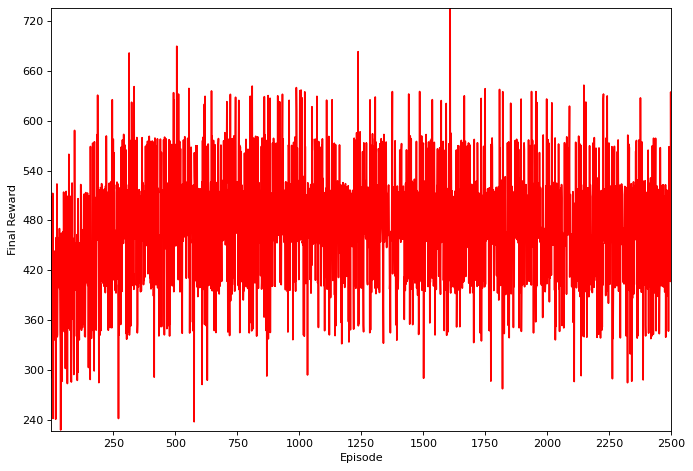

In [22]:
aux_plots.plot_rewards(total_rewards)

In [28]:
saveHistory("Episode2500",scores,total_rewards)

Scores and Total rewards for Episode2500 saved


# MonteCarlo Approximation

In [188]:
def MonteCarloAprox(RAM_mask: List[int], render: bool=False):
    epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
    
    return agent.updating(epi)

In [177]:
env, initial_state = environment.get_env()

In [178]:
agent = agents.MonteCarloAprox(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0,nFeatures=len(RAM_mask)+1)

In [87]:
agent

In [179]:
scores = []
total_rewards = []

In [180]:
def MonteCarloAprox(RAM_mask: List[int], render: bool=False):
    epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
    
    return agent.updating(epi)

In [181]:
from tqdm import tqdm

In [70]:
MonteCarloAprox(RAM_mask=RAM_mask)

State: [2 0 0 0 0 0 0 0 0 0 0 0]
State: [2 0 0 0 0 0 0 0 0 0 0 0]
State: [3 0 0 0 0 0 0 0 0 0 0 0]
State: [4 0 0 0 0 0 0 0 0 0 0 0]
State: [5 0 0 0 0 0 0 0 0 0 0 0]
State: [6 0 0 0 0 0 0 0 0 0 0 0]
State: [7 0 0 0 0 0 0 0 0 0 0 0]
State: [7 0 0 0 0 0 0 0 0 0 0 0]
State: [8 0 0 0 0 0 7 0 0 0 0 0]
State: [9 0 0 0 0 0 8 0 0 0 0 0]
State: [ 9  0  0  0  0  0 10  0  0  0  0  0]
State: [ 9  0  0  0  0  0 10  0  0  0  0  0]
State: [10  0  0  0  0  0 11  0  0  0  0  0]
State: [10  0  0  0  0  0 12  0  0  0  0  0]
State: [11  0  0  0  0  6 13  0  0  0  0  0]
State: [12  0  0  0  0  7 13  0  0  0  0  0]
State: [13  0  0  0  0  7 15  0  0  0  0  0]
State: [13  0  0  0  0  8 16  0  0  0  0  0]
State: [14  0  0  0  0  8 17  0  0  0  0  0]
State: [15  0  0  0  0  9 18  0  0  0  0  0]
State: [16  0  0  0  0  9 19  0  0  0  0  0]
State: [17  0  0  0  7 10 20  0  0  0  0  0]
State: [18  0  0  0  7 10 21  0  0  0  0  0]
State: [18  0  0  0  7 11 22  0  0  0  0  0]
State: [18  0  0  0  7 11 23  0  0  0  0

State: [47  0 18 10  0 19  0 13  0 22  0  0]
State: [48  0 19 10  0 20  0 12  0 22  0  0]
State: [50  0 19 10  0 21  0 11  0 21  0  0]
State: [51  0 19 10  0 21  0 10  0 21  0  0]
State: [52  0 19 11  0 22  0  9  0 20  0  0]
State: [52  0 19 11  0 22  0  8  0 20  0  0]
State: [53  0 20 11  0 23  0  7  0 20  0  0]
State: [53  0 20 12  0 23  0  0  0 19  0  0]
State: [53  0 20 12  0 24  0  0  0 19  0  0]
State: [53  0 20 12  0 24  0  0  0 19  0  0]
State: [54  0 20 12  0 25  0  0  0 18  0  0]
State: [54  0 21 13  0 25  0  0  0 18  0  0]
State: [54  0 21 13  0 26  0  0  0 18  0  0]
State: [55  0 21 13  0 26  0  0 26 17  0  0]
State: [55  0 21 13  0  0  0  0 26 17  0  0]
State: [55  0 21 14  0  0  0  0 25 17  0  0]
State: [55  0 22 14  0  0  0  0 25 16  0  0]
State: [57  0 22 14  0  0  0  0 24 16  0  0]
State: [57  0 22 14  0  0  0  0 24 16  0  0]
State: [58  0 22 14  0  0  0  0 23 15  0  0]
State: [58  0 22 15  0  0  0  0 23 15  0  0]
State: [59  0 23 15  0  0  7  0 22 15  0  0]
State: [ 2

State: [43  0 13  0 21  0 10  0 21  0 10  0]
State: [44  0 13  0 21  0 11  0 20  0 10  0]
State: [44  0 13  0 22  0 12  0 20  0 10  0]
State: [45  0 13  0 22  0 13  0 19  0  9  0]
State: [46  0 13  0 22  0 14  0 19  0  9  0]
State: [46  0 14  0 23  0 15  0 18  0  9  0]
State: [47  0 14  0 23  0 16  0 18  0  9  0]
State: [47  0 14  0 23  0 17  0 17  0  8  0]
State: [47  0 14  0 24  0 18  0 17  0  8  0]
State: [47  0 14  0 24  0 18  0 17  0  8  0]
State: [49  0 14  0 24  0 20  0 16  0  8  0]
State: [50  0 15  0 25  0 21  0 15  0  7  0]
State: [50  0 15  0 25  0 22  0 15  0  7  0]
State: [51  0 15  0 25  0 23  0 15  0  7  0]
State: [52  0 15  0 26  0 24  0 14  0  7  0]
State: [52  0 15  0 26  0 25  0 14  0  7  0]
State: [53  0 16  0 26  0 26  0 13 26  6  0]
State: [54  0 16  0  0  0  0 25 12 26  0  0]
State: [55  0 16  0  0  0  0 24 12 26  0  0]
State: [56  0 16  0  0  0  0 23 11 25  0  0]
State: [56  0 17  0  0  0  0 22 11 25  0  0]
State: [56  0 17  0  0  0  0 21 10 25  0  0]
State: [56

State: [37  0 12  0 20  0  0  0  0  0 25  0]
State: [37  0 12  0 20  0  7  0  0  0 24  0]
State: [37  0 12  0 20  0  8  0  0  0 24  0]
State: [37  0 12  0 21  0  9  0  0  0 24  0]
State: [37  0 12  0 21  0 10  0  0  0 24  0]
State: [37  0 13  0 21  0 10  0  0  0 23  0]
State: [38  0 13  0 21  0 11  0  0  0 23  0]
State: [39  0 13  0 22  0 12  0  0  0 23  0]
State: [40  0 13  0 22  7 13  0  0  0 23  0]
State: [41  0 13  0 22  7 14  0  0  0 23  0]
State: [41  0 14  0 23  8 15  0  0  0 22  0]
State: [41  0 14  0 23  8 16  0  0  0 22  0]
State: [41  0 14  0 23  8 17  0  0  0 22  0]
State: [41  0 14  0 24  9 18  0  0  0 22  0]
State: [42  0 14  0 24  9 18  0  0  0 21  0]
State: [42  0 14  0 24  9 19  0  0  0 21  0]
State: [42  0 15  0 24 10 20  0  0  0 21  0]
State: [42  0 15  0 25 10 21  0  0  0 21  0]
State: [42  0 15  0 25 11 22  0  0  0 21  0]
State: [42  0 15  0 25 12 23  0  0  0 20  0]
State: [42  0 15  0 26 12 24  0  0  0 20  0]
State: [42  0 16  0 26 13 25  0  0 26 20  0]
State: [43

In [40]:
%%time

n_runs = 1

for i in tqdm(range(n_runs)):
    render = i % 201 == 200
    score, total_reward = MonteCarloAprox(RAM_mask=RAM_mask, render=render)
    scores.append(score)
    total_rewards.append(total_reward)
    print_result(i, scores, total_reward, score)

  0%|          | 0/1 [00:00<?, ?it/s]

2722
Update in 125 : [ 44.33421053   0.         148.65         0.           0.
  68.60769231 142.93269231   0.           0.          51.45576923
 114.34615385 148.65       148.65      ]
Update in 126 : [ -95.77461255    0.         -295.02793973    0.            0.
 -153.23127756 -300.74524742 -443.67793973    0.          -85.06051992
 -226.94456902 -295.02793973 -295.02793973]
Update in 127 : [ 350.07970908 1337.56296489 -295.02793973    0.            0.
  515.55020489 -300.74524742  893.88502516    0.          326.49731543
  750.50528993 1042.53502516 -295.02793973]
Update in 128 : [ -483.82624453  1337.56296489  -295.02793973     0.
     0.          -906.36635705  -300.74524742 -1645.25169258
     0.          -486.02643424 -1179.23861555 -1598.16716129
  -295.02793973]
Update in 129 : [1112.98952373 1337.56296489 -295.02793973    0.            0.
 1976.57251868 -300.74524742 3296.92923724    0.         1161.36720903
 2733.32128723 3755.86217935 5059.00140091]
Update in 130 : [ -3111.

Update in 468 : [ 3.81344554e+07  1.33756296e+03 -6.52248647e+04  1.84965496e+07
 -8.00019617e+04  3.60723593e+07  3.04613414e+06 -1.03288822e+07
 -7.73227408e+04  1.09582881e+06  1.02704122e+04  1.55526163e+07
  5.41531514e+07]
Update in 469 : [-3.06535347e+07  1.33756296e+03 -6.52248647e+04 -1.38186875e+07
 -8.00019617e+04 -2.85581149e+07  3.04613414e+06 -1.03288822e+07
 -7.73227408e+04  1.09582881e+06  1.02704122e+04 -1.40696844e+07
 -1.58631957e+07]
Update in 470 : [-3.06535347e+07  1.33756296e+03 -6.52248647e+04  4.03914616e+06
 -8.00019617e+04  7.15755246e+06  3.04613414e+06 -1.03288822e+07
 -7.73227408e+04  1.09582881e+06  1.02704122e+04  2.29999653e+06
 -1.58631957e+07]
Update in 471 : [-3.06535347e+07  1.33756296e+03 -6.52248647e+04  1.79622223e+06
 -8.00019617e+04  2.48479427e+06  3.04613414e+06 -1.03288822e+07
 -7.73227408e+04  1.09582881e+06  1.02704122e+04  2.43982927e+05
 -1.58631957e+07]
Update in 472 : [-3.06535347e+07  1.33756296e+03 -6.52248647e+04  1.01053171e+05
 -8

  3.75844971e+16]
Update in 995 : [ 1.32862441e+16  1.44665633e+17 -1.02330674e+16 -5.89196964e+16
 -5.43612016e+16 -3.59569238e+16  5.18493759e+16 -2.35174737e+16
 -8.18455861e+15  1.16844406e+16  1.99321872e+16 -3.20077687e+16
 -4.78905175e+15]
Update in 996 : [ 1.72115169e+16  1.44665633e+17 -1.02330674e+16 -5.89196964e+16
 -4.05925522e+16 -1.53039497e+16  5.18493759e+16 -2.35174737e+16
 -8.18455861e+15  1.16844406e+16  3.19797554e+16 -2.25418222e+16
 -4.78905175e+15]
Update in 997 : [ 1.88725840e+16  1.44665633e+17 -1.02330674e+16 -5.89196964e+16
 -3.47660400e+16 -6.56418138e+15  5.18493759e+16 -2.35174737e+16
 -8.18455861e+15  1.16844406e+16  3.70779536e+16 -1.85360951e+16
 -4.78905175e+15]
Update in 998 : [ 1.94623715e+16  1.44665633e+17 -1.02330674e+16 -5.89196964e+16
 -3.26972468e+16 -3.46099158e+15  5.18493759e+16 -2.35174737e+16
 -8.18455861e+15  1.16844406e+16  3.88881477e+16 -1.71137998e+16
 -1.42726280e+15]
Update in 999 : [ 2.05738610e+16  1.44665633e+17 -1.02330674e+16 -

Update in 1518 : [ 6.70089500e+20  1.81276770e+21  3.03774722e+19  5.93802496e+20
  2.22251535e+20  1.41293498e+21  2.47173677e+20  1.93051833e+21
  2.86693648e+19  2.16716240e+21 -3.27667930e+17  1.28922518e+21
  2.97187097e+21]
Update in 1519 : [-2.05910546e+21  1.81276770e+21  3.03774722e+19 -2.06541311e+21
  2.22251535e+20 -3.57309427e+21  2.47173677e+20 -5.38232458e+21
  2.86693648e+19 -6.14288636e+21 -3.27667930e+17 -3.69680407e+21
 -5.67057974e+21]
Update in 1520 : [ 3.80309983e+21  1.81276770e+21  3.03774722e+19  4.36046577e+21
  2.22251535e+20  9.27866348e+21  2.47173677e+20  1.06823726e+22
  2.86693648e+19  1.31347503e+22 -3.27667930e+17  7.54848396e+21
  1.52135266e+22]
Update in 1521 : [-7.61858512e+20  1.81276770e+21  3.03774722e+19 -6.43430874e+20
  2.22251535e+20 -7.29129806e+20  2.47173677e+20 -1.82736900e+21
  2.86693648e+19 -1.87693966e+21 -3.27667930e+17 -1.20833516e+21
  1.52135266e+22]
Update in 1522 : [-3.55652518e+21  1.81276770e+21  3.03774722e+19 -3.91104114e+2

100%|██████████| 1/1 [00:03<00:00,  3.50s/it]

 [ 3.03601744e+43  3.00870112e+27 -8.26077006e+43 -2.67998981e+38
 -2.54177540e+43 -4.48514894e+42 -5.10930969e+43  4.04153028e+42
  1.07582866e+43 -2.12966197e+42 -4.31875549e+43 -6.52866065e+43
  4.29879773e+43]
Update in 2264 : [ 6.05853968e+43  3.00870112e+27  1.08818708e+44 -2.67998981e+38
  4.08452336e+43  9.12280553e+43  1.40333312e+44  1.95467939e+44
  1.07582866e+43 -2.12966197e+42  1.04063529e+44  1.26139802e+44
  2.34414386e+44]
Update in 2265 : [-7.44066044e+43  3.00870112e+27  1.08818708e+44 -2.67998981e+38
 -2.01290769e+44 -2.85427948e+44  1.40333312e+44 -4.77132067e+44
  1.07582866e+43 -2.12966197e+42 -4.07112476e+44 -5.73364204e+44
 -4.65089620e+44]
Update in 2266 : [ 3.49892930e+44  3.00870112e+27  1.08818708e+44 -2.67998981e+38
  4.96355582e+44  7.99799708e+44  1.40333312e+44  1.38325820e+45
  1.07582866e+43 -2.12966197e+42  1.06569649e+45  1.44205859e+45
  1.55033317e+45]
Update in 2267 : [-6.02668914e+44  3.00870112e+27  1.08818708e+44 -2.67998981e+38
 -1.11003569e+

# 3. MC approx All Features MinMax Scalar

In [263]:
def MonteCarloAprox(RAM_mask: List[int], render: bool=False,typeFeature: int=1):
    epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
    
    return agent.updating(epi,typeFeature)

In [264]:
env, initial_state = environment.get_env()

In [265]:
agent = agents.MonteCarloAprox(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0,nFeatures=len(RAM_mask)+1)

In [266]:
scores = []
total_rewards = []

In [267]:
%%time

n_runs = 2000

for i in tqdm(range(n_runs)):
    render = i % 201 == 200
    score, total_reward = MonteCarloAprox(RAM_mask=RAM_mask, render=render)
    scores.append(score)
    total_rewards.append(total_reward)
    print_result(i, scores, total_reward, score)

  0%|          | 1/2000 [00:03<1:50:35,  3.32s/it]

Run [   0] - Total reward:  346.10 Mean scores: 11.00 Means Scores[:-10]: 11.00 Score: 11 


  1%|          | 11/2000 [00:39<1:57:14,  3.54s/it]

Run [  10] - Total reward:  357.00 Mean scores: 11.45 Means Scores[:-10]: 11.50 Score: 11 


  1%|          | 21/2000 [01:14<1:54:34,  3.47s/it]

Run [  20] - Total reward:  528.00 Mean scores: 12.00 Means Scores[:-10]: 12.60 Score: 14 


  2%|▏         | 31/2000 [01:47<1:49:54,  3.35s/it]

Run [  30] - Total reward:  573.20 Mean scores: 12.26 Means Scores[:-10]: 12.80 Score: 15 


  2%|▏         | 41/2000 [02:20<1:49:55,  3.37s/it]

Run [  40] - Total reward:  412.10 Mean scores: 12.49 Means Scores[:-10]: 13.20 Score: 12 


  3%|▎         | 51/2000 [02:52<1:52:37,  3.47s/it]

Run [  50] - Total reward:  571.20 Mean scores: 12.63 Means Scores[:-10]: 13.20 Score: 15 


  3%|▎         | 61/2000 [03:24<1:39:39,  3.08s/it]

Run [  60] - Total reward:  412.50 Mean scores: 12.54 Means Scores[:-10]: 12.10 Score: 12 


  4%|▎         | 71/2000 [03:56<1:47:09,  3.33s/it]

Run [  70] - Total reward:  518.20 Mean scores: 12.68 Means Scores[:-10]: 13.50 Score: 14 


  4%|▍         | 81/2000 [04:27<1:33:46,  2.93s/it]

Run [  80] - Total reward:  515.50 Mean scores: 12.80 Means Scores[:-10]: 13.70 Score: 14 


  5%|▍         | 91/2000 [04:57<1:35:53,  3.01s/it]

Run [  90] - Total reward:  529.10 Mean scores: 12.95 Means Scores[:-10]: 14.10 Score: 14 


  5%|▌         | 101/2000 [05:29<1:39:33,  3.15s/it]

Run [ 100] - Total reward:  475.90 Mean scores: 13.00 Means Scores[:-10]: 13.50 Score: 13 


  6%|▌         | 111/2000 [06:00<1:38:45,  3.14s/it]

Run [ 110] - Total reward:  592.60 Mean scores: 13.10 Means Scores[:-10]: 14.10 Score: 15 


  6%|▌         | 121/2000 [06:30<1:35:09,  3.04s/it]

Run [ 120] - Total reward:  526.10 Mean scores: 13.17 Means Scores[:-10]: 14.00 Score: 14 


  7%|▋         | 131/2000 [07:01<1:35:41,  3.07s/it]

Run [ 130] - Total reward:  581.30 Mean scores: 13.24 Means Scores[:-10]: 14.00 Score: 15 


  7%|▋         | 141/2000 [07:31<1:33:47,  3.03s/it]

Run [ 140] - Total reward:  532.30 Mean scores: 13.35 Means Scores[:-10]: 14.90 Score: 14 


  8%|▊         | 151/2000 [08:02<1:33:13,  3.03s/it]

Run [ 150] - Total reward:  418.90 Mean scores: 13.40 Means Scores[:-10]: 14.10 Score: 12 


  8%|▊         | 161/2000 [08:32<1:30:49,  2.96s/it]

Run [ 160] - Total reward:  644.00 Mean scores: 13.43 Means Scores[:-10]: 13.90 Score: 16 


  9%|▊         | 171/2000 [09:01<1:29:39,  2.94s/it]

Run [ 170] - Total reward:  590.40 Mean scores: 13.44 Means Scores[:-10]: 13.60 Score: 15 


  9%|▉         | 181/2000 [09:31<1:29:35,  2.96s/it]

Run [ 180] - Total reward:  481.50 Mean scores: 13.44 Means Scores[:-10]: 13.40 Score: 13 


 10%|▉         | 191/2000 [10:03<1:35:19,  3.16s/it]

Run [ 190] - Total reward:  567.90 Mean scores: 13.47 Means Scores[:-10]: 13.90 Score: 15 


 10%|█         | 201/2000 [10:50<4:13:52,  8.47s/it]

Run [ 200] - Total reward:  579.10 Mean scores: 13.52 Means Scores[:-10]: 14.60 Score: 15 


 11%|█         | 211/2000 [11:20<1:33:53,  3.15s/it]

Run [ 210] - Total reward:  586.80 Mean scores: 13.56 Means Scores[:-10]: 14.40 Score: 15 


 11%|█         | 221/2000 [11:50<1:29:03,  3.00s/it]

Run [ 220] - Total reward:  480.30 Mean scores: 13.59 Means Scores[:-10]: 14.10 Score: 13 


 12%|█▏        | 231/2000 [12:18<1:22:55,  2.81s/it]

Run [ 230] - Total reward:  639.40 Mean scores: 13.64 Means Scores[:-10]: 14.80 Score: 16 


 12%|█▏        | 241/2000 [12:46<1:23:55,  2.86s/it]

Run [ 240] - Total reward:  535.10 Mean scores: 13.67 Means Scores[:-10]: 14.30 Score: 14 


 13%|█▎        | 251/2000 [13:14<1:24:46,  2.91s/it]

Run [ 250] - Total reward:  589.60 Mean scores: 13.70 Means Scores[:-10]: 14.40 Score: 15 


 13%|█▎        | 261/2000 [13:44<1:26:01,  2.97s/it]

Run [ 260] - Total reward:  458.20 Mean scores: 13.72 Means Scores[:-10]: 14.20 Score: 13 


 14%|█▎        | 271/2000 [14:14<1:23:06,  2.88s/it]

Run [ 270] - Total reward:  629.80 Mean scores: 13.73 Means Scores[:-10]: 14.10 Score: 16 


 14%|█▍        | 281/2000 [14:42<1:17:02,  2.69s/it]

Run [ 280] - Total reward:  700.30 Mean scores: 13.79 Means Scores[:-10]: 15.40 Score: 17 


 15%|█▍        | 291/2000 [15:08<1:14:40,  2.62s/it]

Run [ 290] - Total reward:  473.80 Mean scores: 13.82 Means Scores[:-10]: 14.60 Score: 13 


 15%|█▌        | 301/2000 [15:34<1:13:21,  2.59s/it]

Run [ 300] - Total reward:  592.70 Mean scores: 13.85 Means Scores[:-10]: 14.90 Score: 15 


 16%|█▌        | 311/2000 [16:00<1:13:08,  2.60s/it]

Run [ 310] - Total reward:  699.70 Mean scores: 13.88 Means Scores[:-10]: 14.80 Score: 17 


 16%|█▌        | 321/2000 [16:26<1:12:56,  2.61s/it]

Run [ 320] - Total reward:  534.60 Mean scores: 13.92 Means Scores[:-10]: 14.90 Score: 14 


 17%|█▋        | 331/2000 [16:52<1:12:11,  2.60s/it]

Run [ 330] - Total reward:  426.50 Mean scores: 13.94 Means Scores[:-10]: 14.70 Score: 12 


 17%|█▋        | 341/2000 [17:18<1:12:20,  2.62s/it]

Run [ 340] - Total reward:  689.10 Mean scores: 13.95 Means Scores[:-10]: 14.40 Score: 17 


 18%|█▊        | 351/2000 [17:45<1:14:20,  2.71s/it]

Run [ 350] - Total reward:  647.90 Mean scores: 14.00 Means Scores[:-10]: 15.50 Score: 16 


 18%|█▊        | 361/2000 [18:11<1:11:44,  2.63s/it]

Run [ 360] - Total reward:  532.00 Mean scores: 14.00 Means Scores[:-10]: 14.20 Score: 14 


 19%|█▊        | 371/2000 [18:37<1:10:09,  2.58s/it]

Run [ 370] - Total reward:  652.50 Mean scores: 14.02 Means Scores[:-10]: 14.50 Score: 16 


 19%|█▉        | 381/2000 [19:03<1:09:54,  2.59s/it]

Run [ 380] - Total reward:  592.20 Mean scores: 14.06 Means Scores[:-10]: 15.60 Score: 15 


 20%|█▉        | 391/2000 [19:29<1:09:36,  2.60s/it]

Run [ 390] - Total reward:  478.40 Mean scores: 14.09 Means Scores[:-10]: 15.50 Score: 13 


 20%|██        | 401/2000 [19:55<1:09:27,  2.61s/it]

Run [ 400] - Total reward:  580.90 Mean scores: 14.11 Means Scores[:-10]: 14.80 Score: 15 


 21%|██        | 411/2000 [20:40<1:14:49,  2.83s/it]

Run [ 410] - Total reward:  588.50 Mean scores: 14.14 Means Scores[:-10]: 15.30 Score: 15 


 21%|██        | 421/2000 [21:06<1:08:04,  2.59s/it]

Run [ 420] - Total reward:  575.30 Mean scores: 14.16 Means Scores[:-10]: 14.90 Score: 15 


 22%|██▏       | 431/2000 [21:32<1:08:25,  2.62s/it]

Run [ 430] - Total reward:  711.50 Mean scores: 14.20 Means Scores[:-10]: 15.80 Score: 17 


 22%|██▏       | 441/2000 [21:59<1:07:23,  2.59s/it]

Run [ 440] - Total reward:  472.70 Mean scores: 14.24 Means Scores[:-10]: 15.90 Score: 13 


 23%|██▎       | 451/2000 [22:25<1:06:35,  2.58s/it]

Run [ 450] - Total reward:  480.90 Mean scores: 14.25 Means Scores[:-10]: 14.70 Score: 13 


 23%|██▎       | 461/2000 [22:53<1:10:43,  2.76s/it]

Run [ 460] - Total reward:  586.90 Mean scores: 14.25 Means Scores[:-10]: 14.30 Score: 15 


 24%|██▎       | 471/2000 [23:19<1:06:26,  2.61s/it]

Run [ 470] - Total reward:  524.60 Mean scores: 14.26 Means Scores[:-10]: 14.90 Score: 14 


 24%|██▍       | 481/2000 [23:46<1:08:48,  2.72s/it]

Run [ 480] - Total reward:  603.30 Mean scores: 14.29 Means Scores[:-10]: 15.50 Score: 15 


 25%|██▍       | 491/2000 [24:12<1:05:12,  2.59s/it]

Run [ 490] - Total reward:  650.00 Mean scores: 14.32 Means Scores[:-10]: 15.90 Score: 16 


 25%|██▌       | 501/2000 [24:38<1:04:31,  2.58s/it]

Run [ 500] - Total reward:  426.50 Mean scores: 14.32 Means Scores[:-10]: 14.50 Score: 12 


 26%|██▌       | 511/2000 [25:04<1:04:20,  2.59s/it]

Run [ 510] - Total reward:  539.60 Mean scores: 14.34 Means Scores[:-10]: 15.30 Score: 14 


 26%|██▌       | 521/2000 [25:29<1:03:37,  2.58s/it]

Run [ 520] - Total reward:  649.00 Mean scores: 14.35 Means Scores[:-10]: 14.80 Score: 16 


 27%|██▋       | 531/2000 [25:56<1:03:43,  2.60s/it]

Run [ 530] - Total reward:  654.70 Mean scores: 14.38 Means Scores[:-10]: 16.10 Score: 16 


 27%|██▋       | 541/2000 [26:21<1:02:42,  2.58s/it]

Run [ 540] - Total reward:  594.70 Mean scores: 14.40 Means Scores[:-10]: 15.00 Score: 15 


 28%|██▊       | 551/2000 [26:47<1:02:17,  2.58s/it]

Run [ 550] - Total reward:  550.70 Mean scores: 14.40 Means Scores[:-10]: 14.90 Score: 14 


 28%|██▊       | 561/2000 [27:13<1:01:59,  2.58s/it]

Run [ 560] - Total reward:  523.30 Mean scores: 14.44 Means Scores[:-10]: 16.20 Score: 14 


 29%|██▊       | 571/2000 [27:39<1:01:37,  2.59s/it]

Run [ 570] - Total reward:  544.40 Mean scores: 14.44 Means Scores[:-10]: 14.90 Score: 14 


 29%|██▉       | 581/2000 [28:05<1:01:16,  2.59s/it]

Run [ 580] - Total reward:  467.60 Mean scores: 14.45 Means Scores[:-10]: 15.00 Score: 13 


 30%|██▉       | 591/2000 [28:31<1:00:35,  2.58s/it]

Run [ 590] - Total reward:  473.80 Mean scores: 14.47 Means Scores[:-10]: 15.10 Score: 13 


 30%|███       | 601/2000 [28:57<1:00:09,  2.58s/it]

Run [ 600] - Total reward:  643.80 Mean scores: 14.47 Means Scores[:-10]: 14.90 Score: 16 


 31%|███       | 611/2000 [29:42<1:07:47,  2.93s/it]

Run [ 610] - Total reward:  639.10 Mean scores: 14.51 Means Scores[:-10]: 16.60 Score: 16 


 31%|███       | 621/2000 [30:08<59:31,  2.59s/it]  

Run [ 620] - Total reward:  480.50 Mean scores: 14.51 Means Scores[:-10]: 14.80 Score: 13 


 32%|███▏      | 631/2000 [30:34<58:59,  2.59s/it]

Run [ 630] - Total reward:  646.80 Mean scores: 14.52 Means Scores[:-10]: 15.20 Score: 16 


 32%|███▏      | 641/2000 [31:00<58:32,  2.58s/it]

Run [ 640] - Total reward:  639.40 Mean scores: 14.54 Means Scores[:-10]: 15.40 Score: 16 


 33%|███▎      | 651/2000 [31:26<58:00,  2.58s/it]

Run [ 650] - Total reward:  587.00 Mean scores: 14.56 Means Scores[:-10]: 15.80 Score: 15 


 33%|███▎      | 661/2000 [31:52<58:04,  2.60s/it]

Run [ 660] - Total reward:  655.10 Mean scores: 14.57 Means Scores[:-10]: 15.50 Score: 16 


 34%|███▎      | 671/2000 [32:18<57:22,  2.59s/it]

Run [ 670] - Total reward:  584.40 Mean scores: 14.58 Means Scores[:-10]: 15.50 Score: 15 


 34%|███▍      | 681/2000 [32:45<58:56,  2.68s/it]  

Run [ 680] - Total reward:  541.60 Mean scores: 14.60 Means Scores[:-10]: 15.60 Score: 14 


 35%|███▍      | 691/2000 [33:11<56:41,  2.60s/it]

Run [ 690] - Total reward:  658.40 Mean scores: 14.60 Means Scores[:-10]: 14.70 Score: 16 


 35%|███▌      | 701/2000 [33:37<57:18,  2.65s/it]

Run [ 700] - Total reward:  547.40 Mean scores: 14.61 Means Scores[:-10]: 15.40 Score: 14 


 36%|███▌      | 711/2000 [34:10<1:07:50,  3.16s/it]

Run [ 710] - Total reward:  477.10 Mean scores: 14.61 Means Scores[:-10]: 14.40 Score: 13 


 36%|███▌      | 721/2000 [34:40<1:02:25,  2.93s/it]

Run [ 720] - Total reward:  655.30 Mean scores: 14.62 Means Scores[:-10]: 15.40 Score: 16 


 37%|███▋      | 731/2000 [35:10<1:04:12,  3.04s/it]

Run [ 730] - Total reward:  424.30 Mean scores: 14.63 Means Scores[:-10]: 15.40 Score: 12 


 37%|███▋      | 741/2000 [35:40<1:02:29,  2.98s/it]

Run [ 740] - Total reward:  595.30 Mean scores: 14.64 Means Scores[:-10]: 15.40 Score: 15 


 38%|███▊      | 751/2000 [36:09<58:28,  2.81s/it]  

Run [ 750] - Total reward:  703.80 Mean scores: 14.64 Means Scores[:-10]: 14.50 Score: 17 


 38%|███▊      | 761/2000 [36:38<58:12,  2.82s/it]

Run [ 760] - Total reward:  598.90 Mean scores: 14.65 Means Scores[:-10]: 15.80 Score: 15 


 39%|███▊      | 771/2000 [37:06<57:29,  2.81s/it]

Run [ 770] - Total reward:  602.00 Mean scores: 14.66 Means Scores[:-10]: 15.40 Score: 15 


 39%|███▉      | 781/2000 [37:37<1:10:06,  3.45s/it]

Run [ 780] - Total reward:  572.80 Mean scores: 14.67 Means Scores[:-10]: 15.00 Score: 15 


 40%|███▉      | 791/2000 [38:10<1:04:14,  3.19s/it]

Run [ 790] - Total reward:  709.30 Mean scores: 14.67 Means Scores[:-10]: 14.80 Score: 17 


 40%|████      | 801/2000 [38:39<57:10,  2.86s/it]  

Run [ 800] - Total reward:  431.70 Mean scores: 14.68 Means Scores[:-10]: 15.80 Score: 12 


 41%|████      | 811/2000 [39:27<1:06:53,  3.38s/it]

Run [ 810] - Total reward:  656.30 Mean scores: 14.69 Means Scores[:-10]: 15.50 Score: 16 


 41%|████      | 821/2000 [39:58<59:51,  3.05s/it]  

Run [ 820] - Total reward:  649.10 Mean scores: 14.70 Means Scores[:-10]: 15.50 Score: 16 


 42%|████▏     | 831/2000 [40:26<53:35,  2.75s/it]  

Run [ 830] - Total reward:  584.00 Mean scores: 14.71 Means Scores[:-10]: 15.20 Score: 15 


 42%|████▏     | 841/2000 [40:55<59:00,  3.06s/it]

Run [ 840] - Total reward:  645.60 Mean scores: 14.72 Means Scores[:-10]: 15.60 Score: 16 


 43%|████▎     | 851/2000 [41:25<59:04,  3.08s/it]

Run [ 850] - Total reward:  650.40 Mean scores: 14.73 Means Scores[:-10]: 15.40 Score: 16 


 43%|████▎     | 861/2000 [41:55<53:59,  2.84s/it]  

Run [ 860] - Total reward:  642.30 Mean scores: 14.75 Means Scores[:-10]: 16.20 Score: 16 


 44%|████▎     | 871/2000 [42:24<58:39,  3.12s/it]

Run [ 870] - Total reward:  865.60 Mean scores: 14.76 Means Scores[:-10]: 15.70 Score: 20 


 44%|████▍     | 881/2000 [42:55<58:00,  3.11s/it]  

Run [ 880] - Total reward:  648.90 Mean scores: 14.77 Means Scores[:-10]: 15.50 Score: 16 


 45%|████▍     | 891/2000 [43:24<51:51,  2.81s/it]

Run [ 890] - Total reward:  639.70 Mean scores: 14.77 Means Scores[:-10]: 15.60 Score: 16 


 45%|████▌     | 901/2000 [43:52<51:33,  2.81s/it]

Run [ 900] - Total reward:  652.10 Mean scores: 14.79 Means Scores[:-10]: 15.90 Score: 16 


 46%|████▌     | 911/2000 [44:23<55:10,  3.04s/it]  

Run [ 910] - Total reward:  716.70 Mean scores: 14.80 Means Scores[:-10]: 16.10 Score: 17 


 46%|████▌     | 921/2000 [44:53<53:18,  2.96s/it]

Run [ 920] - Total reward:  702.10 Mean scores: 14.81 Means Scores[:-10]: 15.40 Score: 17 


 47%|████▋     | 931/2000 [45:21<50:37,  2.84s/it]

Run [ 930] - Total reward:  659.20 Mean scores: 14.81 Means Scores[:-10]: 14.90 Score: 16 


 47%|████▋     | 941/2000 [45:53<1:01:30,  3.49s/it]

Run [ 940] - Total reward:  599.10 Mean scores: 14.82 Means Scores[:-10]: 16.20 Score: 15 


 48%|████▊     | 951/2000 [46:26<55:20,  3.17s/it]  

Run [ 950] - Total reward:  605.40 Mean scores: 14.83 Means Scores[:-10]: 15.20 Score: 15 


 48%|████▊     | 961/2000 [47:00<57:00,  3.29s/it]  

Run [ 960] - Total reward:  541.90 Mean scores: 14.84 Means Scores[:-10]: 16.50 Score: 14 


 49%|████▊     | 971/2000 [47:30<54:08,  3.16s/it]

Run [ 970] - Total reward:  593.50 Mean scores: 14.85 Means Scores[:-10]: 15.30 Score: 15 


 49%|████▉     | 981/2000 [47:58<46:37,  2.75s/it]

Run [ 980] - Total reward:  551.10 Mean scores: 14.85 Means Scores[:-10]: 15.30 Score: 14 


 50%|████▉     | 991/2000 [48:24<44:30,  2.65s/it]

Run [ 990] - Total reward:  767.20 Mean scores: 14.87 Means Scores[:-10]: 16.90 Score: 18 


 50%|█████     | 1001/2000 [48:53<49:37,  2.98s/it]

Run [1000] - Total reward:  586.10 Mean scores: 14.89 Means Scores[:-10]: 15.90 Score: 15 


 51%|█████     | 1011/2000 [49:44<59:03,  3.58s/it]  

Run [1010] - Total reward:  705.90 Mean scores: 14.90 Means Scores[:-10]: 16.40 Score: 17 


 51%|█████     | 1021/2000 [50:17<51:06,  3.13s/it]

Run [1020] - Total reward:  707.80 Mean scores: 14.91 Means Scores[:-10]: 15.60 Score: 17 


 52%|█████▏    | 1031/2000 [50:46<50:19,  3.12s/it]

Run [1030] - Total reward:  660.00 Mean scores: 14.91 Means Scores[:-10]: 15.50 Score: 16 


 52%|█████▏    | 1041/2000 [51:15<45:27,  2.84s/it]

Run [1040] - Total reward:  595.20 Mean scores: 14.93 Means Scores[:-10]: 16.40 Score: 15 


 53%|█████▎    | 1051/2000 [51:44<46:52,  2.96s/it]

Run [1050] - Total reward:  530.50 Mean scores: 14.93 Means Scores[:-10]: 15.10 Score: 14 


 53%|█████▎    | 1061/2000 [52:12<43:13,  2.76s/it]

Run [1060] - Total reward:  696.00 Mean scores: 14.93 Means Scores[:-10]: 15.20 Score: 17 


 54%|█████▎    | 1071/2000 [52:43<47:09,  3.05s/it]

Run [1070] - Total reward:  573.80 Mean scores: 14.93 Means Scores[:-10]: 14.60 Score: 15 


 54%|█████▍    | 1081/2000 [53:14<51:23,  3.36s/it]

Run [1080] - Total reward:  474.10 Mean scores: 14.94 Means Scores[:-10]: 15.90 Score: 13 


 55%|█████▍    | 1091/2000 [53:43<42:13,  2.79s/it]

Run [1090] - Total reward:  594.80 Mean scores: 14.94 Means Scores[:-10]: 15.60 Score: 15 


 55%|█████▌    | 1101/2000 [54:13<45:41,  3.05s/it]

Run [1100] - Total reward:  534.40 Mean scores: 14.94 Means Scores[:-10]: 14.90 Score: 14 


 56%|█████▌    | 1111/2000 [54:42<42:31,  2.87s/it]

Run [1110] - Total reward:  647.00 Mean scores: 14.95 Means Scores[:-10]: 15.30 Score: 16 


 56%|█████▌    | 1121/2000 [55:12<44:21,  3.03s/it]

Run [1120] - Total reward:  712.00 Mean scores: 14.95 Means Scores[:-10]: 15.00 Score: 17 


 57%|█████▋    | 1131/2000 [55:44<46:11,  3.19s/it]

Run [1130] - Total reward:  649.10 Mean scores: 14.95 Means Scores[:-10]: 15.90 Score: 16 


 57%|█████▋    | 1141/2000 [56:15<43:14,  3.02s/it]

Run [1140] - Total reward:  699.00 Mean scores: 14.96 Means Scores[:-10]: 15.30 Score: 17 


 58%|█████▊    | 1151/2000 [56:45<42:19,  2.99s/it]

Run [1150] - Total reward:  653.90 Mean scores: 14.96 Means Scores[:-10]: 15.00 Score: 16 


 58%|█████▊    | 1161/2000 [57:11<36:56,  2.64s/it]

Run [1160] - Total reward:  762.80 Mean scores: 14.97 Means Scores[:-10]: 16.20 Score: 18 


 59%|█████▊    | 1171/2000 [57:38<38:04,  2.76s/it]

Run [1170] - Total reward:  643.90 Mean scores: 14.98 Means Scores[:-10]: 16.20 Score: 16 


 59%|█████▉    | 1181/2000 [58:06<36:23,  2.67s/it]

Run [1180] - Total reward:  415.20 Mean scores: 14.98 Means Scores[:-10]: 15.10 Score: 12 


 60%|█████▉    | 1191/2000 [58:32<35:39,  2.64s/it]

Run [1190] - Total reward:  644.10 Mean scores: 14.98 Means Scores[:-10]: 15.10 Score: 16 


 60%|██████    | 1201/2000 [59:00<36:10,  2.72s/it]

Run [1200] - Total reward:  641.40 Mean scores: 14.99 Means Scores[:-10]: 15.70 Score: 16 


 61%|██████    | 1211/2000 [59:47<50:08,  3.81s/it]  

Run [1210] - Total reward:  646.90 Mean scores: 14.99 Means Scores[:-10]: 15.30 Score: 16 


 61%|██████    | 1221/2000 [1:00:19<40:31,  3.12s/it]

Run [1220] - Total reward:  702.90 Mean scores: 15.00 Means Scores[:-10]: 16.40 Score: 17 


 62%|██████▏   | 1231/2000 [1:00:48<34:40,  2.71s/it]

Run [1230] - Total reward:  540.80 Mean scores: 15.01 Means Scores[:-10]: 16.00 Score: 14 


 62%|██████▏   | 1241/2000 [1:01:18<37:02,  2.93s/it]

Run [1240] - Total reward:  534.10 Mean scores: 15.02 Means Scores[:-10]: 16.80 Score: 14 


 63%|██████▎   | 1251/2000 [1:01:49<38:33,  3.09s/it]

Run [1250] - Total reward:  475.60 Mean scores: 15.03 Means Scores[:-10]: 15.40 Score: 13 


 63%|██████▎   | 1261/2000 [1:02:18<35:13,  2.86s/it]

Run [1260] - Total reward:  650.20 Mean scores: 15.03 Means Scores[:-10]: 15.60 Score: 16 


 64%|██████▎   | 1271/2000 [1:02:50<42:51,  3.53s/it]

Run [1270] - Total reward:  661.20 Mean scores: 15.04 Means Scores[:-10]: 15.60 Score: 16 


 64%|██████▍   | 1281/2000 [1:03:24<41:04,  3.43s/it]

Run [1280] - Total reward:  650.80 Mean scores: 15.05 Means Scores[:-10]: 16.40 Score: 16 


 65%|██████▍   | 1291/2000 [1:03:55<37:55,  3.21s/it]

Run [1290] - Total reward:  438.00 Mean scores: 15.05 Means Scores[:-10]: 15.10 Score: 12 


 65%|██████▌   | 1301/2000 [1:04:27<37:47,  3.24s/it]

Run [1300] - Total reward:  596.50 Mean scores: 15.05 Means Scores[:-10]: 15.60 Score: 15 


 66%|██████▌   | 1311/2000 [1:04:58<35:08,  3.06s/it]

Run [1310] - Total reward:  813.60 Mean scores: 15.06 Means Scores[:-10]: 16.00 Score: 19 


 66%|██████▌   | 1321/2000 [1:05:28<33:24,  2.95s/it]

Run [1320] - Total reward:  760.50 Mean scores: 15.07 Means Scores[:-10]: 16.20 Score: 18 


 67%|██████▋   | 1331/2000 [1:06:03<37:55,  3.40s/it]

Run [1330] - Total reward:  702.20 Mean scores: 15.07 Means Scores[:-10]: 15.90 Score: 17 


 67%|██████▋   | 1341/2000 [1:06:36<40:05,  3.65s/it]

Run [1340] - Total reward:  701.20 Mean scores: 15.08 Means Scores[:-10]: 16.20 Score: 17 


 68%|██████▊   | 1351/2000 [1:07:07<32:18,  2.99s/it]

Run [1350] - Total reward:  646.40 Mean scores: 15.09 Means Scores[:-10]: 15.60 Score: 16 


 68%|██████▊   | 1361/2000 [1:07:39<34:52,  3.27s/it]

Run [1360] - Total reward:  539.50 Mean scores: 15.09 Means Scores[:-10]: 15.70 Score: 14 


 69%|██████▊   | 1371/2000 [1:08:10<31:22,  2.99s/it]

Run [1370] - Total reward:  654.10 Mean scores: 15.09 Means Scores[:-10]: 15.50 Score: 16 


 69%|██████▉   | 1381/2000 [1:08:38<28:52,  2.80s/it]

Run [1380] - Total reward:  707.00 Mean scores: 15.10 Means Scores[:-10]: 15.70 Score: 17 


 70%|██████▉   | 1391/2000 [1:09:08<29:47,  2.94s/it]

Run [1390] - Total reward:  537.40 Mean scores: 15.10 Means Scores[:-10]: 15.60 Score: 14 


 70%|███████   | 1401/2000 [1:09:39<33:11,  3.32s/it]

Run [1400] - Total reward:  766.80 Mean scores: 15.10 Means Scores[:-10]: 15.60 Score: 18 


 71%|███████   | 1411/2000 [1:10:30<42:36,  4.34s/it]  

Run [1410] - Total reward:  472.20 Mean scores: 15.10 Means Scores[:-10]: 15.10 Score: 13 


 71%|███████   | 1421/2000 [1:10:56<25:41,  2.66s/it]

Run [1420] - Total reward:  708.50 Mean scores: 15.11 Means Scores[:-10]: 15.90 Score: 17 


 72%|███████▏  | 1431/2000 [1:11:24<26:29,  2.79s/it]

Run [1430] - Total reward:  548.70 Mean scores: 15.11 Means Scores[:-10]: 15.70 Score: 14 


 72%|███████▏  | 1441/2000 [1:11:52<26:41,  2.87s/it]

Run [1440] - Total reward:  694.20 Mean scores: 15.12 Means Scores[:-10]: 15.90 Score: 17 


 73%|███████▎  | 1451/2000 [1:12:21<25:31,  2.79s/it]

Run [1450] - Total reward:  536.00 Mean scores: 15.12 Means Scores[:-10]: 15.20 Score: 14 


 73%|███████▎  | 1461/2000 [1:12:49<25:44,  2.87s/it]

Run [1460] - Total reward:  580.60 Mean scores: 15.13 Means Scores[:-10]: 15.80 Score: 15 


 74%|███████▎  | 1471/2000 [1:13:19<25:21,  2.88s/it]

Run [1470] - Total reward:  658.00 Mean scores: 15.13 Means Scores[:-10]: 15.90 Score: 16 


 74%|███████▍  | 1481/2000 [1:13:47<25:05,  2.90s/it]

Run [1480] - Total reward:  633.70 Mean scores: 15.13 Means Scores[:-10]: 15.70 Score: 16 


 75%|███████▍  | 1491/2000 [1:14:15<24:01,  2.83s/it]

Run [1490] - Total reward:  591.00 Mean scores: 15.14 Means Scores[:-10]: 15.80 Score: 15 


 75%|███████▌  | 1501/2000 [1:14:45<24:12,  2.91s/it]

Run [1500] - Total reward:  642.50 Mean scores: 15.15 Means Scores[:-10]: 16.30 Score: 16 


 76%|███████▌  | 1511/2000 [1:15:15<24:20,  2.99s/it]

Run [1510] - Total reward:  550.90 Mean scores: 15.15 Means Scores[:-10]: 15.10 Score: 14 


 76%|███████▌  | 1521/2000 [1:15:43<22:29,  2.82s/it]

Run [1520] - Total reward:  757.20 Mean scores: 15.16 Means Scores[:-10]: 16.60 Score: 18 


 77%|███████▋  | 1531/2000 [1:16:11<21:45,  2.78s/it]

Run [1530] - Total reward:  531.40 Mean scores: 15.16 Means Scores[:-10]: 15.50 Score: 14 


 77%|███████▋  | 1541/2000 [1:16:37<20:01,  2.62s/it]

Run [1540] - Total reward:  762.40 Mean scores: 15.16 Means Scores[:-10]: 15.70 Score: 18 


 78%|███████▊  | 1551/2000 [1:17:04<20:42,  2.77s/it]

Run [1550] - Total reward:  646.10 Mean scores: 15.17 Means Scores[:-10]: 15.90 Score: 16 


 78%|███████▊  | 1561/2000 [1:17:33<20:21,  2.78s/it]

Run [1560] - Total reward:  701.00 Mean scores: 15.17 Means Scores[:-10]: 15.50 Score: 17 


 79%|███████▊  | 1571/2000 [1:18:01<20:14,  2.83s/it]

Run [1570] - Total reward:  769.10 Mean scores: 15.17 Means Scores[:-10]: 15.60 Score: 18 


 79%|███████▉  | 1581/2000 [1:18:29<19:39,  2.81s/it]

Run [1580] - Total reward:  643.00 Mean scores: 15.18 Means Scores[:-10]: 15.90 Score: 16 


 80%|███████▉  | 1591/2000 [1:19:01<20:30,  3.01s/it]

Run [1590] - Total reward:  610.30 Mean scores: 15.18 Means Scores[:-10]: 15.10 Score: 15 


 80%|████████  | 1601/2000 [1:19:29<18:33,  2.79s/it]

Run [1600] - Total reward:  645.80 Mean scores: 15.17 Means Scores[:-10]: 14.70 Score: 16 


 81%|████████  | 1611/2000 [1:20:16<31:08,  4.80s/it]

Run [1610] - Total reward:  591.10 Mean scores: 15.18 Means Scores[:-10]: 15.60 Score: 15 


 81%|████████  | 1621/2000 [1:20:43<16:52,  2.67s/it]

Run [1620] - Total reward:  644.10 Mean scores: 15.17 Means Scores[:-10]: 15.00 Score: 16 


 82%|████████▏ | 1631/2000 [1:21:09<16:12,  2.64s/it]

Run [1630] - Total reward:  601.70 Mean scores: 15.18 Means Scores[:-10]: 15.60 Score: 15 


 82%|████████▏ | 1641/2000 [1:21:38<18:19,  3.06s/it]

Run [1640] - Total reward:  542.50 Mean scores: 15.18 Means Scores[:-10]: 15.30 Score: 14 


 83%|████████▎ | 1651/2000 [1:22:06<17:07,  2.94s/it]

Run [1650] - Total reward:  586.20 Mean scores: 15.18 Means Scores[:-10]: 15.10 Score: 15 


 83%|████████▎ | 1661/2000 [1:22:37<16:26,  2.91s/it]

Run [1660] - Total reward:  608.90 Mean scores: 15.18 Means Scores[:-10]: 15.80 Score: 15 


 84%|████████▎ | 1671/2000 [1:23:05<15:06,  2.75s/it]

Run [1670] - Total reward:  520.30 Mean scores: 15.18 Means Scores[:-10]: 15.40 Score: 14 


 84%|████████▍ | 1681/2000 [1:23:33<14:52,  2.80s/it]

Run [1680] - Total reward:  546.40 Mean scores: 15.19 Means Scores[:-10]: 16.30 Score: 14 


 85%|████████▍ | 1691/2000 [1:24:00<13:58,  2.71s/it]

Run [1690] - Total reward:  816.70 Mean scores: 15.20 Means Scores[:-10]: 16.50 Score: 19 


 85%|████████▌ | 1701/2000 [1:24:28<15:07,  3.03s/it]

Run [1700] - Total reward:  819.10 Mean scores: 15.20 Means Scores[:-10]: 15.60 Score: 19 


 86%|████████▌ | 1711/2000 [1:24:55<12:59,  2.70s/it]

Run [1710] - Total reward:  635.10 Mean scores: 15.20 Means Scores[:-10]: 15.80 Score: 16 


 86%|████████▌ | 1721/2000 [1:25:22<12:24,  2.67s/it]

Run [1720] - Total reward:  696.70 Mean scores: 15.21 Means Scores[:-10]: 15.90 Score: 17 


 87%|████████▋ | 1731/2000 [1:25:50<12:52,  2.87s/it]

Run [1730] - Total reward:  587.10 Mean scores: 15.21 Means Scores[:-10]: 16.00 Score: 15 


 87%|████████▋ | 1741/2000 [1:26:17<11:42,  2.71s/it]

Run [1740] - Total reward:  647.30 Mean scores: 15.21 Means Scores[:-10]: 15.60 Score: 16 


 88%|████████▊ | 1751/2000 [1:26:44<11:00,  2.65s/it]

Run [1750] - Total reward:  545.50 Mean scores: 15.22 Means Scores[:-10]: 15.70 Score: 14 


 88%|████████▊ | 1761/2000 [1:27:11<10:33,  2.65s/it]

Run [1760] - Total reward:  481.40 Mean scores: 15.22 Means Scores[:-10]: 15.40 Score: 13 


 89%|████████▊ | 1771/2000 [1:27:37<10:07,  2.65s/it]

Run [1770] - Total reward:  660.00 Mean scores: 15.22 Means Scores[:-10]: 16.50 Score: 16 


 89%|████████▉ | 1781/2000 [1:28:04<10:00,  2.74s/it]

Run [1780] - Total reward:  595.40 Mean scores: 15.23 Means Scores[:-10]: 16.60 Score: 15 


 90%|████████▉ | 1791/2000 [1:28:32<09:40,  2.78s/it]

Run [1790] - Total reward:  704.80 Mean scores: 15.23 Means Scores[:-10]: 15.40 Score: 17 


 90%|█████████ | 1801/2000 [1:29:03<11:21,  3.43s/it]

Run [1800] - Total reward:  487.70 Mean scores: 15.23 Means Scores[:-10]: 15.30 Score: 13 


 91%|█████████ | 1811/2000 [1:29:50<17:31,  5.57s/it]

Run [1810] - Total reward:  776.60 Mean scores: 15.24 Means Scores[:-10]: 16.80 Score: 18 


 91%|█████████ | 1821/2000 [1:30:17<08:19,  2.79s/it]

Run [1820] - Total reward:  621.70 Mean scores: 15.25 Means Scores[:-10]: 16.20 Score: 16 


 92%|█████████▏| 1831/2000 [1:30:43<07:29,  2.66s/it]

Run [1830] - Total reward:  528.40 Mean scores: 15.25 Means Scores[:-10]: 15.60 Score: 14 


 92%|█████████▏| 1841/2000 [1:31:10<07:00,  2.65s/it]

Run [1840] - Total reward:  597.60 Mean scores: 15.25 Means Scores[:-10]: 15.20 Score: 15 


 93%|█████████▎| 1851/2000 [1:31:36<06:34,  2.65s/it]

Run [1850] - Total reward:  532.80 Mean scores: 15.25 Means Scores[:-10]: 15.50 Score: 14 


 93%|█████████▎| 1861/2000 [1:32:05<07:07,  3.07s/it]

Run [1860] - Total reward:  693.20 Mean scores: 15.25 Means Scores[:-10]: 16.00 Score: 17 


 94%|█████████▎| 1871/2000 [1:32:33<06:23,  2.97s/it]

Run [1870] - Total reward:  597.00 Mean scores: 15.26 Means Scores[:-10]: 16.40 Score: 15 


 94%|█████████▍| 1881/2000 [1:33:02<05:26,  2.75s/it]

Run [1880] - Total reward:  652.30 Mean scores: 15.26 Means Scores[:-10]: 15.10 Score: 16 


 95%|█████████▍| 1891/2000 [1:33:31<05:07,  2.82s/it]

Run [1890] - Total reward:  639.00 Mean scores: 15.26 Means Scores[:-10]: 15.60 Score: 16 


 95%|█████████▌| 1901/2000 [1:34:00<05:04,  3.08s/it]

Run [1900] - Total reward:  590.40 Mean scores: 15.26 Means Scores[:-10]: 15.40 Score: 15 


 96%|█████████▌| 1911/2000 [1:34:29<04:17,  2.89s/it]

Run [1910] - Total reward:  755.40 Mean scores: 15.26 Means Scores[:-10]: 15.60 Score: 18 


 96%|█████████▌| 1921/2000 [1:34:58<03:41,  2.81s/it]

Run [1920] - Total reward:  698.70 Mean scores: 15.27 Means Scores[:-10]: 16.30 Score: 17 


 97%|█████████▋| 1931/2000 [1:35:25<03:09,  2.74s/it]

Run [1930] - Total reward:  475.30 Mean scores: 15.27 Means Scores[:-10]: 15.10 Score: 13 


 97%|█████████▋| 1941/2000 [1:35:53<02:47,  2.84s/it]

Run [1940] - Total reward:  654.40 Mean scores: 15.27 Means Scores[:-10]: 16.10 Score: 16 


 98%|█████████▊| 1951/2000 [1:36:21<02:15,  2.76s/it]

Run [1950] - Total reward:  657.10 Mean scores: 15.27 Means Scores[:-10]: 15.20 Score: 16 


 98%|█████████▊| 1961/2000 [1:36:48<01:47,  2.75s/it]

Run [1960] - Total reward:  713.50 Mean scores: 15.27 Means Scores[:-10]: 15.80 Score: 17 


 99%|█████████▊| 1971/2000 [1:37:17<01:25,  2.95s/it]

Run [1970] - Total reward:  587.00 Mean scores: 15.27 Means Scores[:-10]: 15.30 Score: 15 


 99%|█████████▉| 1981/2000 [1:37:46<00:53,  2.81s/it]

Run [1980] - Total reward:  701.90 Mean scores: 15.28 Means Scores[:-10]: 15.60 Score: 17 


100%|█████████▉| 1991/2000 [1:38:16<00:28,  3.19s/it]

Run [1990] - Total reward:  604.40 Mean scores: 15.28 Means Scores[:-10]: 15.90 Score: 15 


100%|██████████| 2000/2000 [1:38:43<00:00,  2.96s/it]

CPU times: user 1h 36min 24s, sys: 3.59 s, total: 1h 36min 28s
Wall time: 1h 38min 43s


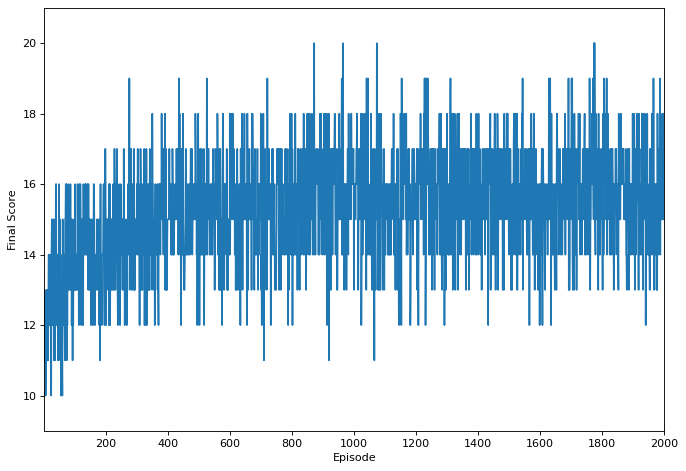

In [268]:
aux_plots.plot_scores(scores)

In [276]:
saveHistory("Episode2000_MinMaxAllFeatures",scores,total_rewards)

Scores and Total rewards for Episode2000_MinMaxAllFeatures saved


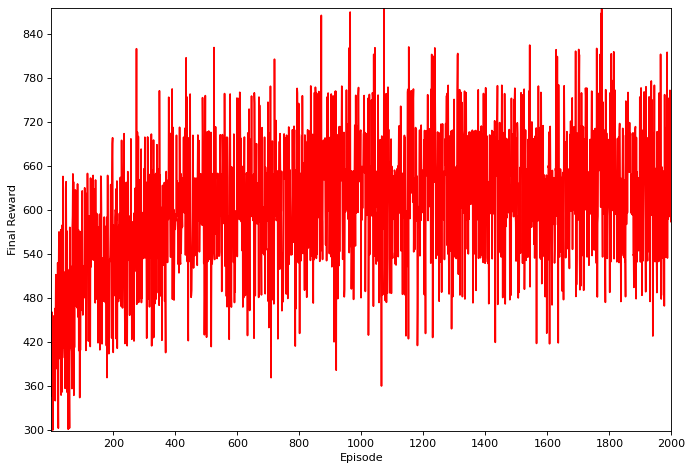

In [270]:
aux_plots.plot_rewards(total_rewards)

# 3. 1 MC approx All Features StandardScalar

In [277]:
from sklearn.preprocessing import StandardScaler

In [278]:
def MonteCarloAprox(RAM_mask: List[int], render: bool=False,typeFeature: int=1):
    epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
    
    return agent.updating(epi,typeFeature,scaler=StandardScaler())

In [279]:
env, initial_state = environment.get_env()

In [280]:
agent = agents.MonteCarloAprox(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0,nFeatures=len(RAM_mask)+1)

In [281]:
scores = []
total_rewards = []

In [282]:
%%time

n_runs = 5000

for i in tqdm(range(n_runs)):
    render = i % 201 == 200
    score, total_reward = MonteCarloAprox(RAM_mask=RAM_mask, render=render)
    scores.append(score)
    total_rewards.append(total_reward)
    print_result(i, scores, total_reward, score)

  0%|          | 1/5000 [00:03<4:34:59,  3.30s/it]

Run [   0] - Total reward:  345.20 Mean scores: 11.00 Means Scores[:-10]: 11.00 Score: 11 


  0%|          | 11/5000 [00:34<4:13:33,  3.05s/it]

Run [  10] - Total reward:  404.70 Mean scores: 12.00 Means Scores[:-10]: 12.10 Score: 12 


  0%|          | 21/5000 [01:03<4:01:07,  2.91s/it]

Run [  20] - Total reward:  361.00 Mean scores: 12.14 Means Scores[:-10]: 12.30 Score: 11 


  1%|          | 31/5000 [01:35<4:25:20,  3.20s/it]

Run [  30] - Total reward:  415.00 Mean scores: 12.26 Means Scores[:-10]: 12.50 Score: 12 


  1%|          | 41/5000 [02:06<4:19:59,  3.15s/it]

Run [  40] - Total reward:  460.10 Mean scores: 12.51 Means Scores[:-10]: 13.30 Score: 13 


  1%|          | 51/5000 [02:34<3:50:09,  2.79s/it]

Run [  50] - Total reward:  468.20 Mean scores: 12.57 Means Scores[:-10]: 12.80 Score: 13 


  1%|          | 61/5000 [03:02<3:46:06,  2.75s/it]

Run [  60] - Total reward:  349.50 Mean scores: 12.70 Means Scores[:-10]: 13.40 Score: 11 


  1%|▏         | 71/5000 [03:29<3:41:38,  2.70s/it]

Run [  70] - Total reward:  471.20 Mean scores: 12.80 Means Scores[:-10]: 13.40 Score: 13 


  2%|▏         | 81/5000 [03:56<3:45:36,  2.75s/it]

Run [  80] - Total reward:  531.20 Mean scores: 12.88 Means Scores[:-10]: 13.40 Score: 14 


  2%|▏         | 91/5000 [04:23<3:39:00,  2.68s/it]

Run [  90] - Total reward:  587.80 Mean scores: 12.88 Means Scores[:-10]: 12.90 Score: 15 


  2%|▏         | 101/5000 [04:50<3:39:01,  2.68s/it]

Run [ 100] - Total reward:  534.20 Mean scores: 12.99 Means Scores[:-10]: 14.00 Score: 14 


  2%|▏         | 111/5000 [05:17<3:36:50,  2.66s/it]

Run [ 110] - Total reward:  528.40 Mean scores: 13.05 Means Scores[:-10]: 13.70 Score: 14 


  2%|▏         | 121/5000 [05:43<3:35:55,  2.66s/it]

Run [ 120] - Total reward:  516.20 Mean scores: 13.09 Means Scores[:-10]: 13.50 Score: 14 


  3%|▎         | 131/5000 [06:10<3:34:42,  2.65s/it]

Run [ 130] - Total reward:  587.80 Mean scores: 13.15 Means Scores[:-10]: 13.90 Score: 15 


  3%|▎         | 141/5000 [06:36<3:32:20,  2.62s/it]

Run [ 140] - Total reward:  531.10 Mean scores: 13.17 Means Scores[:-10]: 13.40 Score: 14 


  3%|▎         | 151/5000 [07:03<3:34:36,  2.66s/it]

Run [ 150] - Total reward:  482.20 Mean scores: 13.28 Means Scores[:-10]: 14.80 Score: 13 


  3%|▎         | 161/5000 [07:32<3:53:10,  2.89s/it]

Run [ 160] - Total reward:  530.50 Mean scores: 13.33 Means Scores[:-10]: 14.10 Score: 14 


  3%|▎         | 171/5000 [08:01<3:50:47,  2.87s/it]

Run [ 170] - Total reward:  644.20 Mean scores: 13.38 Means Scores[:-10]: 14.20 Score: 16 


  4%|▎         | 181/5000 [08:29<3:40:45,  2.75s/it]

Run [ 180] - Total reward:  416.60 Mean scores: 13.46 Means Scores[:-10]: 14.80 Score: 12 


  4%|▍         | 191/5000 [08:55<3:27:03,  2.58s/it]

Run [ 190] - Total reward:  703.20 Mean scores: 13.50 Means Scores[:-10]: 14.20 Score: 17 


  4%|▍         | 201/5000 [09:43<12:12:41,  9.16s/it]

Run [ 200] - Total reward:  314.50 Mean scores: 13.49 Means Scores[:-10]: 13.40 Score: 10 


  4%|▍         | 211/5000 [10:09<3:39:53,  2.75s/it] 

Run [ 210] - Total reward:  587.30 Mean scores: 13.55 Means Scores[:-10]: 14.70 Score: 15 


  4%|▍         | 221/5000 [10:34<3:24:52,  2.57s/it]

Run [ 220] - Total reward:  593.00 Mean scores: 13.62 Means Scores[:-10]: 15.10 Score: 15 


  5%|▍         | 231/5000 [11:00<3:24:00,  2.57s/it]

Run [ 230] - Total reward:  473.50 Mean scores: 13.66 Means Scores[:-10]: 14.60 Score: 13 


  5%|▍         | 241/5000 [11:25<3:22:31,  2.55s/it]

Run [ 240] - Total reward:  576.80 Mean scores: 13.70 Means Scores[:-10]: 14.60 Score: 15 


  5%|▌         | 251/5000 [11:51<3:23:03,  2.57s/it]

Run [ 250] - Total reward:  474.90 Mean scores: 13.73 Means Scores[:-10]: 14.40 Score: 13 


  5%|▌         | 261/5000 [12:17<3:22:04,  2.56s/it]

Run [ 260] - Total reward:  521.20 Mean scores: 13.77 Means Scores[:-10]: 14.80 Score: 14 


  5%|▌         | 271/5000 [12:43<3:22:09,  2.56s/it]

Run [ 270] - Total reward:  471.30 Mean scores: 13.81 Means Scores[:-10]: 14.80 Score: 13 


  6%|▌         | 281/5000 [13:08<3:20:53,  2.55s/it]

Run [ 280] - Total reward:  592.20 Mean scores: 13.81 Means Scores[:-10]: 13.80 Score: 15 


  6%|▌         | 291/5000 [13:34<3:20:46,  2.56s/it]

Run [ 290] - Total reward:  542.60 Mean scores: 13.84 Means Scores[:-10]: 14.80 Score: 14 


  6%|▌         | 301/5000 [14:00<3:22:13,  2.58s/it]

Run [ 300] - Total reward:  636.30 Mean scores: 13.90 Means Scores[:-10]: 15.60 Score: 16 


  6%|▌         | 311/5000 [14:25<3:20:06,  2.56s/it]

Run [ 310] - Total reward:  490.30 Mean scores: 13.94 Means Scores[:-10]: 15.00 Score: 13 


  6%|▋         | 321/5000 [14:51<3:20:21,  2.57s/it]

Run [ 320] - Total reward:  642.20 Mean scores: 13.97 Means Scores[:-10]: 15.00 Score: 16 


  7%|▋         | 331/5000 [15:16<3:18:38,  2.55s/it]

Run [ 330] - Total reward:  528.50 Mean scores: 14.00 Means Scores[:-10]: 14.90 Score: 14 


  7%|▋         | 341/5000 [15:42<3:19:08,  2.56s/it]

Run [ 340] - Total reward:  645.10 Mean scores: 14.01 Means Scores[:-10]: 14.40 Score: 16 


  7%|▋         | 351/5000 [16:08<3:17:42,  2.55s/it]

Run [ 350] - Total reward:  489.50 Mean scores: 14.05 Means Scores[:-10]: 15.60 Score: 13 


  7%|▋         | 361/5000 [16:33<3:16:58,  2.55s/it]

Run [ 360] - Total reward:  645.30 Mean scores: 14.08 Means Scores[:-10]: 15.10 Score: 16 


  7%|▋         | 371/5000 [17:00<3:23:36,  2.64s/it]

Run [ 370] - Total reward:  594.40 Mean scores: 14.11 Means Scores[:-10]: 15.20 Score: 15 


  8%|▊         | 381/5000 [17:25<3:17:40,  2.57s/it]

Run [ 380] - Total reward:  535.80 Mean scores: 14.14 Means Scores[:-10]: 15.20 Score: 14 


  8%|▊         | 391/5000 [17:51<3:18:34,  2.59s/it]

Run [ 390] - Total reward:  632.60 Mean scores: 14.16 Means Scores[:-10]: 14.70 Score: 16 


  8%|▊         | 401/5000 [18:17<3:16:05,  2.56s/it]

Run [ 400] - Total reward:  593.00 Mean scores: 14.18 Means Scores[:-10]: 15.20 Score: 15 


  8%|▊         | 411/5000 [19:02<3:33:52,  2.80s/it] 

Run [ 410] - Total reward:  701.90 Mean scores: 14.19 Means Scores[:-10]: 14.60 Score: 17 


  8%|▊         | 421/5000 [19:28<3:15:36,  2.56s/it]

Run [ 420] - Total reward:  610.80 Mean scores: 14.22 Means Scores[:-10]: 15.20 Score: 15 


  9%|▊         | 431/5000 [19:53<3:17:01,  2.59s/it]

Run [ 430] - Total reward:  586.70 Mean scores: 14.25 Means Scores[:-10]: 15.70 Score: 15 


  9%|▉         | 441/5000 [20:19<3:14:14,  2.56s/it]

Run [ 440] - Total reward:  430.10 Mean scores: 14.27 Means Scores[:-10]: 14.90 Score: 12 


  9%|▉         | 451/5000 [20:45<3:16:13,  2.59s/it]

Run [ 450] - Total reward:  754.10 Mean scores: 14.28 Means Scores[:-10]: 14.90 Score: 18 


  9%|▉         | 461/5000 [21:11<3:13:27,  2.56s/it]

Run [ 460] - Total reward:  596.80 Mean scores: 14.29 Means Scores[:-10]: 14.60 Score: 15 


  9%|▉         | 471/5000 [21:37<3:15:51,  2.59s/it]

Run [ 470] - Total reward:  527.60 Mean scores: 14.29 Means Scores[:-10]: 14.50 Score: 14 


 10%|▉         | 481/5000 [22:02<3:13:37,  2.57s/it]

Run [ 480] - Total reward:  601.60 Mean scores: 14.32 Means Scores[:-10]: 15.70 Score: 15 


 10%|▉         | 491/5000 [22:28<3:12:30,  2.56s/it]

Run [ 490] - Total reward:  649.20 Mean scores: 14.35 Means Scores[:-10]: 15.80 Score: 16 


 10%|█         | 501/5000 [22:54<3:12:02,  2.56s/it]

Run [ 500] - Total reward:  638.80 Mean scores: 14.37 Means Scores[:-10]: 15.30 Score: 16 


 10%|█         | 511/5000 [23:19<3:10:42,  2.55s/it]

Run [ 510] - Total reward:  367.60 Mean scores: 14.38 Means Scores[:-10]: 14.80 Score: 11 


 10%|█         | 521/5000 [23:45<3:09:53,  2.54s/it]

Run [ 520] - Total reward:  632.40 Mean scores: 14.40 Means Scores[:-10]: 15.40 Score: 16 


 11%|█         | 531/5000 [24:10<3:09:53,  2.55s/it]

Run [ 530] - Total reward:  480.90 Mean scores: 14.40 Means Scores[:-10]: 14.30 Score: 13 


 11%|█         | 541/5000 [24:36<3:10:18,  2.56s/it]

Run [ 540] - Total reward:  487.50 Mean scores: 14.43 Means Scores[:-10]: 16.00 Score: 13 


 11%|█         | 551/5000 [25:01<3:09:34,  2.56s/it]

Run [ 550] - Total reward:  580.60 Mean scores: 14.45 Means Scores[:-10]: 16.00 Score: 15 


 11%|█         | 561/5000 [25:27<3:09:29,  2.56s/it]

Run [ 560] - Total reward:  522.70 Mean scores: 14.47 Means Scores[:-10]: 15.20 Score: 14 


 11%|█▏        | 571/5000 [25:53<3:11:24,  2.59s/it]

Run [ 570] - Total reward:  594.50 Mean scores: 14.49 Means Scores[:-10]: 15.50 Score: 15 


 12%|█▏        | 581/5000 [26:19<3:08:01,  2.55s/it]

Run [ 580] - Total reward:  703.50 Mean scores: 14.50 Means Scores[:-10]: 15.10 Score: 17 


 12%|█▏        | 591/5000 [26:44<3:08:03,  2.56s/it]

Run [ 590] - Total reward:  649.20 Mean scores: 14.52 Means Scores[:-10]: 16.00 Score: 16 


 12%|█▏        | 601/5000 [27:10<3:07:04,  2.55s/it]

Run [ 600] - Total reward:  581.60 Mean scores: 14.53 Means Scores[:-10]: 15.30 Score: 15 


 12%|█▏        | 611/5000 [27:55<3:33:40,  2.92s/it] 

Run [ 610] - Total reward:  707.60 Mean scores: 14.55 Means Scores[:-10]: 15.50 Score: 17 


 12%|█▏        | 621/5000 [28:21<3:07:00,  2.56s/it]

Run [ 620] - Total reward:  516.10 Mean scores: 14.57 Means Scores[:-10]: 15.50 Score: 14 


 13%|█▎        | 631/5000 [28:46<3:06:20,  2.56s/it]

Run [ 630] - Total reward:  649.20 Mean scores: 14.58 Means Scores[:-10]: 15.60 Score: 16 


 13%|█▎        | 641/5000 [29:13<3:08:16,  2.59s/it]

Run [ 640] - Total reward:  651.40 Mean scores: 14.61 Means Scores[:-10]: 16.10 Score: 16 


 13%|█▎        | 651/5000 [29:38<3:04:59,  2.55s/it]

Run [ 650] - Total reward:  598.20 Mean scores: 14.61 Means Scores[:-10]: 15.10 Score: 15 


 13%|█▎        | 661/5000 [30:04<3:04:59,  2.56s/it]

Run [ 660] - Total reward:  418.30 Mean scores: 14.61 Means Scores[:-10]: 14.60 Score: 12 


 13%|█▎        | 671/5000 [30:29<3:04:25,  2.56s/it]

Run [ 670] - Total reward:  697.50 Mean scores: 14.64 Means Scores[:-10]: 16.30 Score: 17 


 14%|█▎        | 681/5000 [30:55<3:04:28,  2.56s/it]

Run [ 680] - Total reward:  537.80 Mean scores: 14.65 Means Scores[:-10]: 15.30 Score: 14 


 14%|█▍        | 691/5000 [31:21<3:03:46,  2.56s/it]

Run [ 690] - Total reward:  655.30 Mean scores: 14.66 Means Scores[:-10]: 15.30 Score: 16 


 14%|█▍        | 701/5000 [31:46<3:02:57,  2.55s/it]

Run [ 700] - Total reward:  763.70 Mean scores: 14.67 Means Scores[:-10]: 15.90 Score: 18 


 14%|█▍        | 711/5000 [32:12<3:02:51,  2.56s/it]

Run [ 710] - Total reward:  751.70 Mean scores: 14.68 Means Scores[:-10]: 14.80 Score: 18 


 14%|█▍        | 721/5000 [32:38<3:03:04,  2.57s/it]

Run [ 720] - Total reward:  480.10 Mean scores: 14.69 Means Scores[:-10]: 15.40 Score: 13 


 15%|█▍        | 731/5000 [33:03<3:02:28,  2.56s/it]

Run [ 730] - Total reward:  649.30 Mean scores: 14.70 Means Scores[:-10]: 15.70 Score: 16 


 15%|█▍        | 741/5000 [33:29<3:01:29,  2.56s/it]

Run [ 740] - Total reward:  647.50 Mean scores: 14.70 Means Scores[:-10]: 15.00 Score: 16 


 15%|█▌        | 751/5000 [33:54<3:02:36,  2.58s/it]

Run [ 750] - Total reward:  654.40 Mean scores: 14.72 Means Scores[:-10]: 15.50 Score: 16 


 15%|█▌        | 761/5000 [34:20<3:01:08,  2.56s/it]

Run [ 760] - Total reward:  581.70 Mean scores: 14.71 Means Scores[:-10]: 14.50 Score: 15 


 15%|█▌        | 771/5000 [34:46<3:00:41,  2.56s/it]

Run [ 770] - Total reward:  634.10 Mean scores: 14.73 Means Scores[:-10]: 16.30 Score: 16 


 16%|█▌        | 781/5000 [35:11<3:00:22,  2.57s/it]

Run [ 780] - Total reward:  418.10 Mean scores: 14.73 Means Scores[:-10]: 14.40 Score: 12 


 16%|█▌        | 791/5000 [35:37<2:59:33,  2.56s/it]

Run [ 790] - Total reward:  596.70 Mean scores: 14.74 Means Scores[:-10]: 15.40 Score: 15 


 16%|█▌        | 801/5000 [36:03<2:59:33,  2.57s/it]

Run [ 800] - Total reward:  596.90 Mean scores: 14.75 Means Scores[:-10]: 15.70 Score: 15 


 16%|█▌        | 811/5000 [36:48<3:32:05,  3.04s/it]

Run [ 810] - Total reward:  483.00 Mean scores: 14.76 Means Scores[:-10]: 15.60 Score: 13 


 16%|█▋        | 821/5000 [37:14<2:59:12,  2.57s/it]

Run [ 820] - Total reward:  656.20 Mean scores: 14.76 Means Scores[:-10]: 15.00 Score: 16 


 17%|█▋        | 831/5000 [37:39<2:58:21,  2.57s/it]

Run [ 830] - Total reward:  686.70 Mean scores: 14.77 Means Scores[:-10]: 15.80 Score: 17 


 17%|█▋        | 841/5000 [38:05<2:57:53,  2.57s/it]

Run [ 840] - Total reward:  714.10 Mean scores: 14.79 Means Scores[:-10]: 16.20 Score: 17 


 17%|█▋        | 851/5000 [38:31<2:59:13,  2.59s/it]

Run [ 850] - Total reward:  714.60 Mean scores: 14.80 Means Scores[:-10]: 15.80 Score: 17 


 17%|█▋        | 861/5000 [38:57<2:57:14,  2.57s/it]

Run [ 860] - Total reward:  764.90 Mean scores: 14.82 Means Scores[:-10]: 15.90 Score: 18 


 17%|█▋        | 871/5000 [39:22<2:56:14,  2.56s/it]

Run [ 870] - Total reward:  698.60 Mean scores: 14.83 Means Scores[:-10]: 16.40 Score: 17 


 18%|█▊        | 881/5000 [39:48<2:55:31,  2.56s/it]

Run [ 880] - Total reward:  596.50 Mean scores: 14.84 Means Scores[:-10]: 15.50 Score: 15 


 18%|█▊        | 891/5000 [40:14<2:57:17,  2.59s/it]

Run [ 890] - Total reward:  708.90 Mean scores: 14.85 Means Scores[:-10]: 15.50 Score: 17 


 18%|█▊        | 901/5000 [40:39<2:54:34,  2.56s/it]

Run [ 900] - Total reward:  522.50 Mean scores: 14.85 Means Scores[:-10]: 15.20 Score: 14 


 18%|█▊        | 911/5000 [41:05<2:54:00,  2.55s/it]

Run [ 910] - Total reward:  643.60 Mean scores: 14.86 Means Scores[:-10]: 15.30 Score: 16 


 18%|█▊        | 921/5000 [41:31<2:53:44,  2.56s/it]

Run [ 920] - Total reward:  653.80 Mean scores: 14.86 Means Scores[:-10]: 15.30 Score: 16 


 19%|█▊        | 931/5000 [41:56<2:54:18,  2.57s/it]

Run [ 930] - Total reward:  485.30 Mean scores: 14.87 Means Scores[:-10]: 15.20 Score: 13 


 19%|█▉        | 941/5000 [42:22<2:52:53,  2.56s/it]

Run [ 940] - Total reward:  479.50 Mean scores: 14.88 Means Scores[:-10]: 15.90 Score: 13 


 19%|█▉        | 951/5000 [42:47<2:52:22,  2.55s/it]

Run [ 950] - Total reward:  591.30 Mean scores: 14.88 Means Scores[:-10]: 15.20 Score: 15 


 19%|█▉        | 961/5000 [43:13<2:52:14,  2.56s/it]

Run [ 960] - Total reward:  711.20 Mean scores: 14.89 Means Scores[:-10]: 15.40 Score: 17 


 19%|█▉        | 971/5000 [43:39<2:51:57,  2.56s/it]

Run [ 970] - Total reward:  751.70 Mean scores: 14.90 Means Scores[:-10]: 16.20 Score: 18 


 20%|█▉        | 981/5000 [44:04<2:51:53,  2.57s/it]

Run [ 980] - Total reward:  660.50 Mean scores: 14.91 Means Scores[:-10]: 16.10 Score: 16 


 20%|█▉        | 991/5000 [44:30<2:51:27,  2.57s/it]

Run [ 990] - Total reward:  755.50 Mean scores: 14.92 Means Scores[:-10]: 16.00 Score: 18 


 20%|██        | 1001/5000 [44:56<2:50:31,  2.56s/it]

Run [1000] - Total reward:  757.50 Mean scores: 14.93 Means Scores[:-10]: 15.70 Score: 18 


 20%|██        | 1011/5000 [45:41<3:36:23,  3.25s/it]

Run [1010] - Total reward:  647.40 Mean scores: 14.94 Means Scores[:-10]: 15.70 Score: 16 


 20%|██        | 1021/5000 [46:07<2:51:03,  2.58s/it]

Run [1020] - Total reward:  588.60 Mean scores: 14.95 Means Scores[:-10]: 16.40 Score: 15 


 21%|██        | 1031/5000 [46:32<2:49:24,  2.56s/it]

Run [1030] - Total reward:  595.30 Mean scores: 14.96 Means Scores[:-10]: 15.20 Score: 15 


 21%|██        | 1041/5000 [46:58<2:48:56,  2.56s/it]

Run [1040] - Total reward:  640.80 Mean scores: 14.96 Means Scores[:-10]: 15.30 Score: 16 


 21%|██        | 1051/5000 [47:24<2:53:53,  2.64s/it]

Run [1050] - Total reward:  536.70 Mean scores: 14.96 Means Scores[:-10]: 14.80 Score: 14 


 21%|██        | 1061/5000 [47:50<2:50:10,  2.59s/it]

Run [1060] - Total reward:  700.10 Mean scores: 14.96 Means Scores[:-10]: 15.70 Score: 17 


 21%|██▏       | 1071/5000 [48:15<2:47:48,  2.56s/it]

Run [1070] - Total reward:  649.60 Mean scores: 14.97 Means Scores[:-10]: 15.90 Score: 16 


 22%|██▏       | 1081/5000 [48:41<2:47:29,  2.56s/it]

Run [1080] - Total reward:  544.40 Mean scores: 14.98 Means Scores[:-10]: 16.20 Score: 14 


 22%|██▏       | 1091/5000 [49:07<2:46:32,  2.56s/it]

Run [1090] - Total reward:  546.90 Mean scores: 14.99 Means Scores[:-10]: 16.10 Score: 14 


 22%|██▏       | 1101/5000 [49:33<2:48:09,  2.59s/it]

Run [1100] - Total reward:  532.90 Mean scores: 15.00 Means Scores[:-10]: 15.10 Score: 14 


 22%|██▏       | 1111/5000 [49:59<2:46:42,  2.57s/it]

Run [1110] - Total reward:  816.40 Mean scores: 15.00 Means Scores[:-10]: 15.10 Score: 19 


 22%|██▏       | 1121/5000 [50:24<2:46:17,  2.57s/it]

Run [1120] - Total reward:  651.10 Mean scores: 15.00 Means Scores[:-10]: 15.60 Score: 16 


 23%|██▎       | 1131/5000 [50:50<2:48:23,  2.61s/it]

Run [1130] - Total reward:  639.30 Mean scores: 15.00 Means Scores[:-10]: 15.30 Score: 16 


 23%|██▎       | 1141/5000 [51:16<2:44:45,  2.56s/it]

Run [1140] - Total reward:  594.10 Mean scores: 15.01 Means Scores[:-10]: 15.80 Score: 15 


 23%|██▎       | 1151/5000 [51:41<2:44:05,  2.56s/it]

Run [1150] - Total reward:  573.20 Mean scores: 15.02 Means Scores[:-10]: 15.80 Score: 15 


 23%|██▎       | 1161/5000 [52:07<2:44:07,  2.57s/it]

Run [1160] - Total reward:  649.00 Mean scores: 15.02 Means Scores[:-10]: 15.30 Score: 16 


 23%|██▎       | 1171/5000 [52:33<2:43:45,  2.57s/it]

Run [1170] - Total reward:  581.80 Mean scores: 15.03 Means Scores[:-10]: 15.60 Score: 15 


 24%|██▎       | 1181/5000 [52:58<2:43:26,  2.57s/it]

Run [1180] - Total reward:  755.10 Mean scores: 15.03 Means Scores[:-10]: 15.40 Score: 18 


 24%|██▍       | 1191/5000 [53:24<2:42:40,  2.56s/it]

Run [1190] - Total reward:  595.00 Mean scores: 15.04 Means Scores[:-10]: 15.80 Score: 15 


 24%|██▍       | 1201/5000 [53:50<2:42:55,  2.57s/it]

Run [1200] - Total reward:  653.30 Mean scores: 15.04 Means Scores[:-10]: 15.10 Score: 16 


 24%|██▍       | 1211/5000 [54:35<3:44:50,  3.56s/it]

Run [1210] - Total reward:  487.30 Mean scores: 15.05 Means Scores[:-10]: 16.40 Score: 13 


 24%|██▍       | 1221/5000 [55:01<2:43:13,  2.59s/it]

Run [1220] - Total reward:  752.60 Mean scores: 15.05 Means Scores[:-10]: 15.80 Score: 18 


 25%|██▍       | 1231/5000 [55:26<2:41:33,  2.57s/it]

Run [1230] - Total reward:  541.90 Mean scores: 15.05 Means Scores[:-10]: 15.20 Score: 14 


 25%|██▍       | 1241/5000 [55:52<2:42:51,  2.60s/it]

Run [1240] - Total reward:  666.70 Mean scores: 15.06 Means Scores[:-10]: 16.10 Score: 16 


 25%|██▌       | 1251/5000 [56:18<2:40:07,  2.56s/it]

Run [1250] - Total reward:  605.40 Mean scores: 15.07 Means Scores[:-10]: 15.80 Score: 15 


 25%|██▌       | 1261/5000 [56:44<2:39:36,  2.56s/it]

Run [1260] - Total reward:  820.40 Mean scores: 15.08 Means Scores[:-10]: 16.80 Score: 19 


 25%|██▌       | 1271/5000 [57:09<2:39:17,  2.56s/it]

Run [1270] - Total reward:  577.80 Mean scores: 15.09 Means Scores[:-10]: 16.30 Score: 15 


 26%|██▌       | 1281/5000 [57:35<2:39:44,  2.58s/it]

Run [1280] - Total reward:  591.50 Mean scores: 15.10 Means Scores[:-10]: 16.00 Score: 15 


 26%|██▌       | 1291/5000 [58:01<2:40:53,  2.60s/it]

Run [1290] - Total reward:  747.90 Mean scores: 15.11 Means Scores[:-10]: 16.10 Score: 18 


 26%|██▌       | 1301/5000 [58:27<2:38:50,  2.58s/it]

Run [1300] - Total reward:  490.20 Mean scores: 15.11 Means Scores[:-10]: 15.00 Score: 13 


 26%|██▌       | 1311/5000 [58:52<2:37:46,  2.57s/it]

Run [1310] - Total reward:  645.60 Mean scores: 15.11 Means Scores[:-10]: 16.10 Score: 16 


 26%|██▋       | 1321/5000 [59:18<2:37:23,  2.57s/it]

Run [1320] - Total reward:  636.90 Mean scores: 15.12 Means Scores[:-10]: 15.80 Score: 16 


 27%|██▋       | 1331/5000 [59:44<2:36:45,  2.56s/it]

Run [1330] - Total reward:  520.30 Mean scores: 15.13 Means Scores[:-10]: 16.00 Score: 14 


 27%|██▋       | 1341/5000 [1:00:10<2:37:40,  2.59s/it]

Run [1340] - Total reward:  655.30 Mean scores: 15.13 Means Scores[:-10]: 16.00 Score: 16 


 27%|██▋       | 1351/5000 [1:00:35<2:36:05,  2.57s/it]

Run [1350] - Total reward:  707.90 Mean scores: 15.14 Means Scores[:-10]: 15.80 Score: 17 


 27%|██▋       | 1361/5000 [1:01:01<2:34:48,  2.55s/it]

Run [1360] - Total reward:  533.00 Mean scores: 15.14 Means Scores[:-10]: 15.30 Score: 14 


 27%|██▋       | 1371/5000 [1:01:26<2:34:26,  2.55s/it]

Run [1370] - Total reward:  420.50 Mean scores: 15.14 Means Scores[:-10]: 15.30 Score: 12 


 28%|██▊       | 1381/5000 [1:01:52<2:35:27,  2.58s/it]

Run [1380] - Total reward:  716.20 Mean scores: 15.14 Means Scores[:-10]: 15.80 Score: 17 


 28%|██▊       | 1391/5000 [1:02:18<2:34:05,  2.56s/it]

Run [1390] - Total reward:  703.00 Mean scores: 15.15 Means Scores[:-10]: 15.90 Score: 17 


 28%|██▊       | 1401/5000 [1:02:43<2:33:44,  2.56s/it]

Run [1400] - Total reward:  651.20 Mean scores: 15.16 Means Scores[:-10]: 16.00 Score: 16 


 28%|██▊       | 1411/5000 [1:03:29<3:59:14,  4.00s/it]

Run [1410] - Total reward:  594.60 Mean scores: 15.16 Means Scores[:-10]: 15.80 Score: 15 


 28%|██▊       | 1421/5000 [1:03:55<2:36:50,  2.63s/it]

Run [1420] - Total reward:  704.90 Mean scores: 15.16 Means Scores[:-10]: 15.50 Score: 17 


 29%|██▊       | 1431/5000 [1:04:20<2:32:29,  2.56s/it]

Run [1430] - Total reward:  690.60 Mean scores: 15.17 Means Scores[:-10]: 15.70 Score: 17 


 29%|██▉       | 1441/5000 [1:04:46<2:32:10,  2.57s/it]

Run [1440] - Total reward:  585.10 Mean scores: 15.17 Means Scores[:-10]: 16.20 Score: 15 


 29%|██▉       | 1451/5000 [1:05:12<2:31:57,  2.57s/it]

Run [1450] - Total reward:  751.40 Mean scores: 15.18 Means Scores[:-10]: 15.80 Score: 18 


 29%|██▉       | 1461/5000 [1:05:37<2:31:35,  2.57s/it]

Run [1460] - Total reward:  740.90 Mean scores: 15.19 Means Scores[:-10]: 16.60 Score: 18 


 29%|██▉       | 1471/5000 [1:06:03<2:30:49,  2.56s/it]

Run [1470] - Total reward:  652.00 Mean scores: 15.19 Means Scores[:-10]: 15.30 Score: 16 


 30%|██▉       | 1481/5000 [1:06:29<2:31:09,  2.58s/it]

Run [1480] - Total reward:  481.00 Mean scores: 15.19 Means Scores[:-10]: 15.30 Score: 13 


 30%|██▉       | 1491/5000 [1:06:54<2:30:03,  2.57s/it]

Run [1490] - Total reward:  816.30 Mean scores: 15.19 Means Scores[:-10]: 16.00 Score: 19 


 30%|███       | 1501/5000 [1:07:20<2:29:17,  2.56s/it]

Run [1500] - Total reward:  542.40 Mean scores: 15.20 Means Scores[:-10]: 15.50 Score: 14 


 30%|███       | 1511/5000 [1:07:46<2:28:53,  2.56s/it]

Run [1510] - Total reward:  492.60 Mean scores: 15.20 Means Scores[:-10]: 15.30 Score: 13 


 30%|███       | 1521/5000 [1:08:11<2:28:34,  2.56s/it]

Run [1520] - Total reward:  651.30 Mean scores: 15.20 Means Scores[:-10]: 15.60 Score: 16 


 31%|███       | 1531/5000 [1:08:37<2:29:33,  2.59s/it]

Run [1530] - Total reward:  662.10 Mean scores: 15.21 Means Scores[:-10]: 16.50 Score: 16 


 31%|███       | 1541/5000 [1:09:03<2:28:10,  2.57s/it]

Run [1540] - Total reward:  703.50 Mean scores: 15.21 Means Scores[:-10]: 16.00 Score: 17 


 31%|███       | 1551/5000 [1:09:29<2:27:57,  2.57s/it]

Run [1550] - Total reward:  593.20 Mean scores: 15.21 Means Scores[:-10]: 14.90 Score: 15 


 31%|███       | 1561/5000 [1:09:54<2:28:31,  2.59s/it]

Run [1560] - Total reward:  591.30 Mean scores: 15.21 Means Scores[:-10]: 15.50 Score: 15 


 31%|███▏      | 1571/5000 [1:10:20<2:27:34,  2.58s/it]

Run [1570] - Total reward:  604.30 Mean scores: 15.21 Means Scores[:-10]: 14.90 Score: 15 


 32%|███▏      | 1581/5000 [1:10:46<2:26:20,  2.57s/it]

Run [1580] - Total reward:  699.70 Mean scores: 15.21 Means Scores[:-10]: 15.40 Score: 17 


 32%|███▏      | 1591/5000 [1:11:12<2:25:29,  2.56s/it]

Run [1590] - Total reward:  656.70 Mean scores: 15.22 Means Scores[:-10]: 15.80 Score: 16 


 32%|███▏      | 1601/5000 [1:11:37<2:24:40,  2.55s/it]

Run [1600] - Total reward:  571.90 Mean scores: 15.21 Means Scores[:-10]: 15.00 Score: 15 


 32%|███▏      | 1611/5000 [1:12:23<4:19:53,  4.60s/it]

Run [1610] - Total reward:  758.90 Mean scores: 15.22 Means Scores[:-10]: 16.00 Score: 18 


 32%|███▏      | 1621/5000 [1:12:48<2:27:44,  2.62s/it]

Run [1620] - Total reward:  595.20 Mean scores: 15.22 Means Scores[:-10]: 15.80 Score: 15 


 33%|███▎      | 1631/5000 [1:13:14<2:26:08,  2.60s/it]

Run [1630] - Total reward:  636.70 Mean scores: 15.23 Means Scores[:-10]: 15.80 Score: 16 


 33%|███▎      | 1641/5000 [1:13:40<2:22:50,  2.55s/it]

Run [1640] - Total reward:  707.90 Mean scores: 15.23 Means Scores[:-10]: 15.80 Score: 17 


 33%|███▎      | 1651/5000 [1:14:05<2:23:03,  2.56s/it]

Run [1650] - Total reward:  533.80 Mean scores: 15.24 Means Scores[:-10]: 16.30 Score: 14 


 33%|███▎      | 1661/5000 [1:14:31<2:22:47,  2.57s/it]

Run [1660] - Total reward:  647.00 Mean scores: 15.24 Means Scores[:-10]: 16.10 Score: 16 


 33%|███▎      | 1671/5000 [1:14:57<2:22:45,  2.57s/it]

Run [1670] - Total reward:  650.00 Mean scores: 15.25 Means Scores[:-10]: 16.00 Score: 16 


 34%|███▎      | 1681/5000 [1:15:23<2:22:56,  2.58s/it]

Run [1680] - Total reward:  713.50 Mean scores: 15.25 Means Scores[:-10]: 15.10 Score: 17 


 34%|███▍      | 1691/5000 [1:15:49<2:23:55,  2.61s/it]

Run [1690] - Total reward:  602.10 Mean scores: 15.25 Means Scores[:-10]: 15.40 Score: 15 


 34%|███▍      | 1701/5000 [1:16:14<2:16:53,  2.49s/it]

Run [1700] - Total reward:  534.50 Mean scores: 15.25 Means Scores[:-10]: 15.10 Score: 14 


 34%|███▍      | 1711/5000 [1:16:39<2:20:27,  2.56s/it]

Run [1710] - Total reward:  595.70 Mean scores: 15.25 Means Scores[:-10]: 15.40 Score: 15 


 34%|███▍      | 1721/5000 [1:17:05<2:20:24,  2.57s/it]

Run [1720] - Total reward:  586.80 Mean scores: 15.25 Means Scores[:-10]: 15.70 Score: 15 


 35%|███▍      | 1731/5000 [1:17:31<2:20:44,  2.58s/it]

Run [1730] - Total reward:  764.00 Mean scores: 15.25 Means Scores[:-10]: 16.10 Score: 18 


 35%|███▍      | 1741/5000 [1:17:57<2:20:19,  2.58s/it]

Run [1740] - Total reward:  650.30 Mean scores: 15.26 Means Scores[:-10]: 16.00 Score: 16 


 35%|███▌      | 1751/5000 [1:18:23<2:19:04,  2.57s/it]

Run [1750] - Total reward:  867.00 Mean scores: 15.26 Means Scores[:-10]: 16.20 Score: 20 


 35%|███▌      | 1761/5000 [1:18:48<2:18:32,  2.57s/it]

Run [1760] - Total reward:  481.30 Mean scores: 15.26 Means Scores[:-10]: 14.90 Score: 13 


 35%|███▌      | 1771/5000 [1:19:14<2:18:15,  2.57s/it]

Run [1770] - Total reward:  767.70 Mean scores: 15.26 Means Scores[:-10]: 15.60 Score: 18 


 36%|███▌      | 1781/5000 [1:19:40<2:17:28,  2.56s/it]

Run [1780] - Total reward:  711.40 Mean scores: 15.27 Means Scores[:-10]: 15.80 Score: 17 


 36%|███▌      | 1791/5000 [1:20:05<2:17:25,  2.57s/it]

Run [1790] - Total reward:  760.30 Mean scores: 15.27 Means Scores[:-10]: 15.90 Score: 18 


 36%|███▌      | 1801/5000 [1:20:31<2:17:07,  2.57s/it]

Run [1800] - Total reward:  549.50 Mean scores: 15.27 Means Scores[:-10]: 14.90 Score: 14 


 36%|███▌      | 1811/5000 [1:21:16<4:49:11,  5.44s/it]

Run [1810] - Total reward:  584.70 Mean scores: 15.27 Means Scores[:-10]: 16.10 Score: 15 


 36%|███▋      | 1821/5000 [1:21:42<2:20:15,  2.65s/it]

Run [1820] - Total reward:  647.60 Mean scores: 15.28 Means Scores[:-10]: 15.70 Score: 16 


 37%|███▋      | 1831/5000 [1:22:08<2:15:53,  2.57s/it]

Run [1830] - Total reward:  641.70 Mean scores: 15.27 Means Scores[:-10]: 14.90 Score: 16 


 37%|███▋      | 1841/5000 [1:22:33<2:15:13,  2.57s/it]

Run [1840] - Total reward:  704.90 Mean scores: 15.28 Means Scores[:-10]: 15.80 Score: 17 


 37%|███▋      | 1851/5000 [1:22:59<2:14:47,  2.57s/it]

Run [1850] - Total reward:  526.10 Mean scores: 15.28 Means Scores[:-10]: 16.10 Score: 14 


 37%|███▋      | 1861/5000 [1:23:25<2:14:40,  2.57s/it]

Run [1860] - Total reward:  543.00 Mean scores: 15.28 Means Scores[:-10]: 15.80 Score: 14 


 37%|███▋      | 1871/5000 [1:23:51<2:15:31,  2.60s/it]

Run [1870] - Total reward:  538.80 Mean scores: 15.28 Means Scores[:-10]: 15.50 Score: 14 


 38%|███▊      | 1881/5000 [1:24:16<2:13:28,  2.57s/it]

Run [1880] - Total reward:  818.10 Mean scores: 15.29 Means Scores[:-10]: 15.60 Score: 19 


 38%|███▊      | 1891/5000 [1:24:42<2:12:39,  2.56s/it]

Run [1890] - Total reward:  604.50 Mean scores: 15.29 Means Scores[:-10]: 15.60 Score: 15 


 38%|███▊      | 1901/5000 [1:25:08<2:14:18,  2.60s/it]

Run [1900] - Total reward:  592.80 Mean scores: 15.29 Means Scores[:-10]: 15.20 Score: 15 


 38%|███▊      | 1911/5000 [1:25:34<2:11:01,  2.55s/it]

Run [1910] - Total reward:  542.20 Mean scores: 15.29 Means Scores[:-10]: 16.30 Score: 14 


 38%|███▊      | 1921/5000 [1:25:59<2:11:51,  2.57s/it]

Run [1920] - Total reward:  691.90 Mean scores: 15.29 Means Scores[:-10]: 15.30 Score: 17 


 39%|███▊      | 1931/5000 [1:26:25<2:11:09,  2.56s/it]

Run [1930] - Total reward:  528.50 Mean scores: 15.30 Means Scores[:-10]: 16.20 Score: 14 


 39%|███▉      | 1941/5000 [1:26:50<2:10:45,  2.56s/it]

Run [1940] - Total reward:  653.10 Mean scores: 15.30 Means Scores[:-10]: 15.80 Score: 16 


 39%|███▉      | 1951/5000 [1:27:16<2:11:53,  2.60s/it]

Run [1950] - Total reward:  590.50 Mean scores: 15.30 Means Scores[:-10]: 16.00 Score: 15 


 39%|███▉      | 1961/5000 [1:27:42<2:09:59,  2.57s/it]

Run [1960] - Total reward:  652.90 Mean scores: 15.30 Means Scores[:-10]: 15.30 Score: 16 


 39%|███▉      | 1971/5000 [1:28:08<2:09:19,  2.56s/it]

Run [1970] - Total reward:  708.90 Mean scores: 15.31 Means Scores[:-10]: 15.80 Score: 17 


 40%|███▉      | 1981/5000 [1:28:33<2:09:29,  2.57s/it]

Run [1980] - Total reward:  424.10 Mean scores: 15.31 Means Scores[:-10]: 15.30 Score: 12 


 40%|███▉      | 1991/5000 [1:28:59<2:10:55,  2.61s/it]

Run [1990] - Total reward:  520.20 Mean scores: 15.30 Means Scores[:-10]: 14.60 Score: 14 


 40%|████      | 2001/5000 [1:29:25<2:08:19,  2.57s/it]

Run [2000] - Total reward:  763.40 Mean scores: 15.30 Means Scores[:-10]: 15.50 Score: 18 


 40%|████      | 2011/5000 [1:30:11<5:35:04,  6.73s/it]

Run [2010] - Total reward:  538.10 Mean scores: 15.31 Means Scores[:-10]: 15.80 Score: 14 


 40%|████      | 2021/5000 [1:30:36<2:11:52,  2.66s/it]

Run [2020] - Total reward:  490.30 Mean scores: 15.31 Means Scores[:-10]: 15.90 Score: 13 


 41%|████      | 2031/5000 [1:31:02<2:07:48,  2.58s/it]

Run [2030] - Total reward:  650.40 Mean scores: 15.31 Means Scores[:-10]: 15.80 Score: 16 


 41%|████      | 2041/5000 [1:31:27<2:06:34,  2.57s/it]

Run [2040] - Total reward:  594.50 Mean scores: 15.31 Means Scores[:-10]: 15.50 Score: 15 


 41%|████      | 2051/5000 [1:31:53<2:07:26,  2.59s/it]

Run [2050] - Total reward:  533.00 Mean scores: 15.32 Means Scores[:-10]: 16.00 Score: 14 


 41%|████      | 2061/5000 [1:32:19<2:05:52,  2.57s/it]

Run [2060] - Total reward:  764.20 Mean scores: 15.32 Means Scores[:-10]: 15.90 Score: 18 


 41%|████▏     | 2071/5000 [1:32:45<2:04:40,  2.55s/it]

Run [2070] - Total reward:  649.60 Mean scores: 15.32 Means Scores[:-10]: 15.40 Score: 16 


 42%|████▏     | 2081/5000 [1:33:10<2:04:52,  2.57s/it]

Run [2080] - Total reward:  603.90 Mean scores: 15.32 Means Scores[:-10]: 15.50 Score: 15 


 42%|████▏     | 2091/5000 [1:33:36<2:04:39,  2.57s/it]

Run [2090] - Total reward:  751.00 Mean scores: 15.32 Means Scores[:-10]: 15.10 Score: 18 


 42%|████▏     | 2101/5000 [1:34:02<2:05:16,  2.59s/it]

Run [2100] - Total reward:  697.00 Mean scores: 15.32 Means Scores[:-10]: 15.40 Score: 17 


 42%|████▏     | 2111/5000 [1:34:28<2:04:38,  2.59s/it]

Run [2110] - Total reward:  651.50 Mean scores: 15.32 Means Scores[:-10]: 15.60 Score: 16 


 42%|████▏     | 2121/5000 [1:34:53<2:03:33,  2.58s/it]

Run [2120] - Total reward:  576.50 Mean scores: 15.32 Means Scores[:-10]: 15.50 Score: 15 


 43%|████▎     | 2131/5000 [1:35:19<2:02:54,  2.57s/it]

Run [2130] - Total reward:  545.10 Mean scores: 15.32 Means Scores[:-10]: 15.30 Score: 14 


 43%|████▎     | 2141/5000 [1:35:45<2:02:23,  2.57s/it]

Run [2140] - Total reward:  704.30 Mean scores: 15.32 Means Scores[:-10]: 15.90 Score: 17 


 43%|████▎     | 2151/5000 [1:36:10<2:00:24,  2.54s/it]

Run [2150] - Total reward:  532.90 Mean scores: 15.33 Means Scores[:-10]: 15.80 Score: 14 


 43%|████▎     | 2161/5000 [1:36:36<2:01:41,  2.57s/it]

Run [2160] - Total reward:  595.20 Mean scores: 15.32 Means Scores[:-10]: 15.10 Score: 15 


 43%|████▎     | 2171/5000 [1:37:02<2:01:24,  2.58s/it]

Run [2170] - Total reward:  652.40 Mean scores: 15.33 Means Scores[:-10]: 15.50 Score: 16 


 44%|████▎     | 2181/5000 [1:37:28<2:00:43,  2.57s/it]

Run [2180] - Total reward:  594.90 Mean scores: 15.33 Means Scores[:-10]: 15.80 Score: 15 


 44%|████▍     | 2191/5000 [1:37:53<2:00:53,  2.58s/it]

Run [2190] - Total reward:  649.80 Mean scores: 15.33 Means Scores[:-10]: 15.80 Score: 16 


 44%|████▍     | 2201/5000 [1:38:19<2:00:11,  2.58s/it]

Run [2200] - Total reward:  707.00 Mean scores: 15.33 Means Scores[:-10]: 15.50 Score: 17 


 44%|████▍     | 2211/5000 [1:39:04<6:33:38,  8.47s/it]

Run [2210] - Total reward:  658.20 Mean scores: 15.33 Means Scores[:-10]: 14.80 Score: 16 


 44%|████▍     | 2221/5000 [1:39:30<2:07:27,  2.75s/it]

Run [2220] - Total reward:  647.90 Mean scores: 15.33 Means Scores[:-10]: 16.30 Score: 16 


 45%|████▍     | 2231/5000 [1:39:56<1:59:30,  2.59s/it]

Run [2230] - Total reward:  608.00 Mean scores: 15.33 Means Scores[:-10]: 15.20 Score: 15 


 45%|████▍     | 2241/5000 [1:40:22<1:57:56,  2.56s/it]

Run [2240] - Total reward:  535.80 Mean scores: 15.33 Means Scores[:-10]: 15.20 Score: 14 


 45%|████▌     | 2251/5000 [1:40:47<1:57:44,  2.57s/it]

Run [2250] - Total reward:  756.30 Mean scores: 15.33 Means Scores[:-10]: 16.10 Score: 18 


 45%|████▌     | 2261/5000 [1:41:13<1:57:16,  2.57s/it]

Run [2260] - Total reward:  711.90 Mean scores: 15.34 Means Scores[:-10]: 15.90 Score: 17 


 45%|████▌     | 2271/5000 [1:41:39<1:56:19,  2.56s/it]

Run [2270] - Total reward:  595.80 Mean scores: 15.34 Means Scores[:-10]: 16.20 Score: 15 


 46%|████▌     | 2281/5000 [1:42:04<1:56:15,  2.57s/it]

Run [2280] - Total reward:  649.00 Mean scores: 15.34 Means Scores[:-10]: 15.90 Score: 16 


 46%|████▌     | 2291/5000 [1:42:30<1:56:40,  2.58s/it]

Run [2290] - Total reward:  442.40 Mean scores: 15.34 Means Scores[:-10]: 15.50 Score: 12 


 46%|████▌     | 2301/5000 [1:42:56<1:55:37,  2.57s/it]

Run [2300] - Total reward:  695.10 Mean scores: 15.35 Means Scores[:-10]: 16.00 Score: 17 


 46%|████▌     | 2311/5000 [1:43:22<1:55:00,  2.57s/it]

Run [2310] - Total reward:  717.60 Mean scores: 15.35 Means Scores[:-10]: 15.70 Score: 17 


 46%|████▋     | 2321/5000 [1:43:47<1:54:57,  2.57s/it]

Run [2320] - Total reward:  717.50 Mean scores: 15.35 Means Scores[:-10]: 16.20 Score: 17 


 47%|████▋     | 2331/5000 [1:44:13<1:54:48,  2.58s/it]

Run [2330] - Total reward:  708.50 Mean scores: 15.36 Means Scores[:-10]: 16.20 Score: 17 


 47%|████▋     | 2341/5000 [1:44:39<1:54:09,  2.58s/it]

Run [2340] - Total reward:  757.20 Mean scores: 15.36 Means Scores[:-10]: 15.90 Score: 18 


 47%|████▋     | 2351/5000 [1:45:05<1:53:33,  2.57s/it]

Run [2350] - Total reward:  592.00 Mean scores: 15.36 Means Scores[:-10]: 16.10 Score: 15 


 47%|████▋     | 2361/5000 [1:45:30<1:53:37,  2.58s/it]

Run [2360] - Total reward:  769.90 Mean scores: 15.36 Means Scores[:-10]: 15.80 Score: 18 


 47%|████▋     | 2371/5000 [1:45:56<1:53:11,  2.58s/it]

Run [2370] - Total reward:  598.30 Mean scores: 15.36 Means Scores[:-10]: 15.00 Score: 15 


 48%|████▊     | 2381/5000 [1:46:22<1:51:50,  2.56s/it]

Run [2380] - Total reward:  758.10 Mean scores: 15.36 Means Scores[:-10]: 15.60 Score: 18 


 48%|████▊     | 2391/5000 [1:46:48<1:51:42,  2.57s/it]

Run [2390] - Total reward:  827.00 Mean scores: 15.37 Means Scores[:-10]: 16.20 Score: 19 


 48%|████▊     | 2401/5000 [1:47:13<1:51:19,  2.57s/it]

Run [2400] - Total reward:  647.90 Mean scores: 15.37 Means Scores[:-10]: 16.00 Score: 16 


 48%|████▊     | 2411/5000 [1:47:39<1:51:27,  2.58s/it]

Run [2410] - Total reward:  643.10 Mean scores: 15.37 Means Scores[:-10]: 16.00 Score: 16 


 48%|████▊     | 2421/5000 [1:48:25<2:02:10,  2.84s/it]

Run [2420] - Total reward:  602.20 Mean scores: 15.37 Means Scores[:-10]: 15.50 Score: 15 


 49%|████▊     | 2431/5000 [1:48:51<1:50:39,  2.58s/it]

Run [2430] - Total reward:  648.00 Mean scores: 15.37 Means Scores[:-10]: 15.20 Score: 16 


 49%|████▉     | 2441/5000 [1:49:16<1:51:15,  2.61s/it]

Run [2440] - Total reward:  579.30 Mean scores: 15.37 Means Scores[:-10]: 15.10 Score: 15 


 49%|████▉     | 2451/5000 [1:49:42<1:48:51,  2.56s/it]

Run [2450] - Total reward:  710.00 Mean scores: 15.37 Means Scores[:-10]: 15.80 Score: 17 


 49%|████▉     | 2461/5000 [1:50:08<1:48:41,  2.57s/it]

Run [2460] - Total reward:  647.90 Mean scores: 15.37 Means Scores[:-10]: 15.90 Score: 16 


 49%|████▉     | 2471/5000 [1:50:34<1:48:34,  2.58s/it]

Run [2470] - Total reward:  759.20 Mean scores: 15.37 Means Scores[:-10]: 15.20 Score: 18 


 50%|████▉     | 2481/5000 [1:51:00<1:48:05,  2.57s/it]

Run [2480] - Total reward:  763.50 Mean scores: 15.37 Means Scores[:-10]: 15.50 Score: 18 


 50%|████▉     | 2491/5000 [1:51:25<1:47:32,  2.57s/it]

Run [2490] - Total reward:  607.40 Mean scores: 15.38 Means Scores[:-10]: 15.70 Score: 15 


 50%|█████     | 2501/5000 [1:51:51<1:49:14,  2.62s/it]

Run [2500] - Total reward:  586.30 Mean scores: 15.38 Means Scores[:-10]: 15.80 Score: 15 


 50%|█████     | 2511/5000 [1:52:17<1:46:42,  2.57s/it]

Run [2510] - Total reward:  489.10 Mean scores: 15.38 Means Scores[:-10]: 15.70 Score: 13 


 50%|█████     | 2521/5000 [1:52:43<1:46:27,  2.58s/it]

Run [2520] - Total reward:  708.50 Mean scores: 15.38 Means Scores[:-10]: 15.70 Score: 17 


 51%|█████     | 2531/5000 [1:53:09<1:45:33,  2.57s/it]

Run [2530] - Total reward:  707.00 Mean scores: 15.38 Means Scores[:-10]: 15.60 Score: 17 


 51%|█████     | 2541/5000 [1:53:35<1:45:24,  2.57s/it]

Run [2540] - Total reward:  704.50 Mean scores: 15.38 Means Scores[:-10]: 15.80 Score: 17 


 51%|█████     | 2551/5000 [1:54:00<1:45:08,  2.58s/it]

Run [2550] - Total reward:  480.60 Mean scores: 15.38 Means Scores[:-10]: 15.50 Score: 13 


 51%|█████     | 2561/5000 [1:54:26<1:44:43,  2.58s/it]

Run [2560] - Total reward:  585.00 Mean scores: 15.38 Means Scores[:-10]: 14.60 Score: 15 


 51%|█████▏    | 2571/5000 [1:54:52<1:43:59,  2.57s/it]

Run [2570] - Total reward:  583.30 Mean scores: 15.38 Means Scores[:-10]: 15.50 Score: 15 


 52%|█████▏    | 2581/5000 [1:55:18<1:43:43,  2.57s/it]

Run [2580] - Total reward:  714.20 Mean scores: 15.38 Means Scores[:-10]: 15.90 Score: 17 


 52%|█████▏    | 2591/5000 [1:55:43<1:43:23,  2.58s/it]

Run [2590] - Total reward:  605.50 Mean scores: 15.38 Means Scores[:-10]: 14.60 Score: 15 


 52%|█████▏    | 2601/5000 [1:56:09<1:42:25,  2.56s/it]

Run [2600] - Total reward:  536.30 Mean scores: 15.38 Means Scores[:-10]: 15.00 Score: 14 


 52%|█████▏    | 2611/5000 [1:56:35<1:42:09,  2.57s/it]

Run [2610] - Total reward:  484.70 Mean scores: 15.38 Means Scores[:-10]: 15.10 Score: 13 


 52%|█████▏    | 2621/5000 [1:57:20<1:54:52,  2.90s/it]

Run [2620] - Total reward:  762.50 Mean scores: 15.38 Means Scores[:-10]: 15.40 Score: 18 


 53%|█████▎    | 2631/5000 [1:57:46<1:41:50,  2.58s/it]

Run [2630] - Total reward:  591.60 Mean scores: 15.38 Means Scores[:-10]: 15.70 Score: 15 


 53%|█████▎    | 2641/5000 [1:58:11<1:40:51,  2.57s/it]

Run [2640] - Total reward:  704.80 Mean scores: 15.38 Means Scores[:-10]: 15.10 Score: 17 


 53%|█████▎    | 2651/5000 [1:58:37<1:40:19,  2.56s/it]

Run [2650] - Total reward:  584.70 Mean scores: 15.38 Means Scores[:-10]: 16.00 Score: 15 


 53%|█████▎    | 2661/5000 [1:59:03<1:40:47,  2.59s/it]

Run [2660] - Total reward:  710.50 Mean scores: 15.38 Means Scores[:-10]: 16.40 Score: 17 


 53%|█████▎    | 2671/5000 [1:59:28<1:40:04,  2.58s/it]

Run [2670] - Total reward:  593.30 Mean scores: 15.39 Means Scores[:-10]: 16.10 Score: 15 


 54%|█████▎    | 2681/5000 [1:59:54<1:40:25,  2.60s/it]

Run [2680] - Total reward:  653.20 Mean scores: 15.39 Means Scores[:-10]: 15.50 Score: 16 


 54%|█████▍    | 2691/5000 [2:00:20<1:39:09,  2.58s/it]

Run [2690] - Total reward:  651.00 Mean scores: 15.39 Means Scores[:-10]: 15.50 Score: 16 


 54%|█████▍    | 2701/5000 [2:00:46<1:37:28,  2.54s/it]

Run [2700] - Total reward:  759.90 Mean scores: 15.39 Means Scores[:-10]: 16.50 Score: 18 


 54%|█████▍    | 2711/5000 [2:01:12<1:40:12,  2.63s/it]

Run [2710] - Total reward:  635.50 Mean scores: 15.39 Means Scores[:-10]: 15.80 Score: 16 


 54%|█████▍    | 2721/5000 [2:01:38<1:41:00,  2.66s/it]

Run [2720] - Total reward:  610.40 Mean scores: 15.39 Means Scores[:-10]: 15.60 Score: 15 


 55%|█████▍    | 2731/5000 [2:02:04<1:37:31,  2.58s/it]

Run [2730] - Total reward:  544.80 Mean scores: 15.39 Means Scores[:-10]: 15.60 Score: 14 


 55%|█████▍    | 2741/5000 [2:02:30<1:36:55,  2.57s/it]

Run [2740] - Total reward:  640.30 Mean scores: 15.39 Means Scores[:-10]: 15.10 Score: 16 


 55%|█████▌    | 2751/5000 [2:02:56<1:36:05,  2.56s/it]

Run [2750] - Total reward:  707.20 Mean scores: 15.39 Means Scores[:-10]: 15.40 Score: 17 


 55%|█████▌    | 2761/5000 [2:03:21<1:35:51,  2.57s/it]

Run [2760] - Total reward:  650.60 Mean scores: 15.39 Means Scores[:-10]: 15.70 Score: 16 


 55%|█████▌    | 2771/5000 [2:03:47<1:36:21,  2.59s/it]

Run [2770] - Total reward:  541.00 Mean scores: 15.40 Means Scores[:-10]: 16.20 Score: 14 


 56%|█████▌    | 2781/5000 [2:04:13<1:35:27,  2.58s/it]

Run [2780] - Total reward:  649.70 Mean scores: 15.40 Means Scores[:-10]: 16.70 Score: 16 


 56%|█████▌    | 2791/5000 [2:04:39<1:34:08,  2.56s/it]

Run [2790] - Total reward:  758.20 Mean scores: 15.40 Means Scores[:-10]: 16.10 Score: 18 


 56%|█████▌    | 2801/5000 [2:05:04<1:34:00,  2.56s/it]

Run [2800] - Total reward:  549.50 Mean scores: 15.41 Means Scores[:-10]: 15.90 Score: 14 


 56%|█████▌    | 2811/5000 [2:05:30<1:33:41,  2.57s/it]

Run [2810] - Total reward:  641.50 Mean scores: 15.41 Means Scores[:-10]: 16.10 Score: 16 


 56%|█████▋    | 2821/5000 [2:06:15<1:51:07,  3.06s/it]

Run [2820] - Total reward:  535.90 Mean scores: 15.41 Means Scores[:-10]: 15.70 Score: 14 


 57%|█████▋    | 2831/5000 [2:06:41<1:34:30,  2.61s/it]

Run [2830] - Total reward:  655.90 Mean scores: 15.41 Means Scores[:-10]: 15.90 Score: 16 


 57%|█████▋    | 2841/5000 [2:07:07<1:32:39,  2.57s/it]

Run [2840] - Total reward:  714.80 Mean scores: 15.41 Means Scores[:-10]: 15.60 Score: 17 


 57%|█████▋    | 2851/5000 [2:07:33<1:32:27,  2.58s/it]

Run [2850] - Total reward:  596.90 Mean scores: 15.41 Means Scores[:-10]: 15.80 Score: 15 


 57%|█████▋    | 2861/5000 [2:07:59<1:31:51,  2.58s/it]

Run [2860] - Total reward:  591.00 Mean scores: 15.41 Means Scores[:-10]: 15.50 Score: 15 


 57%|█████▋    | 2871/5000 [2:08:24<1:30:50,  2.56s/it]

Run [2870] - Total reward:  648.80 Mean scores: 15.41 Means Scores[:-10]: 15.20 Score: 16 


 58%|█████▊    | 2881/5000 [2:08:50<1:32:06,  2.61s/it]

Run [2880] - Total reward:  557.10 Mean scores: 15.41 Means Scores[:-10]: 16.00 Score: 14 


 58%|█████▊    | 2891/5000 [2:09:16<1:30:53,  2.59s/it]

Run [2890] - Total reward:  523.30 Mean scores: 15.41 Means Scores[:-10]: 15.00 Score: 14 


 58%|█████▊    | 2901/5000 [2:09:42<1:30:34,  2.59s/it]

Run [2900] - Total reward:  647.00 Mean scores: 15.42 Means Scores[:-10]: 16.40 Score: 16 


 58%|█████▊    | 2911/5000 [2:10:08<1:29:29,  2.57s/it]

Run [2910] - Total reward:  539.00 Mean scores: 15.42 Means Scores[:-10]: 15.10 Score: 14 


 58%|█████▊    | 2921/5000 [2:10:34<1:29:17,  2.58s/it]

Run [2920] - Total reward:  765.10 Mean scores: 15.42 Means Scores[:-10]: 15.60 Score: 18 


 59%|█████▊    | 2931/5000 [2:10:59<1:28:21,  2.56s/it]

Run [2930] - Total reward:  654.80 Mean scores: 15.42 Means Scores[:-10]: 15.60 Score: 16 


 59%|█████▉    | 2941/5000 [2:11:25<1:28:04,  2.57s/it]

Run [2940] - Total reward:  539.90 Mean scores: 15.42 Means Scores[:-10]: 16.10 Score: 14 


 59%|█████▉    | 2951/5000 [2:11:51<1:28:00,  2.58s/it]

Run [2950] - Total reward:  655.40 Mean scores: 15.42 Means Scores[:-10]: 15.50 Score: 16 


 59%|█████▉    | 2961/5000 [2:12:17<1:27:30,  2.58s/it]

Run [2960] - Total reward:  701.90 Mean scores: 15.42 Means Scores[:-10]: 16.60 Score: 17 


 59%|█████▉    | 2971/5000 [2:12:42<1:26:11,  2.55s/it]

Run [2970] - Total reward:  650.10 Mean scores: 15.42 Means Scores[:-10]: 15.80 Score: 16 


 60%|█████▉    | 2981/5000 [2:13:08<1:26:23,  2.57s/it]

Run [2980] - Total reward:  426.50 Mean scores: 15.43 Means Scores[:-10]: 15.80 Score: 12 


 60%|█████▉    | 2991/5000 [2:13:34<1:26:06,  2.57s/it]

Run [2990] - Total reward:  701.50 Mean scores: 15.43 Means Scores[:-10]: 15.30 Score: 17 


 60%|██████    | 3001/5000 [2:14:00<1:25:43,  2.57s/it]

Run [3000] - Total reward:  702.80 Mean scores: 15.43 Means Scores[:-10]: 15.90 Score: 17 


 60%|██████    | 3011/5000 [2:14:25<1:25:10,  2.57s/it]

Run [3010] - Total reward:  754.20 Mean scores: 15.43 Means Scores[:-10]: 15.20 Score: 18 


 60%|██████    | 3021/5000 [2:15:11<1:47:39,  3.26s/it]

Run [3020] - Total reward:  547.00 Mean scores: 15.42 Means Scores[:-10]: 14.80 Score: 14 


 61%|██████    | 3031/5000 [2:15:37<1:25:12,  2.60s/it]

Run [3030] - Total reward:  600.70 Mean scores: 15.43 Means Scores[:-10]: 15.90 Score: 15 


 61%|██████    | 3041/5000 [2:16:02<1:24:06,  2.58s/it]

Run [3040] - Total reward:  599.10 Mean scores: 15.43 Means Scores[:-10]: 15.60 Score: 15 


 61%|██████    | 3051/5000 [2:16:28<1:23:19,  2.57s/it]

Run [3050] - Total reward:  605.60 Mean scores: 15.42 Means Scores[:-10]: 15.00 Score: 15 


 61%|██████    | 3061/5000 [2:16:54<1:22:39,  2.56s/it]

Run [3060] - Total reward:  593.10 Mean scores: 15.43 Means Scores[:-10]: 15.90 Score: 15 


 61%|██████▏   | 3071/5000 [2:17:19<1:23:02,  2.58s/it]

Run [3070] - Total reward:  550.10 Mean scores: 15.43 Means Scores[:-10]: 15.90 Score: 14 


 62%|██████▏   | 3081/5000 [2:17:45<1:22:14,  2.57s/it]

Run [3080] - Total reward:  714.30 Mean scores: 15.43 Means Scores[:-10]: 15.70 Score: 17 


 62%|██████▏   | 3091/5000 [2:18:11<1:21:53,  2.57s/it]

Run [3090] - Total reward:  588.50 Mean scores: 15.43 Means Scores[:-10]: 15.90 Score: 15 


 62%|██████▏   | 3101/5000 [2:18:37<1:21:41,  2.58s/it]

Run [3100] - Total reward:  654.00 Mean scores: 15.43 Means Scores[:-10]: 15.00 Score: 16 


 62%|██████▏   | 3111/5000 [2:19:03<1:21:53,  2.60s/it]

Run [3110] - Total reward:  585.60 Mean scores: 15.43 Means Scores[:-10]: 16.00 Score: 15 


 62%|██████▏   | 3121/5000 [2:19:29<1:20:37,  2.57s/it]

Run [3120] - Total reward:  651.60 Mean scores: 15.43 Means Scores[:-10]: 15.70 Score: 16 


 63%|██████▎   | 3131/5000 [2:19:55<1:20:40,  2.59s/it]

Run [3130] - Total reward:  702.30 Mean scores: 15.43 Means Scores[:-10]: 15.50 Score: 17 


 63%|██████▎   | 3141/5000 [2:20:20<1:19:40,  2.57s/it]

Run [3140] - Total reward:  708.30 Mean scores: 15.43 Means Scores[:-10]: 15.70 Score: 17 


 63%|██████▎   | 3151/5000 [2:20:46<1:19:02,  2.56s/it]

Run [3150] - Total reward:  536.20 Mean scores: 15.43 Means Scores[:-10]: 14.80 Score: 14 


 63%|██████▎   | 3161/5000 [2:21:12<1:18:50,  2.57s/it]

Run [3160] - Total reward:  638.40 Mean scores: 15.43 Means Scores[:-10]: 15.50 Score: 16 


 63%|██████▎   | 3171/5000 [2:21:37<1:18:19,  2.57s/it]

Run [3170] - Total reward:  549.10 Mean scores: 15.43 Means Scores[:-10]: 15.50 Score: 14 


 64%|██████▎   | 3181/5000 [2:22:03<1:18:13,  2.58s/it]

Run [3180] - Total reward:  652.90 Mean scores: 15.43 Means Scores[:-10]: 15.80 Score: 16 


 64%|██████▍   | 3191/5000 [2:22:29<1:17:40,  2.58s/it]

Run [3190] - Total reward:  491.00 Mean scores: 15.43 Means Scores[:-10]: 15.00 Score: 13 


 64%|██████▍   | 3201/5000 [2:22:54<1:16:39,  2.56s/it]

Run [3200] - Total reward:  659.70 Mean scores: 15.43 Means Scores[:-10]: 15.40 Score: 16 


 64%|██████▍   | 3211/5000 [2:23:20<1:16:31,  2.57s/it]

Run [3210] - Total reward:  661.30 Mean scores: 15.43 Means Scores[:-10]: 16.10 Score: 16 


 64%|██████▍   | 3221/5000 [2:24:06<1:46:03,  3.58s/it]

Run [3220] - Total reward:  648.50 Mean scores: 15.43 Means Scores[:-10]: 15.30 Score: 16 


 65%|██████▍   | 3231/5000 [2:24:32<1:17:10,  2.62s/it]

Run [3230] - Total reward:  640.10 Mean scores: 15.43 Means Scores[:-10]: 15.40 Score: 16 


 65%|██████▍   | 3241/5000 [2:24:57<1:15:38,  2.58s/it]

Run [3240] - Total reward:  637.10 Mean scores: 15.43 Means Scores[:-10]: 16.10 Score: 16 


 65%|██████▌   | 3251/5000 [2:25:23<1:15:27,  2.59s/it]

Run [3250] - Total reward:  591.40 Mean scores: 15.43 Means Scores[:-10]: 15.60 Score: 15 


 65%|██████▌   | 3261/5000 [2:25:49<1:15:44,  2.61s/it]

Run [3260] - Total reward:  592.60 Mean scores: 15.44 Means Scores[:-10]: 16.30 Score: 15 


 65%|██████▌   | 3271/5000 [2:26:15<1:14:07,  2.57s/it]

Run [3270] - Total reward:  817.80 Mean scores: 15.44 Means Scores[:-10]: 15.70 Score: 19 


 66%|██████▌   | 3281/5000 [2:26:40<1:13:43,  2.57s/it]

Run [3280] - Total reward:  644.50 Mean scores: 15.44 Means Scores[:-10]: 15.60 Score: 16 


 66%|██████▌   | 3291/5000 [2:27:06<1:13:12,  2.57s/it]

Run [3290] - Total reward:  646.10 Mean scores: 15.44 Means Scores[:-10]: 15.10 Score: 16 


 66%|██████▌   | 3301/5000 [2:27:32<1:13:01,  2.58s/it]

Run [3300] - Total reward:  659.90 Mean scores: 15.44 Means Scores[:-10]: 15.60 Score: 16 


 66%|██████▌   | 3311/5000 [2:27:58<1:12:52,  2.59s/it]

Run [3310] - Total reward:  761.30 Mean scores: 15.44 Means Scores[:-10]: 16.40 Score: 18 


 66%|██████▋   | 3321/5000 [2:28:23<1:11:56,  2.57s/it]

Run [3320] - Total reward:  597.70 Mean scores: 15.44 Means Scores[:-10]: 15.10 Score: 15 


 67%|██████▋   | 3331/5000 [2:28:49<1:11:23,  2.57s/it]

Run [3330] - Total reward:  647.40 Mean scores: 15.44 Means Scores[:-10]: 15.50 Score: 16 


 67%|██████▋   | 3341/5000 [2:29:15<1:10:58,  2.57s/it]

Run [3340] - Total reward:  656.60 Mean scores: 15.44 Means Scores[:-10]: 15.60 Score: 16 


 67%|██████▋   | 3351/5000 [2:29:40<1:10:30,  2.57s/it]

Run [3350] - Total reward:  645.70 Mean scores: 15.44 Means Scores[:-10]: 15.40 Score: 16 


 67%|██████▋   | 3361/5000 [2:30:06<1:10:16,  2.57s/it]

Run [3360] - Total reward:  597.20 Mean scores: 15.44 Means Scores[:-10]: 15.60 Score: 15 


 67%|██████▋   | 3371/5000 [2:30:32<1:09:48,  2.57s/it]

Run [3370] - Total reward:  716.60 Mean scores: 15.44 Means Scores[:-10]: 15.60 Score: 17 


 68%|██████▊   | 3381/5000 [2:30:58<1:09:20,  2.57s/it]

Run [3380] - Total reward:  533.80 Mean scores: 15.44 Means Scores[:-10]: 15.40 Score: 14 


 68%|██████▊   | 3391/5000 [2:31:23<1:08:56,  2.57s/it]

Run [3390] - Total reward:  576.90 Mean scores: 15.44 Means Scores[:-10]: 15.60 Score: 15 


 68%|██████▊   | 3401/5000 [2:31:49<1:09:06,  2.59s/it]

Run [3400] - Total reward:  702.10 Mean scores: 15.44 Means Scores[:-10]: 15.80 Score: 17 


 68%|██████▊   | 3411/5000 [2:32:15<1:08:07,  2.57s/it]

Run [3410] - Total reward:  698.90 Mean scores: 15.45 Means Scores[:-10]: 16.40 Score: 17 


 68%|██████▊   | 3421/5000 [2:33:00<1:44:52,  3.99s/it]

Run [3420] - Total reward:  707.20 Mean scores: 15.45 Means Scores[:-10]: 15.80 Score: 17 


 69%|██████▊   | 3431/5000 [2:33:26<1:08:16,  2.61s/it]

Run [3430] - Total reward:  750.80 Mean scores: 15.45 Means Scores[:-10]: 16.30 Score: 18 


 69%|██████▉   | 3441/5000 [2:33:52<1:07:42,  2.61s/it]

Run [3440] - Total reward:  479.00 Mean scores: 15.45 Means Scores[:-10]: 14.90 Score: 13 


 69%|██████▉   | 3451/5000 [2:34:18<1:06:20,  2.57s/it]

Run [3450] - Total reward:  697.60 Mean scores: 15.45 Means Scores[:-10]: 16.10 Score: 17 


 69%|██████▉   | 3461/5000 [2:34:43<1:07:06,  2.62s/it]

Run [3460] - Total reward:  647.30 Mean scores: 15.45 Means Scores[:-10]: 16.20 Score: 16 


 69%|██████▉   | 3471/5000 [2:35:09<1:05:40,  2.58s/it]

Run [3470] - Total reward:  540.60 Mean scores: 15.45 Means Scores[:-10]: 15.80 Score: 14 


 70%|██████▉   | 3481/5000 [2:35:35<1:05:13,  2.58s/it]

Run [3480] - Total reward:  647.30 Mean scores: 15.45 Means Scores[:-10]: 16.00 Score: 16 


 70%|██████▉   | 3491/5000 [2:36:01<1:04:53,  2.58s/it]

Run [3490] - Total reward:  527.10 Mean scores: 15.45 Means Scores[:-10]: 15.20 Score: 14 


 70%|███████   | 3501/5000 [2:36:27<1:04:29,  2.58s/it]

Run [3500] - Total reward:  536.30 Mean scores: 15.45 Means Scores[:-10]: 15.20 Score: 14 


 70%|███████   | 3511/5000 [2:36:52<1:03:51,  2.57s/it]

Run [3510] - Total reward:  590.40 Mean scores: 15.45 Means Scores[:-10]: 14.40 Score: 15 


 70%|███████   | 3521/5000 [2:37:18<1:03:46,  2.59s/it]

Run [3520] - Total reward:  698.40 Mean scores: 15.45 Means Scores[:-10]: 15.20 Score: 17 


 71%|███████   | 3531/5000 [2:37:44<1:03:08,  2.58s/it]

Run [3530] - Total reward:  651.90 Mean scores: 15.45 Means Scores[:-10]: 15.60 Score: 16 


 71%|███████   | 3541/5000 [2:38:10<1:02:32,  2.57s/it]

Run [3540] - Total reward:  496.50 Mean scores: 15.45 Means Scores[:-10]: 15.10 Score: 13 


 71%|███████   | 3551/5000 [2:38:36<1:02:07,  2.57s/it]

Run [3550] - Total reward:  592.00 Mean scores: 15.45 Means Scores[:-10]: 16.10 Score: 15 


 71%|███████   | 3561/5000 [2:39:01<1:01:36,  2.57s/it]

Run [3560] - Total reward:  818.50 Mean scores: 15.45 Means Scores[:-10]: 16.30 Score: 19 


 71%|███████▏  | 3571/5000 [2:39:27<1:01:17,  2.57s/it]

Run [3570] - Total reward:  765.10 Mean scores: 15.45 Means Scores[:-10]: 15.60 Score: 18 


 72%|███████▏  | 3581/5000 [2:39:53<1:01:29,  2.60s/it]

Run [3580] - Total reward:  705.70 Mean scores: 15.45 Means Scores[:-10]: 15.40 Score: 17 


 72%|███████▏  | 3591/5000 [2:40:19<1:01:07,  2.60s/it]

Run [3590] - Total reward:  653.20 Mean scores: 15.45 Means Scores[:-10]: 15.50 Score: 16 


 72%|███████▏  | 3601/5000 [2:40:45<1:00:00,  2.57s/it]

Run [3600] - Total reward:  591.50 Mean scores: 15.45 Means Scores[:-10]: 15.30 Score: 15 


 72%|███████▏  | 3611/5000 [2:41:10<59:29,  2.57s/it]  

Run [3610] - Total reward:  591.60 Mean scores: 15.45 Means Scores[:-10]: 15.60 Score: 15 


 72%|███████▏  | 3621/5000 [2:41:56<1:45:42,  4.60s/it]

Run [3620] - Total reward:  542.10 Mean scores: 15.45 Means Scores[:-10]: 15.30 Score: 14 


 73%|███████▎  | 3631/5000 [2:42:21<59:26,  2.60s/it]  

Run [3630] - Total reward:  751.80 Mean scores: 15.45 Means Scores[:-10]: 15.60 Score: 18 


 73%|███████▎  | 3641/5000 [2:42:47<58:09,  2.57s/it]

Run [3640] - Total reward:  656.00 Mean scores: 15.45 Means Scores[:-10]: 15.80 Score: 16 


 73%|███████▎  | 3651/5000 [2:43:13<57:59,  2.58s/it]

Run [3650] - Total reward:  532.60 Mean scores: 15.45 Means Scores[:-10]: 15.50 Score: 14 


 73%|███████▎  | 3661/5000 [2:43:38<57:20,  2.57s/it]

Run [3660] - Total reward:  800.80 Mean scores: 15.46 Means Scores[:-10]: 16.50 Score: 19 


 73%|███████▎  | 3671/5000 [2:44:04<57:05,  2.58s/it]

Run [3670] - Total reward:  706.50 Mean scores: 15.46 Means Scores[:-10]: 15.80 Score: 17 


 74%|███████▎  | 3681/5000 [2:44:30<56:35,  2.57s/it]

Run [3680] - Total reward:  495.70 Mean scores: 15.46 Means Scores[:-10]: 14.50 Score: 13 


 74%|███████▍  | 3691/5000 [2:44:56<56:14,  2.58s/it]

Run [3690] - Total reward:  756.70 Mean scores: 15.46 Means Scores[:-10]: 16.50 Score: 18 


 74%|███████▍  | 3701/5000 [2:45:21<55:47,  2.58s/it]

Run [3700] - Total reward:  612.40 Mean scores: 15.46 Means Scores[:-10]: 16.20 Score: 15 


 74%|███████▍  | 3711/5000 [2:45:47<55:36,  2.59s/it]

Run [3710] - Total reward:  751.80 Mean scores: 15.46 Means Scores[:-10]: 15.90 Score: 18 


 74%|███████▍  | 3721/5000 [2:46:13<54:43,  2.57s/it]

Run [3720] - Total reward:  601.20 Mean scores: 15.46 Means Scores[:-10]: 15.40 Score: 15 


 75%|███████▍  | 3731/5000 [2:46:39<54:10,  2.56s/it]

Run [3730] - Total reward:  593.70 Mean scores: 15.46 Means Scores[:-10]: 15.40 Score: 15 


 75%|███████▍  | 3741/5000 [2:47:04<53:49,  2.57s/it]

Run [3740] - Total reward:  543.70 Mean scores: 15.46 Means Scores[:-10]: 15.70 Score: 14 


 75%|███████▌  | 3751/5000 [2:47:30<53:50,  2.59s/it]

Run [3750] - Total reward:  652.40 Mean scores: 15.46 Means Scores[:-10]: 16.20 Score: 16 


 75%|███████▌  | 3761/5000 [2:47:56<53:44,  2.60s/it]

Run [3760] - Total reward:  654.50 Mean scores: 15.47 Means Scores[:-10]: 16.30 Score: 16 


 75%|███████▌  | 3771/5000 [2:48:22<52:44,  2.58s/it]

Run [3770] - Total reward:  708.20 Mean scores: 15.47 Means Scores[:-10]: 15.90 Score: 17 


 76%|███████▌  | 3781/5000 [2:48:48<52:28,  2.58s/it]

Run [3780] - Total reward:  528.70 Mean scores: 15.47 Means Scores[:-10]: 15.40 Score: 14 


 76%|███████▌  | 3791/5000 [2:49:13<51:51,  2.57s/it]

Run [3790] - Total reward:  580.10 Mean scores: 15.47 Means Scores[:-10]: 15.40 Score: 15 


 76%|███████▌  | 3801/5000 [2:49:40<51:42,  2.59s/it]

Run [3800] - Total reward:  706.90 Mean scores: 15.47 Means Scores[:-10]: 15.20 Score: 17 


 76%|███████▌  | 3811/5000 [2:50:05<51:05,  2.58s/it]

Run [3810] - Total reward:  643.80 Mean scores: 15.47 Means Scores[:-10]: 15.20 Score: 16 


 76%|███████▋  | 3821/5000 [2:50:51<1:48:27,  5.52s/it]

Run [3820] - Total reward:  653.00 Mean scores: 15.47 Means Scores[:-10]: 16.20 Score: 16 


 77%|███████▋  | 3831/5000 [2:51:17<51:46,  2.66s/it]  

Run [3830] - Total reward:  411.70 Mean scores: 15.47 Means Scores[:-10]: 15.50 Score: 12 


 77%|███████▋  | 3841/5000 [2:51:43<49:40,  2.57s/it]

Run [3840] - Total reward:  545.10 Mean scores: 15.47 Means Scores[:-10]: 15.00 Score: 14 


 77%|███████▋  | 3851/5000 [2:52:09<49:22,  2.58s/it]

Run [3850] - Total reward:  595.10 Mean scores: 15.47 Means Scores[:-10]: 15.80 Score: 15 


 77%|███████▋  | 3861/5000 [2:52:34<49:05,  2.59s/it]

Run [3860] - Total reward:  603.80 Mean scores: 15.47 Means Scores[:-10]: 15.50 Score: 15 


 77%|███████▋  | 3871/5000 [2:53:00<48:29,  2.58s/it]

Run [3870] - Total reward:  660.30 Mean scores: 15.47 Means Scores[:-10]: 15.60 Score: 16 


 78%|███████▊  | 3881/5000 [2:53:26<47:56,  2.57s/it]

Run [3880] - Total reward:  658.10 Mean scores: 15.47 Means Scores[:-10]: 15.90 Score: 16 


 78%|███████▊  | 3891/5000 [2:53:52<48:01,  2.60s/it]

Run [3890] - Total reward:  650.80 Mean scores: 15.47 Means Scores[:-10]: 15.50 Score: 16 


 78%|███████▊  | 3901/5000 [2:54:18<47:12,  2.58s/it]

Run [3900] - Total reward:  650.80 Mean scores: 15.47 Means Scores[:-10]: 16.20 Score: 16 


 78%|███████▊  | 3911/5000 [2:54:43<46:39,  2.57s/it]

Run [3910] - Total reward:  594.40 Mean scores: 15.47 Means Scores[:-10]: 14.70 Score: 15 


 78%|███████▊  | 3921/5000 [2:55:09<46:25,  2.58s/it]

Run [3920] - Total reward:  691.30 Mean scores: 15.47 Means Scores[:-10]: 16.50 Score: 17 


 79%|███████▊  | 3931/5000 [2:55:35<45:47,  2.57s/it]

Run [3930] - Total reward:  589.20 Mean scores: 15.47 Means Scores[:-10]: 16.70 Score: 15 


 79%|███████▉  | 3941/5000 [2:56:01<45:20,  2.57s/it]

Run [3940] - Total reward:  529.50 Mean scores: 15.47 Means Scores[:-10]: 15.10 Score: 14 


 79%|███████▉  | 3951/5000 [2:56:26<44:49,  2.56s/it]

Run [3950] - Total reward:  600.00 Mean scores: 15.47 Means Scores[:-10]: 15.20 Score: 15 


 79%|███████▉  | 3961/5000 [2:56:52<44:30,  2.57s/it]

Run [3960] - Total reward:  525.60 Mean scores: 15.47 Means Scores[:-10]: 15.10 Score: 14 


 79%|███████▉  | 3971/5000 [2:57:18<44:06,  2.57s/it]

Run [3970] - Total reward:  772.20 Mean scores: 15.47 Means Scores[:-10]: 15.60 Score: 18 


 80%|███████▉  | 3981/5000 [2:57:43<44:10,  2.60s/it]

Run [3980] - Total reward:  664.00 Mean scores: 15.48 Means Scores[:-10]: 16.60 Score: 16 


 80%|███████▉  | 3991/5000 [2:58:09<43:22,  2.58s/it]

Run [3990] - Total reward:  643.70 Mean scores: 15.48 Means Scores[:-10]: 16.00 Score: 16 


 80%|████████  | 4001/5000 [2:58:35<42:54,  2.58s/it]

Run [4000] - Total reward:  598.80 Mean scores: 15.48 Means Scores[:-10]: 15.60 Score: 15 


 80%|████████  | 4011/5000 [2:59:01<42:22,  2.57s/it]

Run [4010] - Total reward:  532.00 Mean scores: 15.48 Means Scores[:-10]: 14.90 Score: 14 


 80%|████████  | 4021/5000 [2:59:46<1:49:40,  6.72s/it]

Run [4020] - Total reward:  541.30 Mean scores: 15.48 Means Scores[:-10]: 15.80 Score: 14 


 81%|████████  | 4031/5000 [3:00:12<43:22,  2.69s/it]  

Run [4030] - Total reward:  701.30 Mean scores: 15.48 Means Scores[:-10]: 16.80 Score: 17 


 81%|████████  | 4041/5000 [3:00:38<41:14,  2.58s/it]

Run [4040] - Total reward:  711.50 Mean scores: 15.48 Means Scores[:-10]: 15.20 Score: 17 


 81%|████████  | 4051/5000 [3:01:04<40:45,  2.58s/it]

Run [4050] - Total reward:  609.10 Mean scores: 15.48 Means Scores[:-10]: 15.90 Score: 15 


 81%|████████  | 4061/5000 [3:01:30<40:15,  2.57s/it]

Run [4060] - Total reward:  586.80 Mean scores: 15.48 Means Scores[:-10]: 15.60 Score: 15 


 81%|████████▏ | 4071/5000 [3:01:55<40:16,  2.60s/it]

Run [4070] - Total reward:  584.00 Mean scores: 15.48 Means Scores[:-10]: 15.40 Score: 15 


 82%|████████▏ | 4081/5000 [3:02:21<39:26,  2.58s/it]

Run [4080] - Total reward:  600.40 Mean scores: 15.48 Means Scores[:-10]: 15.00 Score: 15 


 82%|████████▏ | 4091/5000 [3:02:47<39:00,  2.57s/it]

Run [4090] - Total reward:  645.40 Mean scores: 15.48 Means Scores[:-10]: 16.00 Score: 16 


 82%|████████▏ | 4101/5000 [3:03:13<38:32,  2.57s/it]

Run [4100] - Total reward:  588.90 Mean scores: 15.48 Means Scores[:-10]: 16.00 Score: 15 


 82%|████████▏ | 4111/5000 [3:03:38<38:03,  2.57s/it]

Run [4110] - Total reward:  586.00 Mean scores: 15.48 Means Scores[:-10]: 15.80 Score: 15 


 82%|████████▏ | 4121/5000 [3:04:04<37:50,  2.58s/it]

Run [4120] - Total reward:  604.00 Mean scores: 15.48 Means Scores[:-10]: 16.20 Score: 15 


 83%|████████▎ | 4131/5000 [3:04:30<37:14,  2.57s/it]

Run [4130] - Total reward:  530.40 Mean scores: 15.48 Means Scores[:-10]: 15.40 Score: 14 


 83%|████████▎ | 4141/5000 [3:04:56<36:46,  2.57s/it]

Run [4140] - Total reward:  703.10 Mean scores: 15.49 Means Scores[:-10]: 16.20 Score: 17 


 83%|████████▎ | 4151/5000 [3:05:21<36:28,  2.58s/it]

Run [4150] - Total reward:  761.20 Mean scores: 15.49 Means Scores[:-10]: 15.80 Score: 18 


 83%|████████▎ | 4161/5000 [3:05:47<36:08,  2.58s/it]

Run [4160] - Total reward:  477.70 Mean scores: 15.48 Means Scores[:-10]: 14.90 Score: 13 


 83%|████████▎ | 4171/5000 [3:06:13<35:35,  2.58s/it]

Run [4170] - Total reward:  531.00 Mean scores: 15.49 Means Scores[:-10]: 16.60 Score: 14 


 84%|████████▎ | 4181/5000 [3:06:39<35:04,  2.57s/it]

Run [4180] - Total reward:  650.40 Mean scores: 15.49 Means Scores[:-10]: 15.30 Score: 16 


 84%|████████▍ | 4191/5000 [3:07:04<34:43,  2.58s/it]

Run [4190] - Total reward:  539.30 Mean scores: 15.49 Means Scores[:-10]: 15.50 Score: 14 


 84%|████████▍ | 4201/5000 [3:07:30<34:18,  2.58s/it]

Run [4200] - Total reward:  712.20 Mean scores: 15.49 Means Scores[:-10]: 15.60 Score: 17 


 84%|████████▍ | 4211/5000 [3:07:56<34:08,  2.60s/it]

Run [4210] - Total reward:  569.60 Mean scores: 15.49 Means Scores[:-10]: 15.10 Score: 15 


 84%|████████▍ | 4221/5000 [3:08:42<1:51:05,  8.56s/it]

Run [4220] - Total reward:  649.90 Mean scores: 15.49 Means Scores[:-10]: 15.90 Score: 16 


 85%|████████▍ | 4231/5000 [3:09:07<35:08,  2.74s/it]  

Run [4230] - Total reward:  653.50 Mean scores: 15.49 Means Scores[:-10]: 16.30 Score: 16 


 85%|████████▍ | 4241/5000 [3:09:33<32:28,  2.57s/it]

Run [4240] - Total reward:  532.10 Mean scores: 15.49 Means Scores[:-10]: 16.50 Score: 14 


 85%|████████▌ | 4251/5000 [3:09:59<32:12,  2.58s/it]

Run [4250] - Total reward:  859.40 Mean scores: 15.49 Means Scores[:-10]: 16.30 Score: 20 


 85%|████████▌ | 4261/5000 [3:10:25<31:39,  2.57s/it]

Run [4260] - Total reward:  756.40 Mean scores: 15.49 Means Scores[:-10]: 16.00 Score: 18 


 85%|████████▌ | 4271/5000 [3:10:51<31:29,  2.59s/it]

Run [4270] - Total reward:  586.10 Mean scores: 15.49 Means Scores[:-10]: 14.50 Score: 15 


 86%|████████▌ | 4281/5000 [3:11:16<30:50,  2.57s/it]

Run [4280] - Total reward:  640.50 Mean scores: 15.49 Means Scores[:-10]: 16.30 Score: 16 


 86%|████████▌ | 4291/5000 [3:11:42<30:07,  2.55s/it]

Run [4290] - Total reward:  595.30 Mean scores: 15.49 Means Scores[:-10]: 15.20 Score: 15 


 86%|████████▌ | 4301/5000 [3:12:08<30:00,  2.58s/it]

Run [4300] - Total reward:  605.40 Mean scores: 15.49 Means Scores[:-10]: 15.90 Score: 15 


 86%|████████▌ | 4311/5000 [3:12:34<29:44,  2.59s/it]

Run [4310] - Total reward:  760.90 Mean scores: 15.49 Means Scores[:-10]: 15.00 Score: 18 


 86%|████████▋ | 4321/5000 [3:12:59<29:06,  2.57s/it]

Run [4320] - Total reward:  654.20 Mean scores: 15.49 Means Scores[:-10]: 15.90 Score: 16 


 87%|████████▋ | 4331/5000 [3:13:25<28:39,  2.57s/it]

Run [4330] - Total reward:  664.20 Mean scores: 15.49 Means Scores[:-10]: 15.00 Score: 16 


 87%|████████▋ | 4341/5000 [3:13:51<28:30,  2.60s/it]

Run [4340] - Total reward:  585.50 Mean scores: 15.49 Means Scores[:-10]: 15.00 Score: 15 


 87%|████████▋ | 4351/5000 [3:14:17<27:47,  2.57s/it]

Run [4350] - Total reward:  484.70 Mean scores: 15.49 Means Scores[:-10]: 15.50 Score: 13 


 87%|████████▋ | 4361/5000 [3:14:42<27:23,  2.57s/it]

Run [4360] - Total reward:  586.60 Mean scores: 15.49 Means Scores[:-10]: 16.30 Score: 15 


 87%|████████▋ | 4371/5000 [3:15:08<26:57,  2.57s/it]

Run [4370] - Total reward:  764.10 Mean scores: 15.49 Means Scores[:-10]: 15.70 Score: 18 


 88%|████████▊ | 4381/5000 [3:15:34<26:28,  2.57s/it]

Run [4380] - Total reward:  598.10 Mean scores: 15.50 Means Scores[:-10]: 15.90 Score: 15 


 88%|████████▊ | 4391/5000 [3:16:00<26:11,  2.58s/it]

Run [4390] - Total reward:  651.40 Mean scores: 15.50 Means Scores[:-10]: 15.70 Score: 16 


 88%|████████▊ | 4401/5000 [3:16:25<25:41,  2.57s/it]

Run [4400] - Total reward:  587.20 Mean scores: 15.50 Means Scores[:-10]: 16.10 Score: 15 


 88%|████████▊ | 4411/5000 [3:16:51<25:18,  2.58s/it]

Run [4410] - Total reward:  655.70 Mean scores: 15.50 Means Scores[:-10]: 15.20 Score: 16 


 88%|████████▊ | 4421/5000 [3:17:17<24:50,  2.57s/it]

Run [4420] - Total reward:  820.00 Mean scores: 15.50 Means Scores[:-10]: 15.60 Score: 19 


 89%|████████▊ | 4431/5000 [3:18:03<26:47,  2.82s/it]  

Run [4430] - Total reward:  597.10 Mean scores: 15.50 Means Scores[:-10]: 15.50 Score: 15 


 89%|████████▉ | 4441/5000 [3:18:28<24:10,  2.59s/it]

Run [4440] - Total reward:  599.30 Mean scores: 15.50 Means Scores[:-10]: 15.80 Score: 15 


 89%|████████▉ | 4451/5000 [3:18:54<23:32,  2.57s/it]

Run [4450] - Total reward:  861.20 Mean scores: 15.50 Means Scores[:-10]: 16.10 Score: 20 


 89%|████████▉ | 4461/5000 [3:19:20<23:07,  2.57s/it]

Run [4460] - Total reward:  596.30 Mean scores: 15.50 Means Scores[:-10]: 15.60 Score: 15 


 89%|████████▉ | 4471/5000 [3:19:46<22:43,  2.58s/it]

Run [4470] - Total reward:  592.40 Mean scores: 15.50 Means Scores[:-10]: 15.30 Score: 15 


 90%|████████▉ | 4481/5000 [3:20:12<22:14,  2.57s/it]

Run [4480] - Total reward:  530.90 Mean scores: 15.50 Means Scores[:-10]: 16.00 Score: 14 


 90%|████████▉ | 4491/5000 [3:20:37<21:51,  2.58s/it]

Run [4490] - Total reward:  655.70 Mean scores: 15.50 Means Scores[:-10]: 15.70 Score: 16 


 90%|█████████ | 4501/5000 [3:21:03<21:22,  2.57s/it]

Run [4500] - Total reward:  651.70 Mean scores: 15.50 Means Scores[:-10]: 15.70 Score: 16 


 90%|█████████ | 4511/5000 [3:21:29<20:56,  2.57s/it]

Run [4510] - Total reward:  699.80 Mean scores: 15.50 Means Scores[:-10]: 15.70 Score: 17 


 90%|█████████ | 4521/5000 [3:21:55<20:47,  2.60s/it]

Run [4520] - Total reward:  581.50 Mean scores: 15.50 Means Scores[:-10]: 15.40 Score: 15 


 91%|█████████ | 4531/5000 [3:22:21<20:08,  2.58s/it]

Run [4530] - Total reward:  707.10 Mean scores: 15.50 Means Scores[:-10]: 16.20 Score: 17 


 91%|█████████ | 4541/5000 [3:22:46<19:43,  2.58s/it]

Run [4540] - Total reward:  647.60 Mean scores: 15.50 Means Scores[:-10]: 15.10 Score: 16 


 91%|█████████ | 4551/5000 [3:23:12<19:17,  2.58s/it]

Run [4550] - Total reward:  714.70 Mean scores: 15.50 Means Scores[:-10]: 15.60 Score: 17 


 91%|█████████ | 4561/5000 [3:23:38<18:48,  2.57s/it]

Run [4560] - Total reward:  695.00 Mean scores: 15.50 Means Scores[:-10]: 15.70 Score: 17 


 91%|█████████▏| 4571/5000 [3:24:04<18:30,  2.59s/it]

Run [4570] - Total reward:  714.10 Mean scores: 15.50 Means Scores[:-10]: 16.30 Score: 17 


 92%|█████████▏| 4581/5000 [3:24:30<17:58,  2.57s/it]

Run [4580] - Total reward:  655.40 Mean scores: 15.50 Means Scores[:-10]: 15.60 Score: 16 


 92%|█████████▏| 4591/5000 [3:24:55<17:36,  2.58s/it]

Run [4590] - Total reward:  639.10 Mean scores: 15.51 Means Scores[:-10]: 16.20 Score: 16 


 92%|█████████▏| 4601/5000 [3:25:21<17:07,  2.58s/it]

Run [4600] - Total reward:  660.40 Mean scores: 15.51 Means Scores[:-10]: 16.10 Score: 16 


 92%|█████████▏| 4611/5000 [3:25:47<16:49,  2.60s/it]

Run [4610] - Total reward:  588.50 Mean scores: 15.51 Means Scores[:-10]: 15.00 Score: 15 


 92%|█████████▏| 4621/5000 [3:26:13<16:16,  2.58s/it]

Run [4620] - Total reward:  552.30 Mean scores: 15.51 Means Scores[:-10]: 15.30 Score: 14 


 93%|█████████▎| 4631/5000 [3:26:58<17:56,  2.92s/it]

Run [4630] - Total reward:  477.10 Mean scores: 15.51 Means Scores[:-10]: 15.50 Score: 13 


 93%|█████████▎| 4641/5000 [3:27:24<15:25,  2.58s/it]

Run [4640] - Total reward:  605.10 Mean scores: 15.51 Means Scores[:-10]: 15.60 Score: 15 


 93%|█████████▎| 4651/5000 [3:27:50<15:02,  2.59s/it]

Run [4650] - Total reward:  650.10 Mean scores: 15.51 Means Scores[:-10]: 15.40 Score: 16 


 93%|█████████▎| 4661/5000 [3:28:16<14:35,  2.58s/it]

Run [4660] - Total reward:  649.30 Mean scores: 15.50 Means Scores[:-10]: 15.20 Score: 16 


 93%|█████████▎| 4671/5000 [3:28:41<14:06,  2.57s/it]

Run [4670] - Total reward:  656.30 Mean scores: 15.51 Means Scores[:-10]: 16.20 Score: 16 


 94%|█████████▎| 4681/5000 [3:29:07<13:41,  2.57s/it]

Run [4680] - Total reward:  718.10 Mean scores: 15.51 Means Scores[:-10]: 16.10 Score: 17 


 94%|█████████▍| 4691/5000 [3:29:33<13:15,  2.58s/it]

Run [4690] - Total reward:  700.00 Mean scores: 15.51 Means Scores[:-10]: 15.90 Score: 17 


 94%|█████████▍| 4701/5000 [3:29:59<12:53,  2.59s/it]

Run [4700] - Total reward:  654.00 Mean scores: 15.51 Means Scores[:-10]: 15.90 Score: 16 


 94%|█████████▍| 4711/5000 [3:30:25<12:22,  2.57s/it]

Run [4710] - Total reward:  711.00 Mean scores: 15.51 Means Scores[:-10]: 15.70 Score: 17 


 94%|█████████▍| 4721/5000 [3:30:50<11:58,  2.58s/it]

Run [4720] - Total reward:  644.30 Mean scores: 15.51 Means Scores[:-10]: 15.50 Score: 16 


 95%|█████████▍| 4731/5000 [3:31:16<11:31,  2.57s/it]

Run [4730] - Total reward:  704.80 Mean scores: 15.51 Means Scores[:-10]: 16.50 Score: 17 


 95%|█████████▍| 4741/5000 [3:31:42<11:09,  2.58s/it]

Run [4740] - Total reward:  551.20 Mean scores: 15.51 Means Scores[:-10]: 15.70 Score: 14 


 95%|█████████▌| 4751/5000 [3:32:08<10:41,  2.58s/it]

Run [4750] - Total reward:  654.80 Mean scores: 15.51 Means Scores[:-10]: 15.20 Score: 16 


 95%|█████████▌| 4761/5000 [3:32:34<10:16,  2.58s/it]

Run [4760] - Total reward:  653.50 Mean scores: 15.51 Means Scores[:-10]: 16.00 Score: 16 


 95%|█████████▌| 4771/5000 [3:32:59<09:48,  2.57s/it]

Run [4770] - Total reward:  662.70 Mean scores: 15.51 Means Scores[:-10]: 15.80 Score: 16 


 96%|█████████▌| 4781/5000 [3:33:25<09:22,  2.57s/it]

Run [4780] - Total reward:  607.20 Mean scores: 15.51 Means Scores[:-10]: 14.70 Score: 15 


 96%|█████████▌| 4791/5000 [3:33:51<09:02,  2.60s/it]

Run [4790] - Total reward:  690.70 Mean scores: 15.51 Means Scores[:-10]: 15.00 Score: 17 


 96%|█████████▌| 4801/5000 [3:34:17<08:32,  2.57s/it]

Run [4800] - Total reward:  648.90 Mean scores: 15.51 Means Scores[:-10]: 15.40 Score: 16 


 96%|█████████▌| 4811/5000 [3:34:42<08:07,  2.58s/it]

Run [4810] - Total reward:  640.20 Mean scores: 15.51 Means Scores[:-10]: 15.90 Score: 16 


 96%|█████████▋| 4821/5000 [3:35:08<07:41,  2.58s/it]

Run [4820] - Total reward:  598.50 Mean scores: 15.51 Means Scores[:-10]: 15.00 Score: 15 


 97%|█████████▋| 4831/5000 [3:35:54<08:42,  3.09s/it]

Run [4830] - Total reward:  542.10 Mean scores: 15.51 Means Scores[:-10]: 15.70 Score: 14 


 97%|█████████▋| 4841/5000 [3:36:19<06:50,  2.58s/it]

Run [4840] - Total reward:  592.90 Mean scores: 15.51 Means Scores[:-10]: 16.20 Score: 15 


 97%|█████████▋| 4851/5000 [3:36:45<06:23,  2.58s/it]

Run [4850] - Total reward:  700.30 Mean scores: 15.51 Means Scores[:-10]: 15.50 Score: 17 


 97%|█████████▋| 4861/5000 [3:37:11<05:57,  2.57s/it]

Run [4860] - Total reward:  561.10 Mean scores: 15.51 Means Scores[:-10]: 14.80 Score: 14 


 97%|█████████▋| 4871/5000 [3:37:37<05:31,  2.57s/it]

Run [4870] - Total reward:  587.40 Mean scores: 15.51 Means Scores[:-10]: 14.80 Score: 15 


 98%|█████████▊| 4881/5000 [3:38:03<05:06,  2.58s/it]

Run [4880] - Total reward:  696.30 Mean scores: 15.51 Means Scores[:-10]: 15.30 Score: 17 


 98%|█████████▊| 4891/5000 [3:38:28<04:40,  2.58s/it]

Run [4890] - Total reward:  536.30 Mean scores: 15.51 Means Scores[:-10]: 15.20 Score: 14 


 98%|█████████▊| 4901/5000 [3:38:54<04:15,  2.58s/it]

Run [4900] - Total reward:  644.80 Mean scores: 15.51 Means Scores[:-10]: 15.20 Score: 16 


 98%|█████████▊| 4911/5000 [3:39:20<03:48,  2.57s/it]

Run [4910] - Total reward:  709.10 Mean scores: 15.51 Means Scores[:-10]: 15.50 Score: 17 


 98%|█████████▊| 4921/5000 [3:39:46<03:22,  2.57s/it]

Run [4920] - Total reward:  600.30 Mean scores: 15.51 Means Scores[:-10]: 15.60 Score: 15 


 99%|█████████▊| 4931/5000 [3:40:11<02:57,  2.57s/it]

Run [4930] - Total reward:  650.10 Mean scores: 15.51 Means Scores[:-10]: 16.10 Score: 16 


 99%|█████████▉| 4941/5000 [3:40:37<02:31,  2.57s/it]

Run [4940] - Total reward:  591.20 Mean scores: 15.51 Means Scores[:-10]: 15.80 Score: 15 


 99%|█████████▉| 4951/5000 [3:41:03<02:05,  2.57s/it]

Run [4950] - Total reward:  588.20 Mean scores: 15.51 Means Scores[:-10]: 15.70 Score: 15 


 99%|█████████▉| 4961/5000 [3:41:29<01:39,  2.56s/it]

Run [4960] - Total reward:  650.20 Mean scores: 15.51 Means Scores[:-10]: 15.40 Score: 16 


 99%|█████████▉| 4971/5000 [3:41:54<01:15,  2.60s/it]

Run [4970] - Total reward:  710.40 Mean scores: 15.51 Means Scores[:-10]: 15.80 Score: 17 


100%|█████████▉| 4981/5000 [3:42:20<00:48,  2.57s/it]

Run [4980] - Total reward:  553.30 Mean scores: 15.51 Means Scores[:-10]: 16.10 Score: 14 


100%|█████████▉| 4991/5000 [3:42:46<00:23,  2.57s/it]

Run [4990] - Total reward:  588.90 Mean scores: 15.51 Means Scores[:-10]: 15.40 Score: 15 


100%|██████████| 5000/5000 [3:43:09<00:00,  2.68s/it]

CPU times: user 3h 37min 7s, sys: 6.54 s, total: 3h 37min 13s
Wall time: 3h 43min 9s


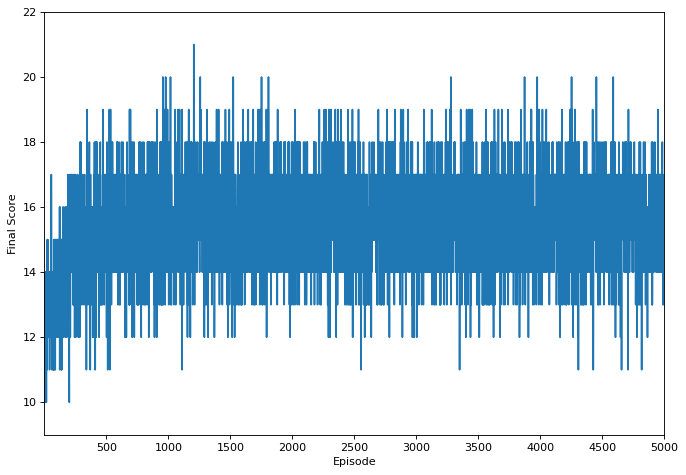

In [283]:
aux_plots.plot_scores(scores)

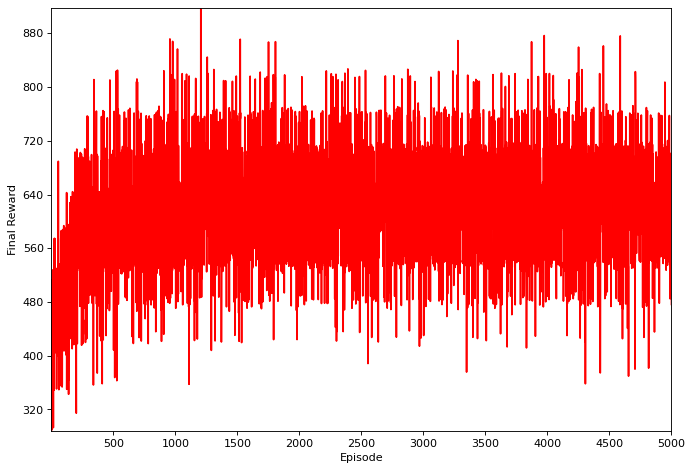

In [284]:
aux_plots.plot_rewards(total_rewards)

In [285]:
saveHistory("Episode5000_StandarScaleAllFeatures",scores,total_rewards)

Scores and Total rewards for Episode5000_StandarScaleAllFeatures saved


# 3. 2 MC approx All Features StandardScalar  + Bias

In [84]:
MonteCarloAprox(RAM_mask=RAM_mask, render=render)

[2 0 0 0 0 0 0 0 0 0 0 0 1]
Feature2
[2. 0. 0. 0. 1.]
[2 0 0 0 0 0 0 0 0 0 0 0 0]
Feature2
[2. 0. 0. 0. 0.]
[2 0 0 0 0 0 0 0 0 0 0 0 0]
Feature2
[2. 0. 0. 0. 0.]
[2 0 0 0 0 0 0 0 0 0 0 0 0]
Feature2
[2. 0. 0. 0. 0.]
[2 0 0 0 0 0 0 0 0 0 0 0 0]
Feature2
[2. 0. 0. 0. 0.]
[2 0 0 0 0 0 0 0 0 0 0 0 1]
Feature2
[2. 0. 0. 0. 1.]
[3 0 0 0 0 0 0 0 0 0 0 0 0]
Feature2
[3. 0. 0. 0. 0.]
[3 0 0 0 0 0 0 0 0 0 0 0 1]
Feature2
[3. 0. 0. 0. 1.]
[4 0 0 0 0 0 6 0 0 0 0 0 1]
Feature2
[4.  0.  0.6 1.  1. ]
[5 0 0 0 0 0 7 0 0 0 0 0 0]
Feature2
[5.  0.  0.7 1.  0. ]
[5 0 0 0 0 0 9 0 0 0 0 0 1]
Feature2
[5.  0.  0.9 1.  1. ]
[5 0 0 0 0 0 9 0 0 0 0 0 1]
Feature2
[5.  0.  0.9 1.  1. ]
[ 6  0  0  0  0  0 10  0  0  0  0  0  1]
Feature2
[6. 0. 1. 1. 1.]
[ 7  0  0  0  0  0 11  0  0  0  0  0  1]
Feature2
[7.  0.  1.1 1.  1. ]
[ 8  0  0  0  0  0 12  0  0  0  0  0  0]
Feature2
[8.  0.  1.2 1.  0. ]
[ 8  0  0  0  0  0 12  0  0  0  0  0  0]
Feature2
[8.  0.  1.2 1.  0. ]
[ 8  0  0  0  0  7 14  0  0  0  0  0  1]
Feature2

[57.   0.   8.2  5.   1. ]
[58  0 18  0 12 18  0 16  0  0 17  0  0]
Feature2
[58.   0.   8.1  5.   0. ]
[58  0 18  0 12 19  0 15  0  0 17  0  1]
Feature2
[58.   0.   8.1  5.   1. ]
[59  0 18  0 13 19  0 14  0  0 17  0  1]
Feature2
[59.   0.   8.1  5.   1. ]
[ 2  0 18  0 13 19  0 13  0  0 16  0  0]
Feature2
[2.  0.  7.9 5.  0. ]
[ 2  0 19  0 13 20  0 12  0  0 16  0  1]
Feature2
[2. 0. 8. 5. 1.]
[ 2  0 19  0 14 21  0 11  0  0 16  0  1]
Feature2
[2.  0.  8.1 5.  1. ]
[ 2  0 19  0 14 21  0 10  0  0 15  0  0]
Feature2
[2.  0.  7.9 5.  0. ]
[ 2  0 19  0 14 22  0  9  0  0 15  0  0]
Feature2
[2.  0.  7.9 5.  0. ]
[ 2  0 19  0 15 22  0  8  0  0 15  0  1]
Feature2
[2.  0.  7.9 5.  1. ]
[ 2  0 20  0 15 23  0  7  0  0 15  0  0]
Feature2
[2. 0. 8. 5. 0.]
[ 2  0 20  0 15 23  0  0  0  0 14  0  0]
Feature2
[2.  0.  7.2 4.  0. ]
[ 2  0 20  0 16 24  0  0  0  0 14  0  1]
Feature2
[2.  0.  7.4 4.  1. ]
[ 3  0 20  0 16 24  0  0  0  0 14  0  0]
Feature2
[3.  0.  7.4 4.  0. ]
[ 3  0 21  0 17 25  0  0  0  0 1

[56.   0.   9.7  5.   0. ]
[56  0 26  6  9 13 26 26  0  0  0 26  1]
Feature2
[56.   0.  13.2  7.   1. ]
[58  0  0  7  9 14  0 25  0  0  0 26  0]
Feature2
[58.   0.   8.1  5.   0. ]
[58  0  0  7 10 14  0 23  0  0  0 26  1]
Feature2
[58.  0.  8.  5.  1.]
[58  0  0  7 10 15  0 23  0  0  0 25  0]
Feature2
[58.  0.  8.  5.  0.]
[59  0  0  8 10 15  0 22  0  0  0 25  1]
Feature2
[59.  0.  8.  5.  1.]
[ 2  0  0  8 10 16  0 21  0  0  0 25  1]
Feature2
[2. 0. 8. 5. 1.]
[ 2  0  0  8 11 16  0 19  0  0  0 25  1]
Feature2
[2.  0.  7.9 5.  1. ]
[ 2  0  0  8 11 17  0 18  0  0  0 25  0]
Feature2
[2.  0.  7.9 5.  0. ]
[ 2  0  0  9 12 18  0 17  0  0  0 24  1]
Feature2
[2. 0. 8. 5. 1.]
[ 2  0  0  9 12 18  0 16  0  0  0 24  0]
Feature2
[2.  0.  7.9 5.  0. ]
[ 2  0  0  9 12 19  0 15  0  0  0 24  0]
Feature2
[2.  0.  7.9 5.  0. ]
[ 2  0  0  9 13 19  0 14  0  0  0 24  1]
Feature2
[2.  0.  7.9 5.  1. ]
[ 2  0  0 10 13 20  0 13  0  0  0 23  1]
Feature2
[2.  0.  7.9 5.  1. ]
[ 2  0  0 10 14 20  0 11  0  0  0 23 

[39  0  0  0 10 15  0 23  0  0 19 15  1]
Feature2
[39.   0.   8.2  5.   1. ]
[40  0  0  0 10 15  0 22  0  0 18 15  0]
Feature2
[40.  0.  8.  5.  0.]
[40  0  0  0 10 16  0 21  0  0 18 14  1]
Feature2
[40.   0.   7.9  5.   1. ]
[42  0  0  0 11 16  0 20  0  0 18 14  1]
Feature2
[42.   0.   7.9  5.   1. ]
[42  0  0  0 11 17  0 19  0  0 18 14  0]
Feature2
[42.   0.   7.9  5.   0. ]
[43  0  0  0 11 17  0 18  0  0 17 14  1]
Feature2
[43.   0.   7.7  5.   1. ]
[44  0  0  0 12 18  0 17  0  0 17 14  0]
Feature2
[44.   0.   7.8  5.   0. ]
[44  0  0  0 12 18  0 16  0  0 17 13  0]
Feature2
[44.   0.   7.6  5.   0. ]
[44  0  0  0 12 19  0 15  0  0 17 13  0]
Feature2
[44.   0.   7.6  5.   0. ]
[44  0  0  0 13 19  0 14  0  0 16 13  0]
Feature2
[44.   0.   7.5  5.   0. ]
[44  0  0  0 13 19  0 13  0  0 16 13  1]
Feature2
[44.   0.   7.4  5.   1. ]
[45  0  0  0 13 20  0 12  0  0 16 13  0]
Feature2
[45.   0.   7.4  5.   0. ]
[45  0  0  0 14 20  0 11  0  0 16 13  1]
Feature2
[45.   0.   7.4  5.   1. ]
[46 

[2.  0.  7.1 4.  1. ]
[ 2  0  0 17 22  0 13  0 19  0  0  0  1]
Feature2
[2.  0.  7.1 4.  1. ]
[ 2  0  0 17 23  0 15  0 19  0  0  0  0]
Feature2
[2.  0.  7.4 4.  0. ]
[ 2  0  0 17 23  0 16  0 18  0  0  0  0]
Feature2
[2.  0.  7.4 4.  0. ]
[ 2  0  0 18 23  0 17  0 17  0  0  0  1]
Feature2
[2.  0.  7.5 4.  1. ]
[ 2  0  0 18 24  0 19  0 17  0  0  0  0]
Feature2
[2.  0.  7.8 4.  0. ]
[ 2  0  0 18 24  0 19  0 16  0  0  0  1]
Feature2
[2.  0.  7.7 4.  1. ]
[ 3  0  0 18 25  0 21  0 16  0  0  0  0]
Feature2
[3. 0. 8. 4. 0.]
[ 3  0  0 19 25  0 22  0 15  0  0  0  1]
Feature2
[3.  0.  8.1 4.  1. ]
[ 4  0  0 19 25  0 23  0 14  0  0  0  1]
Feature2
[4.  0.  8.1 4.  1. ]
[ 5  0  0 19 26  0 25  0 14  0  0  0  0]
Feature2
[5.  0.  8.4 4.  0. ]
[ 5  0  0 20 26  0 26  0 13 26  0  0  1]
Feature2
[ 5.   0.  11.1  5.   1. ]
[ 6  0  0 20 26  0 26 26 13 26  0  0  0]
Feature2
[ 6.   0.  13.7  6.   0. ]
[ 6  0  0 20  0  0  0 25 12 26  0  0  0]
Feature2
[6.  0.  8.3 4.  0. ]
[ 6  0  0 20  0  0  0 25 12 26  0  0 

[43.   0.   7.5  5.   0. ]
[43  0 13  0 22  0 12  0 20  0 10  0  0]
Feature2
[43.   0.   7.7  5.   0. ]
[43  0 13  0 22  0 12  0 20  0 10  0  0]
Feature2
[43.   0.   7.7  5.   0. ]
[43  0 13  0 22  0 13  0 19  0  9  0  0]
Feature2
[43.   0.   7.6  5.   0. ]
[43  0 13  0 22  0 14  0 19  0  9  0  1]
Feature2
[43.   0.   7.7  5.   1. ]
[44  0 13  0 23  0 15  0 19  0  9  0  1]
Feature2
[44.   0.   7.9  5.   1. ]
[45  0 14  0 23  0 15  0 18  0  9  0  0]
Feature2
[45.   0.   7.9  5.   0. ]
[45  0 14  0 23  0 16  0 18  0  9  0  0]
Feature2
[45.  0.  8.  5.  0.]
[45  0 14  0 24  0 18  0 17  0  8  0  0]
Feature2
[45.   0.   8.1  5.   0. ]
[45  0 14  0 24  0 19  0 16  0  8  0  0]
Feature2
[45.   0.   8.1  5.   0. ]
[45  0 15  0 24  0 20  0 16  0  8  0  1]
Feature2
[45.   0.   8.3  5.   1. ]
[46  0 15  0 25  0 21  0 15  0  7  0  1]
Feature2
[46.   0.   8.3  5.   1. ]
[46  0 15  0 25  0 22  0 15  0  7  0  1]
Feature2
[46.   0.   8.4  5.   1. ]
[47  0 15  0 25  0 22  0 15  0  7  0  1]
Feature2
[47.

[ 6.   0.  10.3  5.   0. ]
[ 6  0 26 19 25  0 22  0 15  0  0  0  0]
Feature2
[ 6.   0.  10.7  5.   0. ]
[ 6  0 26 19 25  0 23  0 15  0  0  0  1]
Feature2
[ 6.   0.  10.8  5.   1. ]
[ 6  0 26 19 25  0 23  0 14  0  0  0  1]
Feature2
[ 6.   0.  10.7  5.   1. ]
[ 7  0 26 19 26  0 24  0 14  0  0  0  0]
Feature2
[ 7.   0.  10.9  5.   0. ]
[ 8  0 26 20 26  0 25  0 13 26  0 26  1]
Feature2
[ 8.   0.  16.2  7.   1. ]
[ 9  0  0 20  0  0  0 26 13 26  0 26  0]
Feature2
[ 9.   0.  11.1  5.   0. ]
[ 9  0  0 20  0  0  0 25 12 26  0 26  0]
Feature2
[ 9.   0.  10.9  5.   0. ]
[ 9  0  0 20  0  0  0 23 11 25  0 26  0]
Feature2
[ 9.   0.  10.5  5.   0. ]
[ 9  0  0 21  0  0  0 22 11 25  0 25  0]
Feature2
[ 9.   0.  10.4  5.   0. ]
[ 9  0  0 21  0  0  0 21 10 24  0 25  1]
Feature2
[ 9.   0.  10.1  5.   1. ]
[10  0  0 21  0  0  0 20 10 24  0 25  0]
Feature2
[10.  0. 10.  5.  0.]
[10  0  0 21  0  0  0 19  9 24  0 25  1]
Feature2
[10.   0.   9.8  5.   1. ]
[11  0  0 22  0  0  0 18  9 23  0 25  0]
Feature2
[11.

[16.   0.   5.6  4.   1. ]
[17  0  0  0  0  0  0 13  6 22  0 13  1]
Feature2
[17.   0.   5.4  4.   1. ]
[18  0  0  0  0  0  0 12  0 22  0 13  0]
Feature2
[18.   0.   4.7  3.   0. ]
[18  0  0  0  0  0  0 11  0 21  0 12  0]
Feature2
[18.   0.   4.4  3.   0. ]
[18  0  0  0  0  0  0 10  0 21  0 12  0]
Feature2
[18.   0.   4.3  3.   0. ]
[18  0  0  0  0  0  0  8  0 20  0 12  0]
Feature2
[18.  0.  4.  3.  0.]
[18  0  0  0  0  0  0  8  0 20  0 12  0]
Feature2
[18.  0.  4.  3.  0.]
[18  0  0  0  0  0  0  7  0 20  0 12  0]
Feature2
[18.   0.   3.9  3.   0. ]
[18  0  0  0  0  0  0  6  0 20  0 12  1]
Feature2
[18.   0.   3.8  3.   1. ]
[19  0  0  0  0  0  0  0  0 19  0 11  1]
Feature2
[19.  0.  3.  2.  1.]
[20  0  0  0  0  0  0  0  0 19  0 11  0]
Feature2
[20.  0.  3.  2.  0.]
[20  0  0  0  0  0  0  0  0 18  0 11  1]
Feature2
[20.   0.   2.9  2.   1. ]
[21  0  0  0  0  0  0  0  0 18  0 11  0]
Feature2
[21.   0.   2.9  2.   0. ]
[21  0  0  0  0  0  0  0  0 18  0 10  0]
Feature2
[21.   0.   2.8  2.

[27.   0.   4.1  2.   0. ]
[27  0  0  0  0  0  0  0  0 16 25  0  0]
Feature2
[27.   0.   4.1  2.   0. ]
[27  0  0  0  0  0  0  0  0 15 25  0  1]
Feature2
[27.  0.  4.  2.  1.]
[29  0  0  0  0  0  6  0  0 15 24  0  1]
Feature2
[29.   0.   4.5  3.   1. ]
[29  0  0  0  0  0  7  0  0 15 24  0  1]
Feature2
[29.   0.   4.6  3.   1. ]
[30  0  0  0  0  0  8  0  0 15 24  0  1]
Feature2
[30.   0.   4.7  3.   1. ]
[31  0  0  0  0  0  9  0  0 14 24  0  1]
Feature2
[31.   0.   4.7  3.   1. ]
[32  0  0  0  0  0 10  0  0 14 24  0  0]
Feature2
[32.   0.   4.8  3.   0. ]
[32  0  0  0  0  0 11  0  0 14 23  0  0]
Feature2
[32.   0.   4.8  3.   0. ]
[32  0  0  0  0  0 11  0  0 13 23  0  1]
Feature2
[32.   0.   4.7  3.   1. ]
[33  0  0  0  0  6 13  0  0 13 23  0  0]
Feature2
[33.   0.   5.5  4.   0. ]
[33  0  0  0  0  7 13  0  0 13 23  0  1]
Feature2
[33.   0.   5.6  4.   1. ]
[34  0  0  0  0  7 14  0  0 12 23  0  0]
Feature2
[34.   0.   5.6  4.   0. ]
[34  0  0  0  0  7 15  0  0 12 22  0  1]
Feature2
[34.

Update in 269 : [-2.19950606e+157 -3.31989026e+154  3.08630322e+155 -2.70479409e+157
 -2.60849343e+156 -1.55241441e+157 -2.33094554e+156  1.05469070e+156
 -4.70730434e+157 -2.92844992e+157  2.66748754e+155  0.00000000e+000
 -3.67454520e+157]
Update in 270 : [ 3.72212507e+157 -3.31989026e+154  3.08630322e+155  4.02663276e+157
 -2.60849343e+156 -1.55241441e+157 -2.33094554e+156  1.05469070e+156
  7.31310073e+157  4.76460933e+157  2.66748754e+155  0.00000000e+000
  8.82667608e+157]
Update in 271 : [-7.33340331e+157 -3.31989026e+154  3.08630322e+155 -8.09192720e+157
 -2.60849343e+156 -1.55241441e+157 -2.33094554e+156  1.05469070e+156
 -1.34615735e+158 -9.08517348e+157  2.66748754e+155  0.00000000e+000
 -1.36792210e+158]
Update in 272 : [ 1.29077756e+158 -3.31989026e+154  3.08630322e+155  1.33304346e+158
 -2.60849343e+156 -1.55241441e+157 -2.33094554e+156  1.05469070e+156
  2.32624752e+158  1.53975257e+158  2.66748754e+155  0.00000000e+000
  2.61051651e+158]
Update in 273 : [-1.02215575e+15

Update in 579 : [ 6.74746209e+179  1.31387188e+175  5.85255300e+179 -8.50730540e+173
  7.28562199e+177  1.53047040e+180  7.57582649e+177  7.58286586e+179
 -3.03652157e+173  1.57791604e+180  1.17445924e+180  0.00000000e+000
  1.90423314e+180]
Update in 580 : [-7.81873444e+179  1.31387188e+175 -6.31262212e+179 -8.50730540e+173
  7.28562199e+177 -1.66288807e+180  7.57582649e+177 -7.62360304e+179
 -3.03652157e+173 -1.61544243e+180 -1.25857578e+180  0.00000000e+000
  1.90423314e+180]
Update in 581 : [ 7.36084239e+179  1.31387188e+175  6.36482666e+179 -8.50730540e+173
  7.28562199e+177  1.66494224e+180  7.57582649e+177  6.63852684e+179
 -3.03652157e+173  1.71238788e+180  1.11844586e+180  0.00000000e+000
  1.90423314e+180]
Update in 582 : [-1.46386151e+180  1.31387188e+175 -1.43049933e+180 -8.50730540e+173
  7.28562199e+177 -3.38768041e+180  7.57582649e+177 -1.17346464e+180
 -3.03652157e+173 -2.88090544e+180 -2.32652413e+180  0.00000000e+000
 -4.06704817e+180]
Update in 583 : [ 3.13417385e+18

Update in 915 : [-4.37008334e+196 -1.09837441e+186 -2.10075282e+197 -1.53516683e+197
 -1.99509565e+187 -4.41305492e+196 -2.42369969e+187 -7.80701761e+193
 -2.23293743e+197 -1.36686582e+197  3.60249345e+186  0.00000000e+000
  1.19947935e+197]
Update in 916 : [-4.37008334e+196 -1.09837441e+186  1.71054120e+197  9.50459701e+196
 -1.99509565e+187 -4.41305492e+196  1.15995905e+197 -7.80701761e+193
  1.57835658e+197  1.11876071e+197  3.60249345e+186  0.00000000e+000
  5.50789867e+197]
Update in 917 : [-4.37008334e+196 -1.09837441e+186 -7.01413717e+197 -4.73954793e+197
 -1.99509565e+187 -4.41305492e+196 -1.49537785e+197 -7.80701761e+193
 -6.76698794e+197 -4.57124692e+197  3.60249345e+186  0.00000000e+000
 -4.35478122e+197]
Update in 918 : [-4.37008334e+196 -1.09837441e+186  8.54327338e+197  5.40658939e+197
 -1.99509565e+187 -4.41305492e+196  3.91589539e+197 -7.80701761e+193
  8.11401345e+197  4.89848124e+197  3.60249345e+186  0.00000000e+000
 -4.35478122e+197]
Update in 919 : [-4.37008334e+19

Update in 1332 : [ 3.58040384e+220 -3.68476251e+205  5.45878658e+218  1.55114583e+219
  9.75892343e+218 -1.96534881e+219  4.11174559e+219 -5.61415737e+219
 -7.77597804e+206 -1.46369910e+204  4.20301519e+218  0.00000000e+000
  1.13252872e+220]
Update in 1333 : [ 3.42732552e+220 -3.68476251e+205  5.45878658e+218 -5.72007463e+219
 -8.53262672e+219 -1.65077897e+220  4.11174559e+219 -5.61415737e+219
 -1.45424409e+220 -1.46369910e+204  4.20301519e+218  0.00000000e+000
 -3.21715371e+219]
Update in 1334 : [ 3.70140424e+220 -3.68476251e+205  5.45878658e+218  5.43884477e+219
  6.91818477e+219 -1.65077897e+220  4.11174559e+219 -5.61415737e+219
  7.77539789e+219 -1.46369910e+204  4.20301519e+218  0.00000000e+000
  1.91006851e+220]
Update in 1335 : [ 3.14715717e+220 -3.68476251e+205  5.45878658e+218 -1.58250573e+220
 -2.04211179e+220 -1.65077897e+220  4.11174559e+219 -5.61415737e+219
 -3.01958558e+220 -1.46369910e+204  4.20301519e+218  0.00000000e+000
 -2.03894187e+220]
Update in 1336 : [ 4.2068453

Update in 1631 : [ 1.86762949e+234 -2.72330940e+232  1.39857381e+234 -4.37543597e+232
  1.22482263e+234  1.96987443e+234  8.10739921e+233  3.10843015e+234
 -9.27088718e+233  3.92983463e+232  1.52877861e+234  0.00000000e+000
  6.85966493e+234]
Update in 1632 : [-8.96174839e+234 -2.72330940e+232 -1.76693665e+234 -4.37543597e+232
 -4.57861320e+234 -6.47148678e+234  8.10739921e+233 -6.91568629e+234
 -9.27088718e+233  3.92983463e+232 -7.96775276e+234  0.00000000e+000
 -6.85754704e+234]
Update in 1633 : [ 1.07669023e+235 -2.72330940e+232  4.81477876e+234 -4.37543597e+232
  5.76408243e+234  9.51267920e+234  8.10739921e+233  1.09489698e+235
 -9.27088718e+233  3.92983463e+232  8.95665827e+234  0.00000000e+000
 -6.85754704e+234]
Update in 1634 : [-9.42726830e+234 -2.72330940e+232 -1.92223969e+234 -4.37543597e+232
 -5.78509206e+234 -6.84865132e+234  8.10739921e+233 -5.41236072e+234
 -9.27088718e+233  3.92983463e+232 -7.40467225e+234  0.00000000e+000
 -3.18807584e+235]
Update in 1635 : [ 3.5602728

Update in 1916 : [ 3.18246355e+255 -2.72330940e+232  5.18158329e+255 -4.37543597e+232
  5.81710344e+249  5.29209822e+256 -2.40481342e+256 -4.26983045e+256
 -2.32231488e+256 -3.68249439e+255  9.51582160e+255  0.00000000e+000
 -8.89007490e+255]
Update in 1918 : [ 1.15727697e+255 -2.72330940e+232  3.74937938e+255 -4.37543597e+232
  5.81710344e+249  5.29209822e+256 -2.40481342e+256 -4.26983045e+256
 -2.32231488e+256 -3.68249439e+255  9.51582160e+255  0.00000000e+000
 -8.89007490e+255]
Update in 1921 : [-1.48989440e+254 -2.72330940e+232  2.79480008e+255 -4.37543597e+232
  5.81710344e+249  5.29209822e+256 -2.40481342e+256 -4.26983045e+256
 -2.32231488e+256 -3.68249439e+255  9.51582160e+255  0.00000000e+000
 -8.89007490e+255]
Update in 1926 : [ 4.30104563e+255 -2.72330940e+232  6.34238049e+255 -4.37543597e+232
  5.81710344e+249  5.29209822e+256 -2.40481342e+256 -4.26983045e+256
 -2.32231488e+256 -3.68249439e+255  9.51582160e+255  0.00000000e+000
 -1.20365068e+255]
Update in 1927 : [ 5.6045936

Update in 2214 : [-3.18480242e+272 -1.45915358e+273  2.22759321e+275  2.59128643e+275
  7.01004493e+267  2.64472232e+271 -4.06989122e+274  1.86217085e+275
  9.41142518e+274  2.32646806e+274 -5.56864464e+267  0.00000000e+000
  3.28299622e+275]
Update in 2215 : [-3.18480242e+272 -1.45915358e+273 -3.62471682e+275 -4.56153694e+275
  7.01004493e+267  2.64472232e+271 -4.06989122e+274 -3.33988252e+275
 -1.65988416e+275  2.32646806e+274 -5.56864464e+267  0.00000000e+000
 -5.17034050e+275]
Update in 2216 : [-3.18480242e+272 -1.45915358e+273  6.12900742e+275  7.90155514e+275
  7.01004493e+267  2.64472232e+271 -4.06989122e+274  4.78822101e+275
  2.13323082e+275  2.32646806e+274 -5.56864464e+267  0.00000000e+000
  8.91837229e+275]
Update in 2217 : [-4.07355104e+274 -1.45915358e+273 -9.82017447e+275 -1.24779551e+276
  7.01004493e+267  2.64472232e+271 -4.06989122e+274 -6.73063257e+275
 -3.18316315e+275  2.32646806e+274 -5.56864464e+267  0.00000000e+000
 -1.41193349e+276]
Update in 2218 : [ 3.4124880

Update in 2638 : [-8.32888773e+298  1.77818904e+295 -1.68947288e+299  2.33376209e+298
  1.57295084e+299  1.11415589e+293 -1.45548912e+298 -1.21356523e+299
 -6.06416076e+298 -9.63855516e+298 -4.51590743e+298  0.00000000e+000
  2.08132149e+299]
Update in 2639 : [ 4.22936150e+298  1.77818904e+295 -1.68947288e+299  2.19991524e+299
  1.57295084e+299  1.11415589e+293 -1.45548912e+298  1.14628160e+299
  5.73507340e+298  1.49431827e+299 -4.51590743e+298  0.00000000e+000
  2.08132149e+299]
Update in 2640 : [-2.89748794e+299  1.77818904e+295 -1.68947288e+299 -3.25962822e+299
  1.57295084e+299  1.11415589e+293 -1.45548912e+298 -4.83321838e+299
 -2.28625352e+299 -5.00513823e+299 -4.51590743e+298  0.00000000e+000
 -4.67811327e+299]
Update in 2641 : [ 6.59344421e+299  1.77818904e+295 -1.68947288e+299  1.18075413e+300
  1.57295084e+299  1.11415589e+293 -1.45548912e+298  1.09514354e+300
  5.60607335e+299  1.29319683e+300 -4.51590743e+298  0.00000000e+000
  1.39764775e+300]
Update in 2642 : [-1.9681474

(12, 416.599999999991)

In [183]:
env, initial_state = environment.get_env()

In [184]:
scores = []
total_rewards = []

In [185]:
agent = agents.MonteCarloAprox(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0,nFeatures=5)

In [ ]:
aux_plots.plot_rewards(total_rewards)

# In Construction Ignore!

In [161]:
%%time

n_runs = 1

for i in tqdm(range(n_runs)):
    render = i % 201 == 200
    score, total_reward = MonteCarloAprox(RAM_mask=RAM_mask, render=render)
    scores.append(score)
    total_rewards.append(total_reward)
    print_result(i, scores, total_reward, score)

  0%|          | 0/1 [00:00<?, ?it/s]

Normalized
Update in 0 : [0.009336 0.       0.       0.       0.004668]
Update in 1 : [0.02333916 0.         0.         0.         0.004668  ]
Update in 7 : [0.03735906 0.         0.00327131 0.0046733  0.004668  ]
Update in 8 : [0.05138048 0.         0.00701035 0.00934711 0.004668  ]
Update in 9 : [0.06540324 0.         0.01121718 0.01402136 0.00934226]
Update in 10 : [0.07942432 0.         0.01589088 0.01869505 0.01401595]
Update in 11 : [0.09811417 0.         0.02103058 0.02336751 0.01401595]
Update in 12 : [0.11680396 0.         0.02663752 0.02803996 0.0186884 ]
Update in 13 : [0.14015349 0.         0.03551034 0.03737978 0.0233583 ]
Update in 14 : [0.16815468 0.         0.04531076 0.0467135  0.02802517]
Update in 15 : [0.2007958  0.         0.0555694  0.05603954 0.03268818]
Update in 16 : [0.23806104 0.         0.06674897 0.06535585 0.03734634]
Update in 17 : [0.27993167 0.         0.07791447 0.07466043 0.04199863]
Update in 18 : [0.32176695 0.         0.08953538 0.08395716 0.041998

Update in 203 : [1.00703989e+01 5.86511050e-04 3.21021737e+00 1.98391830e+00
 2.94015250e-01]
Update in 204 : [1.01046105e+01 5.86511050e-04 3.21434635e+00 1.98745743e+00
 2.94015250e-01]
Update in 205 : [1.01386493e+01 5.86511050e-04 3.21833711e+00 1.99097868e+00
 2.94015250e-01]
Update in 206 : [1.01736626e+01 5.86511050e-04 3.22147623e+00 1.99339339e+00
 2.95222605e-01]
Update in 207 : [1.02082839e+01 5.86511050e-04 3.22469959e+00 1.99578107e+00
 2.96416443e-01]
Update in 208 : [1.02407309e+01 5.86511050e-04 3.22761983e+00 1.99794420e+00
 2.97498011e-01]
Update in 209 : [1.02708713e+01 5.86511050e-04 3.23024495e+00 1.99988874e+00
 2.97498011e-01]
Update in 210 : [1.03005572e+01 5.86511050e-04 3.23292626e+00 2.00180396e+00
 2.98455621e-01]
Update in 211 : [1.03277016e+01 5.86511050e-04 3.23530140e+00 2.00350049e+00
 2.98455621e-01]
Update in 212 : [1.03547004e+01 5.86511050e-04 3.23757942e+00 2.00518791e+00
 2.98455621e-01]
Update in 214 : [1.03812846e+01 5.86511050e-04 3.23990554e+0

Update in 375 : [1.13458030e+01 3.48438279e-03 4.40659498e+00 2.75016339e+00
 3.98325900e-01]
Update in 376 : [1.13716970e+01 3.48438279e-03 4.41905646e+00 2.75663689e+00
 3.99944274e-01]
Update in 377 : [1.13972599e+01 3.48438279e-03 4.43048457e+00 2.76265168e+00
 4.01447972e-01]
Update in 378 : [1.14202811e+01 3.48438279e-03 4.44054121e+00 2.76870990e+00
 4.02659615e-01]
Update in 379 : [1.14418530e+01 3.48438279e-03 4.44981713e+00 2.77410288e+00
 4.03738210e-01]
Update in 380 : [1.14620809e+01 3.48438279e-03 4.45800462e+00 2.77891904e+00
 4.04701444e-01]
Update in 381 : [1.14805381e+01 3.48438279e-03 4.46521968e+00 2.78311385e+00
 4.05540405e-01]
Update in 382 : [1.14969688e+01 3.48438279e-03 4.47150623e+00 2.78668576e+00
 4.05540405e-01]
Update in 383 : [1.15133284e+01 3.48438279e-03 4.47769443e+00 2.79024219e+00
 4.06251692e-01]
Update in 384 : [1.15251298e+01 3.48438279e-03 4.48184852e+00 2.79260247e+00
 4.06723748e-01]
Update in 385 : [1.15369823e+01 3.95848361e-03 4.48606802e+0

Update in 561 : [1.02054853e+01 7.45180918e-03 5.40694355e+00 3.28307898e+00
 4.71264308e-01]
Update in 562 : [1.02257028e+01 7.45180918e-03 5.41730506e+00 3.28939697e+00
 4.71264308e-01]
Update in 563 : [1.02459640e+01 7.45180918e-03 5.42743563e+00 3.29572857e+00
 4.72530628e-01]
Update in 564 : [1.02651731e+01 7.45180918e-03 5.43586629e+00 3.30106444e+00
 4.72530628e-01]
Update in 565 : [1.02842361e+01 7.45180918e-03 5.44423284e+00 3.30635972e+00
 4.73589685e-01]
Update in 566 : [1.03025281e+01 7.45180918e-03 5.45164590e+00 3.31117340e+00
 4.74552420e-01]
Update in 567 : [1.03196364e+01 7.45180918e-03 5.45823259e+00 3.31545047e+00
 4.75407834e-01]
Update in 568 : [1.03355750e+01 7.45180918e-03 5.46392496e+00 3.31924538e+00
 4.76166816e-01]
Update in 569 : [1.03499114e+01 7.45180918e-03 5.46881237e+00 3.32250365e+00
 4.76818471e-01]
Update in 570 : [1.03625599e+01 7.45180918e-03 5.47288189e+00 3.32525333e+00
 4.77368406e-01]
Update in 571 : [1.03753669e+01 7.45180918e-03 5.47694673e+0

Update in 787 : [8.64857094e+00 8.63496154e-03 5.90675313e+00 3.54370557e+00
 5.13273089e-01]
Update in 788 : [8.66977514e+00 8.63496154e-03 5.91488141e+00 3.54900662e+00
 5.15040106e-01]
Update in 789 : [8.69107499e+00 8.63496154e-03 5.92286885e+00 3.55433158e+00
 5.15040106e-01]
Update in 790 : [8.71228813e+00 8.63496154e-03 5.93082378e+00 3.55963486e+00
 5.16807868e-01]
Update in 791 : [8.73352632e+00 8.63496154e-03 5.93878810e+00 3.56494441e+00
 5.16807868e-01]
Update in 792 : [8.75567561e+00 8.63496154e-03 5.94561746e+00 3.56863596e+00
 5.18653642e-01]
Update in 793 : [8.77771753e+00 8.63496154e-03 5.95259740e+00 3.57230961e+00
 5.20490469e-01]
Update in 794 : [8.80048380e+00 8.63496154e-03 5.95925216e+00 3.57581212e+00
 5.20490469e-01]
Update in 795 : [8.82307527e+00 8.63496154e-03 5.96602960e+00 3.57928773e+00
 5.22228274e-01]
Update in 796 : [8.84620680e+00 8.63496154e-03 5.97230816e+00 3.58259223e+00
 5.23880526e-01]
Update in 797 : [8.86660185e+00 8.63496154e-03 5.98059365e+0

Update in 1018 : [11.42729997  0.02113974  7.26639196  4.37850463  0.62956656]
Update in 1019 : [11.41867184  0.02113974  7.26434677  4.37722639  0.62956656]
Update in 1021 : [11.41038782  0.02113974  7.26244452  4.37599912  0.62925975]
Update in 1022 : [11.39864231  0.02113974  7.25980178  4.37432119  0.62925975]
Update in 1023 : [11.38457897  0.02113974  7.25633617  4.37180988  0.62925975]
Update in 1024 : [11.37028472  0.02113974  7.25276261  4.36925734  0.62874924]
Update in 1025 : [11.35228177  0.02113974  7.24835499  4.36615338  0.62874924]
Update in 1026 : [11.33088791  0.02113974  7.2434344   4.36258774  0.62874924]
Update in 1027 : [11.30929752  0.02113974  7.23832467  4.35898934  0.62874924]
Update in 1028 : [11.28773058  0.02113974  7.23314861  4.35539485  0.62874924]
Update in 1029 : [11.2668383   0.02113974  7.22827374  4.3519128   0.62874924]
Update in 1030 : [11.24622632  0.02045267  7.22339557  4.34847747  0.62874924]
Update in 1031 : [11.22983788  0.01988755  7.2193267

Update in 1267 : [9.59436411 0.02052897 7.92401673 4.73188203 0.67262859]
Update in 1268 : [9.60740174 0.02052897 7.9251032  4.7329685  0.67262859]
Update in 1270 : [9.61872457 0.02052897 7.92596373 4.73387433 0.67262859]
Update in 1271 : [9.63276943 0.02052897 7.92658171 4.73443612 0.67262859]
Update in 1276 : [9.64491516 0.02052897 7.92704885 4.73490327 0.67309573]
Update in 1277 : [9.65483827 0.02052897 7.92741637 4.73527079 0.67346325]
Update in 1278 : [9.66235021 0.02052897 7.92768466 4.73553907 0.67373154]
Update in 1281 : [9.66480581 0.02052897 7.92775832 4.73562093 0.67381339]
Update in 1282 : [9.66432425 0.02052897 7.92774434 4.73560539 0.67379786]
Update in 1283 : [9.66073937 0.02052897 7.92764352 4.73549337 0.67368583]
Update in 1284 : [9.65049838 0.02052897 7.92714699 4.7348727  0.6733755 ]
Update in 1285 : [9.63300048 0.02052897 7.92634708 4.73387282 0.67287556]
Update in 1286 : [9.61567634 0.02052897 7.92550562 4.73288287 0.67287556]
Update in 1287 : [9.59436577 0.0205289

Update in 1529 : [5.1807053  0.01952982 7.81949208 4.61153144 0.66072865]
Update in 1530 : [5.18536685 0.01952982 7.82090997 4.6125026  0.66072865]
Update in 1531 : [5.19005102 0.01952982 7.82231522 4.61347847 0.66092383]
Update in 1532 : [5.19628846 0.01952982 7.82393695 4.61447646 0.66092383]
Update in 1533 : [5.20231269 0.01952982 7.82552735 4.61544033 0.66092383]
Update in 1535 : [5.20818044 0.01952982 7.82707644 4.61637917 0.66115854]
Update in 1536 : [5.21268344 0.01952982 7.82823682 4.61707194 0.66133173]
Update in 1537 : [5.20956559 0.01952982 7.82717445 4.61649456 0.66133173]
Update in 1538 : [5.2119195  0.01952982 7.8277293  4.61683084 0.66133173]
Update in 1539 : [5.21409639 0.01952982 7.82824242 4.61714182 0.66140947]
Update in 1540 : [5.21550094 0.01952982 7.82854755 4.61733555 0.66145791]
Update in 1541 : [5.21537624 0.01952982 7.82852136 4.61731893 0.66145375]
Update in 1542 : [5.21407958 0.01952982 7.82826203 4.61715161 0.66145375]
Update in 1543 : [5.20788716 0.0195298

Update in 1802 : [3.24334927 0.01904465 7.88689368 4.65761754 0.65794592]
Update in 1803 : [3.24859166 0.01904465 7.88961972 4.65919026 0.65847016]
Update in 1804 : [3.25352471 0.01904465 7.89252474 4.66083461 0.65901828]
Update in 1805 : [3.25815428 0.01904465 7.8956497  4.6625707  0.65901828]
Update in 1806 : [3.26249136 0.01904465 7.89893349 4.66442945 0.65901828]
Update in 1807 : [3.26506759 0.01904465 7.90184095 4.66590158 0.65901828]
Update in 1808 : [3.26935697 0.01904465 7.9051499  4.66773988 0.65901828]
Update in 1810 : [3.27366582 0.01904465 7.90841231 4.66958653 0.65963383]
Update in 1811 : [3.27797091 0.01904465 7.91167188 4.67143157 0.66024884]
Update in 1814 : [3.28166619 0.01904465 7.91478647 4.67354316 0.66024884]
Update in 1815 : [3.28530937 0.01904465 7.9179092  4.67562497 0.66024884]
Update in 1816 : [3.28890965 0.01904465 7.92099516 4.67768228 0.66076317]
Update in 1817 : [3.29268308 0.01904465 7.92391956 4.67956899 0.66076317]
Update in 1818 : [3.29634378 0.0190446

Update in 2105 : [2.42300457 0.01824672 7.80868311 4.60187322 0.65136589]
Update in 2106 : [2.42024117 0.01824672 7.80830545 4.60159688 0.65136589]
Update in 2107 : [2.41780643 0.01824672 7.80798893 4.6013534  0.65128473]
Update in 2108 : [2.41525029 0.01824672 7.80768384 4.60110604 0.65128473]
Update in 2109 : [2.41306378 0.01817619 7.80742992 4.60089444 0.6512142 ]
Update in 2110 : [2.41159037 0.01817619 7.80726833 4.60075185 0.6512142 ]
Update in 2111 : [2.4107366  0.01817619 7.80717156 4.60066647 0.65118574]
Update in 2112 : [2.41191664 0.01817619 7.80730643 4.60079291 0.65118574]
Update in 2113 : [2.41644141 0.01817619 7.80772539 4.60112807 0.65118574]
Update in 2114 : [2.42078391 0.01817619 7.80812747 4.60144974 0.65134657]
Update in 2115 : [2.42618057 0.01817619 7.80864555 4.60188147 0.65156244]
Update in 2116 : [2.43209812 0.01817619 7.80921265 4.6023746  0.651809  ]
Update in 2117 : [2.43829524 0.01817619 7.80983236 4.60291348 0.65207844]
Update in 2118 : [2.44478854 0.0181761

100%|██████████| 1/1 [00:04<00:00,  4.72s/it]

Update in 2433 : [0.66515061 0.01793844 7.31064372 4.30545341 0.62261066]
Update in 2434 : [0.66336418 0.01793844 7.30769612 4.30322037 0.62216405]
Update in 2435 : [0.66113642 0.01793844 7.30480003 4.30099261 0.6217185 ]
Update in 2436 : [0.6585136  0.01793844 7.30204607 4.29880693 0.62128136]
Update in 2437 : [0.65540303 0.01793844 7.29920212 4.29658509 0.62128136]
Update in 2438 : [0.65231064 0.01793844 7.29641897 4.29437624 0.62083959]
Update in 2439 : [0.64953016 0.01793844 7.29447263 4.292986   0.62083959]
Update in 2440 : [0.64670243 0.01793844 7.29245787 4.29157214 0.62083959]
Update in 2441 : [0.64389455 0.01793844 7.29049236 4.2901682  0.62048861]
Update in 2442 : [0.64073712 0.01793844 7.28852774 4.2887649  0.62048861]
Update in 2443 : [0.63759275 0.01793844 7.28657124 4.2873674  0.62048861]
Update in 2444 : [0.63446142 0.01793844 7.28462285 4.28597569 0.62048861]
Update in 2445 : [0.63218777 0.01793844 7.28338498 4.28521781 0.62048861]
Update in 2446 : [0.62980433 0.0179384

In [164]:
scores = []
total_rewards = []

In [168]:
%%time

n_runs = 500

for i in tqdm(range(n_runs)):
    render = i % 201 == 200
    score, total_reward = MonteCarloAprox(RAM_mask=RAM_mask, render=render)
    scores.append(score)
    total_rewards.append(total_reward)
    print_result(i, scores, total_reward, score)

  0%|          | 0/500 [00:00<?, ?it/s]

Normalized


  0%|          | 1/500 [00:03<30:22,  3.65s/it]

Run [   0] - Total reward:  404.00 Mean scores: 12.00 Means Scores[:-10]: 12.00 Score: 12 
Normalized


  0%|          | 2/500 [00:07<29:46,  3.59s/it]

Normalized


  1%|          | 3/500 [00:10<29:13,  3.53s/it]

Normalized


  1%|          | 4/500 [00:13<28:35,  3.46s/it]

Normalized


  1%|          | 5/500 [00:17<28:24,  3.44s/it]

Normalized


  1%|          | 6/500 [00:20<29:04,  3.53s/it]

Normalized


  1%|▏         | 7/500 [00:24<28:53,  3.52s/it]

Normalized


  2%|▏         | 8/500 [00:27<28:42,  3.50s/it]

Normalized


  2%|▏         | 9/500 [00:31<28:11,  3.44s/it]

Normalized


  2%|▏         | 10/500 [00:34<27:55,  3.42s/it]

Normalized


  2%|▏         | 11/500 [00:37<27:48,  3.41s/it]

Run [  10] - Total reward:  288.20 Mean scores: 11.45 Means Scores[:-10]: 11.40 Score: 10 
Normalized


  2%|▏         | 12/500 [00:41<27:35,  3.39s/it]

Normalized


  3%|▎         | 13/500 [00:44<27:11,  3.35s/it]

Normalized


  3%|▎         | 14/500 [00:47<27:19,  3.37s/it]

Normalized


  3%|▎         | 15/500 [00:51<26:36,  3.29s/it]

Normalized


  3%|▎         | 16/500 [00:54<26:15,  3.25s/it]

Normalized


  3%|▎         | 17/500 [00:57<25:44,  3.20s/it]

Normalized


  4%|▎         | 18/500 [01:00<25:19,  3.15s/it]

Normalized


  4%|▍         | 19/500 [01:03<24:52,  3.10s/it]

Normalized


  4%|▍         | 20/500 [01:06<24:26,  3.05s/it]

Normalized


  4%|▍         | 21/500 [01:09<24:24,  3.06s/it]

Run [  20] - Total reward:  346.30 Mean scores: 11.48 Means Scores[:-10]: 11.50 Score: 11 
Normalized


  4%|▍         | 22/500 [01:12<24:21,  3.06s/it]

Normalized


  5%|▍         | 23/500 [01:15<24:07,  3.03s/it]

Normalized


  5%|▍         | 24/500 [01:18<24:02,  3.03s/it]

Normalized


  5%|▌         | 25/500 [01:21<23:51,  3.01s/it]

Normalized


  5%|▌         | 26/500 [01:24<23:44,  3.00s/it]

Normalized


  5%|▌         | 27/500 [01:27<23:39,  3.00s/it]

Normalized


  6%|▌         | 28/500 [01:30<23:16,  2.96s/it]

Normalized


  6%|▌         | 29/500 [01:33<23:41,  3.02s/it]

Normalized


  6%|▌         | 30/500 [01:36<23:41,  3.02s/it]

Normalized


  6%|▌         | 31/500 [01:39<23:17,  2.98s/it]

Run [  30] - Total reward:  341.00 Mean scores: 11.77 Means Scores[:-10]: 12.40 Score: 11 
Normalized


  6%|▋         | 32/500 [01:42<22:59,  2.95s/it]

Normalized


  7%|▋         | 33/500 [01:45<22:50,  2.93s/it]

Normalized


  7%|▋         | 34/500 [01:47<22:33,  2.91s/it]

Normalized


  7%|▋         | 35/500 [01:50<22:27,  2.90s/it]

Normalized


  7%|▋         | 36/500 [01:53<22:30,  2.91s/it]

Normalized


  7%|▋         | 37/500 [01:56<22:20,  2.90s/it]

Normalized


  8%|▊         | 38/500 [01:59<22:14,  2.89s/it]

Normalized


  8%|▊         | 39/500 [02:02<22:10,  2.89s/it]

Normalized


  8%|▊         | 40/500 [02:05<21:57,  2.86s/it]

Normalized


  8%|▊         | 41/500 [02:08<21:56,  2.87s/it]

Run [  40] - Total reward:  387.10 Mean scores: 11.80 Means Scores[:-10]: 11.90 Score: 12 
Normalized


  8%|▊         | 42/500 [02:10<21:41,  2.84s/it]

Normalized


  9%|▊         | 43/500 [02:13<21:31,  2.83s/it]

Normalized


  9%|▉         | 44/500 [02:16<21:24,  2.82s/it]

Normalized


  9%|▉         | 45/500 [02:19<21:21,  2.82s/it]

Normalized


  9%|▉         | 46/500 [02:22<21:37,  2.86s/it]

Normalized


  9%|▉         | 47/500 [02:24<21:22,  2.83s/it]

Normalized


 10%|▉         | 48/500 [02:27<21:22,  2.84s/it]

Normalized


 10%|▉         | 49/500 [02:30<21:21,  2.84s/it]

Normalized


 10%|█         | 50/500 [02:33<21:12,  2.83s/it]

Normalized


 10%|█         | 51/500 [02:36<21:01,  2.81s/it]

Run [  50] - Total reward:  456.80 Mean scores: 11.75 Means Scores[:-10]: 11.50 Score: 13 
Normalized


 10%|█         | 52/500 [02:38<20:49,  2.79s/it]

Normalized


 11%|█         | 53/500 [02:41<21:11,  2.84s/it]

Normalized


 11%|█         | 54/500 [02:44<20:58,  2.82s/it]

Normalized


 11%|█         | 55/500 [02:47<20:41,  2.79s/it]

Normalized


 11%|█         | 56/500 [02:50<20:38,  2.79s/it]

Normalized


 11%|█▏        | 57/500 [02:52<20:23,  2.76s/it]

Normalized


 12%|█▏        | 58/500 [02:55<20:24,  2.77s/it]

Normalized


 12%|█▏        | 59/500 [02:58<20:14,  2.75s/it]

Normalized


 12%|█▏        | 60/500 [03:01<20:13,  2.76s/it]

Normalized


 12%|█▏        | 61/500 [03:03<20:03,  2.74s/it]

Run [  60] - Total reward:  296.40 Mean scores: 11.77 Means Scores[:-10]: 11.90 Score: 10 
Normalized


 12%|█▏        | 62/500 [03:06<19:54,  2.73s/it]

Normalized


 13%|█▎        | 63/500 [03:09<19:51,  2.73s/it]

Normalized


 13%|█▎        | 64/500 [03:11<19:47,  2.72s/it]

Normalized


 13%|█▎        | 65/500 [03:14<19:44,  2.72s/it]

Normalized


 13%|█▎        | 66/500 [03:17<19:35,  2.71s/it]

Normalized


 13%|█▎        | 67/500 [03:20<19:33,  2.71s/it]

Normalized


 14%|█▍        | 69/500 [03:25<19:23,  2.70s/it]

Normalized


 14%|█▍        | 70/500 [03:28<19:12,  2.68s/it]

Normalized
Normalized


 14%|█▍        | 71/500 [03:30<19:19,  2.70s/it]

Run [  70] - Total reward:  394.70 Mean scores: 11.75 Means Scores[:-10]: 11.60 Score: 12 


 14%|█▍        | 72/500 [03:33<19:16,  2.70s/it]

Normalized


 15%|█▍        | 73/500 [03:36<19:08,  2.69s/it]

Normalized


 15%|█▍        | 74/500 [03:38<18:59,  2.68s/it]

Normalized


 15%|█▌        | 75/500 [03:41<18:54,  2.67s/it]

Normalized
Normalized


 15%|█▌        | 76/500 [03:44<19:01,  2.69s/it]

Normalized


 15%|█▌        | 77/500 [03:46<19:01,  2.70s/it]

Normalized


 16%|█▌        | 78/500 [03:49<18:58,  2.70s/it]

Normalized


 16%|█▌        | 80/500 [03:55<18:47,  2.68s/it]

Normalized
Normalized


 16%|█▌        | 81/500 [03:57<18:45,  2.69s/it]

Run [  80] - Total reward:  327.80 Mean scores: 11.73 Means Scores[:-10]: 11.60 Score: 11 


 16%|█▋        | 82/500 [04:00<18:39,  2.68s/it]

Normalized


 17%|█▋        | 83/500 [04:03<18:34,  2.67s/it]

Normalized
Normalized


 17%|█▋        | 85/500 [04:08<18:31,  2.68s/it]

Normalized


 17%|█▋        | 86/500 [04:11<18:40,  2.71s/it]

Normalized


 17%|█▋        | 87/500 [04:13<18:27,  2.68s/it]

Normalized


 18%|█▊        | 88/500 [04:16<18:26,  2.69s/it]

Normalized
Normalized


 18%|█▊        | 89/500 [04:19<18:23,  2.68s/it]

Normalized


 18%|█▊        | 91/500 [04:24<18:24,  2.70s/it]

Normalized
Run [  90] - Total reward:  399.10 Mean scores: 11.69 Means Scores[:-10]: 11.40 Score: 12 


 18%|█▊        | 92/500 [04:27<18:16,  2.69s/it]

Normalized
Normalized


 19%|█▊        | 93/500 [04:30<18:13,  2.69s/it]

Normalized


 19%|█▉        | 95/500 [04:35<18:05,  2.68s/it]

Normalized
Normalized


 19%|█▉        | 97/500 [04:40<17:53,  2.66s/it]

Normalized


 20%|█▉        | 98/500 [04:43<17:47,  2.66s/it]

Normalized


 20%|█▉        | 99/500 [04:45<17:43,  2.65s/it]

Normalized
Normalized


 20%|██        | 101/500 [04:51<17:42,  2.66s/it]

Normalized
Run [ 100] - Total reward:  399.70 Mean scores: 11.73 Means Scores[:-10]: 12.10 Score: 12 


 20%|██        | 102/500 [04:53<17:33,  2.65s/it]

Normalized


 21%|██        | 103/500 [04:56<17:28,  2.64s/it]

Normalized


 21%|██        | 104/500 [04:59<17:23,  2.64s/it]

Normalized


 21%|██        | 105/500 [05:01<17:15,  2.62s/it]

Normalized


 21%|██        | 106/500 [05:04<17:07,  2.61s/it]

Normalized


 21%|██▏       | 107/500 [05:07<17:13,  2.63s/it]

Normalized


 22%|██▏       | 108/500 [05:09<17:06,  2.62s/it]

Normalized


 22%|██▏       | 109/500 [05:12<17:03,  2.62s/it]

Normalized


 22%|██▏       | 110/500 [05:14<17:03,  2.63s/it]

Normalized


 22%|██▏       | 111/500 [05:17<17:01,  2.63s/it]

Normalized
Run [ 110] - Total reward:  451.00 Mean scores: 11.70 Means Scores[:-10]: 11.40 Score: 13 


 22%|██▏       | 112/500 [05:20<16:57,  2.62s/it]

Normalized


 23%|██▎       | 113/500 [05:22<16:51,  2.61s/it]

Normalized


 23%|██▎       | 114/500 [05:25<16:54,  2.63s/it]

Normalized


 23%|██▎       | 115/500 [05:28<16:55,  2.64s/it]

Normalized


 23%|██▎       | 116/500 [05:30<16:51,  2.63s/it]

Normalized


 23%|██▎       | 117/500 [05:33<16:49,  2.64s/it]

Normalized


 24%|██▎       | 118/500 [05:35<16:46,  2.64s/it]

Normalized


 24%|██▍       | 119/500 [05:38<16:43,  2.63s/it]

Normalized


 24%|██▍       | 120/500 [05:41<16:37,  2.62s/it]

Normalized


 24%|██▍       | 121/500 [05:43<16:32,  2.62s/it]

Normalized
Run [ 120] - Total reward:  390.60 Mean scores: 11.73 Means Scores[:-10]: 12.00 Score: 12 


 24%|██▍       | 122/500 [05:46<16:31,  2.62s/it]

Normalized


 25%|██▍       | 123/500 [05:49<16:32,  2.63s/it]

Normalized


 25%|██▍       | 124/500 [05:51<16:22,  2.61s/it]

Normalized


 25%|██▌       | 125/500 [05:54<16:17,  2.61s/it]

Normalized


 25%|██▌       | 126/500 [05:56<16:10,  2.59s/it]

Normalized
Normalized


 26%|██▌       | 128/500 [06:02<16:11,  2.61s/it]

Normalized


 26%|██▌       | 129/500 [06:04<16:10,  2.62s/it]

Normalized


 26%|██▌       | 130/500 [06:07<16:04,  2.61s/it]

Normalized


 26%|██▌       | 131/500 [06:09<16:03,  2.61s/it]

Normalized
Run [ 130] - Total reward:  285.50 Mean scores: 11.69 Means Scores[:-10]: 11.20 Score: 10 


 26%|██▋       | 132/500 [06:12<16:02,  2.62s/it]

Normalized


 27%|██▋       | 133/500 [06:15<16:05,  2.63s/it]

Normalized


 27%|██▋       | 134/500 [06:17<16:10,  2.65s/it]

Normalized


 27%|██▋       | 135/500 [06:20<16:25,  2.70s/it]

Normalized


 27%|██▋       | 136/500 [06:23<16:14,  2.68s/it]

Normalized


 27%|██▋       | 137/500 [06:25<16:03,  2.65s/it]

Normalized


 28%|██▊       | 138/500 [06:28<15:51,  2.63s/it]

Normalized


 28%|██▊       | 139/500 [06:31<15:48,  2.63s/it]

Normalized


 28%|██▊       | 140/500 [06:33<15:46,  2.63s/it]

Normalized


 28%|██▊       | 141/500 [06:36<15:42,  2.63s/it]

Normalized
Run [ 140] - Total reward:  340.80 Mean scores: 11.70 Means Scores[:-10]: 11.90 Score: 11 


 28%|██▊       | 142/500 [06:38<15:38,  2.62s/it]

Normalized


 29%|██▊       | 143/500 [06:41<15:34,  2.62s/it]

Normalized


 29%|██▉       | 144/500 [06:44<15:31,  2.62s/it]

Normalized


 29%|██▉       | 145/500 [06:46<15:24,  2.60s/it]

Normalized


 29%|██▉       | 146/500 [06:49<15:21,  2.60s/it]

Normalized


 29%|██▉       | 147/500 [06:51<15:20,  2.61s/it]

Normalized


 30%|██▉       | 148/500 [06:54<15:14,  2.60s/it]

Normalized


 30%|██▉       | 149/500 [06:57<15:13,  2.60s/it]

Normalized


 30%|███       | 150/500 [06:59<15:10,  2.60s/it]

Normalized


 30%|███       | 151/500 [07:02<15:20,  2.64s/it]

Normalized
Run [ 150] - Total reward:  410.70 Mean scores: 11.71 Means Scores[:-10]: 11.80 Score: 12 


 30%|███       | 152/500 [07:05<15:10,  2.62s/it]

Normalized


 31%|███       | 153/500 [07:07<15:02,  2.60s/it]

Normalized


 31%|███       | 154/500 [07:10<14:57,  2.59s/it]

Normalized


 31%|███       | 155/500 [07:12<14:50,  2.58s/it]

Normalized


 31%|███       | 156/500 [07:15<14:43,  2.57s/it]

Normalized


 31%|███▏      | 157/500 [07:17<14:38,  2.56s/it]

Normalized


 32%|███▏      | 158/500 [07:20<14:39,  2.57s/it]

Normalized


 32%|███▏      | 159/500 [07:22<14:34,  2.56s/it]

Normalized


 32%|███▏      | 160/500 [07:25<14:35,  2.58s/it]

Normalized


 32%|███▏      | 161/500 [07:28<14:36,  2.59s/it]

Normalized
Run [ 160] - Total reward:  399.60 Mean scores: 11.73 Means Scores[:-10]: 12.00 Score: 12 


 32%|███▏      | 162/500 [07:30<14:31,  2.58s/it]

Normalized


 33%|███▎      | 163/500 [07:33<14:25,  2.57s/it]

Normalized


 33%|███▎      | 164/500 [07:35<14:25,  2.58s/it]

Normalized


 33%|███▎      | 165/500 [07:38<14:19,  2.57s/it]

Normalized


 33%|███▎      | 166/500 [07:41<14:18,  2.57s/it]

Normalized


 33%|███▎      | 167/500 [07:43<14:15,  2.57s/it]

Normalized


 34%|███▎      | 168/500 [07:46<14:13,  2.57s/it]

Normalized


 34%|███▍      | 169/500 [07:48<14:11,  2.57s/it]

Normalized


 34%|███▍      | 170/500 [07:51<14:07,  2.57s/it]

Normalized


 34%|███▍      | 171/500 [07:53<14:04,  2.57s/it]

Normalized
Run [ 170] - Total reward:  287.20 Mean scores: 11.69 Means Scores[:-10]: 11.10 Score: 10 


 34%|███▍      | 172/500 [07:56<14:01,  2.57s/it]

Normalized


 35%|███▍      | 173/500 [07:58<13:59,  2.57s/it]

Normalized


 35%|███▍      | 174/500 [08:01<13:59,  2.58s/it]

Normalized


 35%|███▌      | 175/500 [08:04<13:52,  2.56s/it]

Normalized


 35%|███▌      | 176/500 [08:06<13:52,  2.57s/it]

Normalized


 35%|███▌      | 177/500 [08:09<13:46,  2.56s/it]

Normalized


 36%|███▌      | 178/500 [08:11<13:44,  2.56s/it]

Normalized


 36%|███▌      | 179/500 [08:14<13:41,  2.56s/it]

Normalized


 36%|███▌      | 180/500 [08:16<13:38,  2.56s/it]

Normalized


 36%|███▌      | 181/500 [08:19<13:39,  2.57s/it]

Normalized
Run [ 180] - Total reward:  407.40 Mean scores: 11.68 Means Scores[:-10]: 11.50 Score: 12 


 36%|███▋      | 182/500 [08:22<13:52,  2.62s/it]

Normalized


 37%|███▋      | 183/500 [08:24<13:48,  2.61s/it]

Normalized


 37%|███▋      | 184/500 [08:27<13:42,  2.60s/it]

Normalized


 37%|███▋      | 185/500 [08:30<13:48,  2.63s/it]

Normalized


 37%|███▋      | 186/500 [08:32<13:36,  2.60s/it]

Normalized


 37%|███▋      | 187/500 [08:35<13:34,  2.60s/it]

Normalized


 38%|███▊      | 188/500 [08:37<13:29,  2.60s/it]

Normalized


 38%|███▊      | 189/500 [08:40<13:22,  2.58s/it]

Normalized


 38%|███▊      | 190/500 [08:42<13:16,  2.57s/it]

Normalized


 38%|███▊      | 191/500 [08:45<13:13,  2.57s/it]

Normalized
Run [ 190] - Total reward:  463.50 Mean scores: 11.68 Means Scores[:-10]: 11.60 Score: 13 


 38%|███▊      | 192/500 [08:48<13:12,  2.57s/it]

Normalized


 39%|███▊      | 193/500 [08:50<13:05,  2.56s/it]

Normalized


 39%|███▉      | 194/500 [08:53<13:01,  2.56s/it]

Normalized


 39%|███▉      | 195/500 [08:55<12:57,  2.55s/it]

Normalized


 39%|███▉      | 196/500 [08:58<12:58,  2.56s/it]

Normalized


 39%|███▉      | 197/500 [09:00<12:57,  2.57s/it]

Normalized


 40%|███▉      | 198/500 [09:03<12:59,  2.58s/it]

Normalized


 40%|███▉      | 199/500 [09:06<12:56,  2.58s/it]

Normalized


 40%|████      | 200/500 [09:08<12:53,  2.58s/it]

Normalized


 40%|████      | 201/500 [09:31<43:36,  8.75s/it]

Normalized
Run [ 200] - Total reward:  337.90 Mean scores: 11.68 Means Scores[:-10]: 11.70 Score: 11 


 40%|████      | 202/500 [09:34<34:18,  6.91s/it]

Normalized


 41%|████      | 203/500 [09:36<27:49,  5.62s/it]

Normalized


 41%|████      | 204/500 [09:39<23:08,  4.69s/it]

Normalized


 41%|████      | 205/500 [09:42<19:54,  4.05s/it]

Normalized


 41%|████      | 206/500 [09:44<17:43,  3.62s/it]

Normalized


 41%|████▏     | 207/500 [09:47<16:05,  3.30s/it]

Normalized


 42%|████▏     | 208/500 [09:49<14:55,  3.07s/it]

Normalized


 42%|████▏     | 209/500 [09:52<14:03,  2.90s/it]

Normalized


 42%|████▏     | 210/500 [09:54<13:33,  2.80s/it]

Normalized


 42%|████▏     | 211/500 [09:57<13:06,  2.72s/it]

Normalized
Run [ 210] - Total reward:  513.40 Mean scores: 11.69 Means Scores[:-10]: 12.00 Score: 14 


 42%|████▏     | 212/500 [09:59<12:46,  2.66s/it]

Normalized


 43%|████▎     | 213/500 [10:02<12:34,  2.63s/it]

Normalized


 43%|████▎     | 214/500 [10:05<12:31,  2.63s/it]

Normalized


 43%|████▎     | 215/500 [10:07<12:19,  2.60s/it]

Normalized


 43%|████▎     | 216/500 [10:10<12:12,  2.58s/it]

Normalized


 43%|████▎     | 217/500 [10:12<12:05,  2.56s/it]

Normalized


 44%|████▎     | 218/500 [10:15<12:02,  2.56s/it]

Normalized


 44%|████▍     | 219/500 [10:17<11:55,  2.55s/it]

Normalized


 44%|████▍     | 220/500 [10:20<12:04,  2.59s/it]

Normalized


 44%|████▍     | 221/500 [10:23<12:04,  2.60s/it]

Normalized
Run [ 220] - Total reward:  410.10 Mean scores: 11.70 Means Scores[:-10]: 11.80 Score: 12 


 44%|████▍     | 222/500 [10:25<11:57,  2.58s/it]

Normalized


 45%|████▍     | 223/500 [10:28<11:51,  2.57s/it]

Normalized


 45%|████▍     | 224/500 [10:30<11:45,  2.56s/it]

Normalized


 45%|████▌     | 225/500 [10:33<11:40,  2.55s/it]

Normalized


 45%|████▌     | 226/500 [10:35<11:39,  2.55s/it]

Normalized


 45%|████▌     | 227/500 [10:38<11:38,  2.56s/it]

Normalized


 46%|████▌     | 228/500 [10:40<11:34,  2.55s/it]

Normalized


 46%|████▌     | 229/500 [10:43<11:31,  2.55s/it]

Normalized


 46%|████▌     | 230/500 [10:45<11:26,  2.54s/it]

Normalized


 46%|████▌     | 231/500 [10:48<11:25,  2.55s/it]

Normalized
Run [ 230] - Total reward:  348.50 Mean scores: 11.68 Means Scores[:-10]: 11.40 Score: 11 


 46%|████▋     | 232/500 [10:50<11:20,  2.54s/it]

Normalized


 47%|████▋     | 233/500 [10:53<11:18,  2.54s/it]

Normalized


 47%|████▋     | 234/500 [10:56<11:15,  2.54s/it]

Normalized


 47%|████▋     | 235/500 [10:58<11:15,  2.55s/it]

Normalized


 47%|████▋     | 236/500 [11:01<11:18,  2.57s/it]

Normalized


 47%|████▋     | 237/500 [11:03<11:13,  2.56s/it]

Normalized


 48%|████▊     | 238/500 [11:06<11:08,  2.55s/it]

Normalized


 48%|████▊     | 239/500 [11:08<11:04,  2.55s/it]

Normalized


 48%|████▊     | 240/500 [11:11<11:00,  2.54s/it]

Normalized


 48%|████▊     | 241/500 [11:13<10:54,  2.53s/it]

Normalized
Run [ 240] - Total reward:  340.20 Mean scores: 11.68 Means Scores[:-10]: 11.50 Score: 11 


 48%|████▊     | 242/500 [11:16<10:51,  2.52s/it]

Normalized


 49%|████▊     | 243/500 [11:18<10:52,  2.54s/it]

Normalized


 49%|████▉     | 244/500 [11:21<10:50,  2.54s/it]

Normalized


 49%|████▉     | 245/500 [11:24<10:47,  2.54s/it]

Normalized


 49%|████▉     | 246/500 [11:26<10:45,  2.54s/it]

Normalized


 49%|████▉     | 247/500 [11:29<10:41,  2.54s/it]

Normalized


 50%|████▉     | 248/500 [11:31<10:40,  2.54s/it]

Normalized


 50%|████▉     | 249/500 [11:34<10:51,  2.60s/it]

Normalized


 50%|█████     | 250/500 [11:36<10:44,  2.58s/it]

Normalized


 50%|█████     | 251/500 [11:39<10:40,  2.57s/it]

Normalized
Run [ 250] - Total reward:  458.10 Mean scores: 11.68 Means Scores[:-10]: 11.70 Score: 13 


 50%|█████     | 252/500 [11:42<10:33,  2.56s/it]

Normalized


 51%|█████     | 253/500 [11:44<10:31,  2.56s/it]

Normalized


 51%|█████     | 254/500 [11:47<10:25,  2.54s/it]

Normalized


 51%|█████     | 255/500 [11:49<10:23,  2.54s/it]

Normalized


 51%|█████     | 256/500 [11:52<10:22,  2.55s/it]

Normalized


 51%|█████▏    | 257/500 [11:54<10:18,  2.55s/it]

Normalized


 52%|█████▏    | 258/500 [11:57<10:13,  2.53s/it]

Normalized


 52%|█████▏    | 259/500 [11:59<10:09,  2.53s/it]

Normalized


 52%|█████▏    | 260/500 [12:02<10:07,  2.53s/it]

Normalized


 52%|█████▏    | 261/500 [12:04<10:06,  2.54s/it]

Normalized
Run [ 260] - Total reward:  408.70 Mean scores: 11.68 Means Scores[:-10]: 11.70 Score: 12 


 52%|█████▏    | 262/500 [12:07<10:06,  2.55s/it]

Normalized


 53%|█████▎    | 263/500 [12:09<10:03,  2.54s/it]

Normalized


 53%|█████▎    | 264/500 [12:12<09:58,  2.54s/it]

Normalized


 53%|█████▎    | 265/500 [12:15<09:58,  2.55s/it]

Normalized


 53%|█████▎    | 266/500 [12:17<09:56,  2.55s/it]

Normalized


 53%|█████▎    | 267/500 [12:20<10:10,  2.62s/it]

Normalized


 54%|█████▎    | 268/500 [12:22<10:05,  2.61s/it]

Normalized


 54%|█████▍    | 269/500 [12:25<09:57,  2.59s/it]

Normalized


 54%|█████▍    | 270/500 [12:28<09:52,  2.58s/it]

Normalized


 54%|█████▍    | 271/500 [12:30<09:44,  2.55s/it]

Normalized
Run [ 270] - Total reward:  410.20 Mean scores: 11.68 Means Scores[:-10]: 11.70 Score: 12 


 54%|█████▍    | 272/500 [12:33<09:46,  2.57s/it]

Normalized


 55%|█████▍    | 273/500 [12:35<09:42,  2.57s/it]

Normalized


 55%|█████▍    | 274/500 [12:38<09:37,  2.56s/it]

Normalized


 55%|█████▌    | 275/500 [12:40<09:32,  2.54s/it]

Normalized


 55%|█████▌    | 276/500 [12:43<09:29,  2.54s/it]

Normalized


 55%|█████▌    | 277/500 [12:45<09:25,  2.54s/it]

Normalized


 56%|█████▌    | 278/500 [12:48<09:22,  2.53s/it]

Normalized


 56%|█████▌    | 279/500 [12:50<09:23,  2.55s/it]

Normalized


 56%|█████▌    | 280/500 [12:53<09:19,  2.54s/it]

Normalized


 56%|█████▌    | 281/500 [12:55<09:15,  2.54s/it]

Normalized
Run [ 280] - Total reward:  343.30 Mean scores: 11.67 Means Scores[:-10]: 11.40 Score: 11 


 56%|█████▋    | 282/500 [12:58<09:12,  2.54s/it]

Normalized


 57%|█████▋    | 283/500 [13:01<09:07,  2.53s/it]

Normalized


 57%|█████▋    | 284/500 [13:03<09:07,  2.53s/it]

Normalized


 57%|█████▋    | 285/500 [13:06<09:05,  2.54s/it]

Normalized


 57%|█████▋    | 286/500 [13:08<09:01,  2.53s/it]

Normalized


 57%|█████▋    | 287/500 [13:11<09:01,  2.54s/it]

Normalized


 58%|█████▊    | 288/500 [13:13<08:57,  2.54s/it]

Normalized


 58%|█████▊    | 289/500 [13:16<08:54,  2.53s/it]

Normalized


 58%|█████▊    | 290/500 [13:18<08:51,  2.53s/it]

Normalized


 58%|█████▊    | 291/500 [13:21<08:49,  2.53s/it]

Normalized
Run [ 290] - Total reward:  331.90 Mean scores: 11.68 Means Scores[:-10]: 12.00 Score: 11 


 58%|█████▊    | 292/500 [13:23<08:46,  2.53s/it]

Normalized


 59%|█████▊    | 293/500 [13:26<08:44,  2.53s/it]

Normalized


 59%|█████▉    | 294/500 [13:28<08:39,  2.52s/it]

Normalized


 59%|█████▉    | 295/500 [13:31<08:37,  2.52s/it]

Normalized


 59%|█████▉    | 296/500 [13:33<08:34,  2.52s/it]

Normalized


 59%|█████▉    | 297/500 [13:36<08:31,  2.52s/it]

Normalized


 60%|█████▉    | 298/500 [13:39<08:33,  2.54s/it]

Normalized


 60%|█████▉    | 299/500 [13:41<08:28,  2.53s/it]

Normalized


 60%|██████    | 300/500 [13:44<08:26,  2.53s/it]

Normalized


 60%|██████    | 301/500 [13:46<08:24,  2.53s/it]

Normalized
Run [ 300] - Total reward:  448.10 Mean scores: 11.67 Means Scores[:-10]: 11.40 Score: 13 


 60%|██████    | 302/500 [13:49<08:22,  2.54s/it]

Normalized


 61%|██████    | 303/500 [13:51<08:17,  2.53s/it]

Normalized


 61%|██████    | 304/500 [13:54<08:14,  2.52s/it]

Normalized


 61%|██████    | 305/500 [13:56<08:11,  2.52s/it]

Normalized


 61%|██████    | 306/500 [13:59<08:08,  2.52s/it]

Normalized


 61%|██████▏   | 307/500 [14:01<08:05,  2.52s/it]

Normalized


 62%|██████▏   | 308/500 [14:04<08:02,  2.52s/it]

Normalized


 62%|██████▏   | 309/500 [14:06<08:01,  2.52s/it]

Normalized


 62%|██████▏   | 310/500 [14:09<07:58,  2.52s/it]

Normalized


 62%|██████▏   | 311/500 [14:11<07:57,  2.53s/it]

Normalized
Run [ 310] - Total reward:  351.60 Mean scores: 11.67 Means Scores[:-10]: 11.60 Score: 11 


 62%|██████▏   | 312/500 [14:14<07:53,  2.52s/it]

Normalized


 63%|██████▎   | 313/500 [14:16<07:52,  2.53s/it]

Normalized


 63%|██████▎   | 314/500 [14:19<07:51,  2.54s/it]

Normalized


 63%|██████▎   | 315/500 [14:22<08:15,  2.68s/it]

Normalized


 63%|██████▎   | 316/500 [14:25<08:29,  2.77s/it]

Normalized


 63%|██████▎   | 317/500 [14:27<08:14,  2.70s/it]

Normalized


 64%|██████▎   | 318/500 [14:30<08:00,  2.64s/it]

Normalized


 64%|██████▍   | 319/500 [14:33<07:52,  2.61s/it]

Normalized


 64%|██████▍   | 320/500 [14:35<07:44,  2.58s/it]

Normalized


 64%|██████▍   | 321/500 [14:38<07:44,  2.60s/it]

Normalized
Run [ 320] - Total reward:  398.80 Mean scores: 11.65 Means Scores[:-10]: 11.20 Score: 12 


 64%|██████▍   | 322/500 [14:40<07:40,  2.58s/it]

Normalized


 65%|██████▍   | 323/500 [14:43<07:35,  2.57s/it]

Normalized


 65%|██████▍   | 324/500 [14:45<07:30,  2.56s/it]

Normalized


 65%|██████▌   | 325/500 [14:48<07:25,  2.54s/it]

Normalized


 65%|██████▌   | 326/500 [14:50<07:20,  2.53s/it]

Normalized


 65%|██████▌   | 327/500 [14:53<07:16,  2.52s/it]

Normalized


 66%|██████▌   | 328/500 [14:55<07:14,  2.53s/it]

Normalized


 66%|██████▌   | 329/500 [14:58<07:11,  2.52s/it]

Normalized


 66%|██████▌   | 330/500 [15:00<07:07,  2.52s/it]

Normalized


 66%|██████▌   | 331/500 [15:03<07:05,  2.52s/it]

Normalized
Run [ 330] - Total reward:  527.50 Mean scores: 11.66 Means Scores[:-10]: 11.80 Score: 14 


 66%|██████▋   | 332/500 [15:05<07:03,  2.52s/it]

Normalized


 67%|██████▋   | 333/500 [15:08<07:00,  2.52s/it]

Normalized


 67%|██████▋   | 334/500 [15:10<06:57,  2.52s/it]

Normalized


 67%|██████▋   | 335/500 [15:13<06:53,  2.51s/it]

Normalized


 67%|██████▋   | 336/500 [15:15<06:51,  2.51s/it]

Normalized


 67%|██████▋   | 337/500 [15:18<06:48,  2.50s/it]

Normalized


 68%|██████▊   | 338/500 [15:20<06:46,  2.51s/it]

Normalized


 68%|██████▊   | 339/500 [15:23<06:45,  2.52s/it]

Normalized


 68%|██████▊   | 340/500 [15:26<06:47,  2.55s/it]

Normalized


 68%|██████▊   | 341/500 [15:28<06:43,  2.54s/it]

Normalized
Run [ 340] - Total reward:  383.30 Mean scores: 11.65 Means Scores[:-10]: 11.50 Score: 12 


 68%|██████▊   | 342/500 [15:31<06:40,  2.54s/it]

Normalized


 69%|██████▊   | 343/500 [15:33<06:37,  2.53s/it]

Normalized


 69%|██████▉   | 344/500 [15:36<06:35,  2.53s/it]

Normalized


 69%|██████▉   | 345/500 [15:38<06:33,  2.54s/it]

Normalized


 69%|██████▉   | 346/500 [15:41<06:31,  2.54s/it]

Normalized


 69%|██████▉   | 347/500 [15:43<06:27,  2.53s/it]

Normalized


 70%|██████▉   | 348/500 [15:46<06:23,  2.52s/it]

Normalized


 70%|██████▉   | 349/500 [15:48<06:20,  2.52s/it]

Normalized


 70%|███████   | 350/500 [15:51<06:19,  2.53s/it]

Normalized


 70%|███████   | 351/500 [15:53<06:15,  2.52s/it]

Normalized
Run [ 350] - Total reward:  336.60 Mean scores: 11.64 Means Scores[:-10]: 11.10 Score: 11 


 70%|███████   | 352/500 [15:56<06:13,  2.53s/it]

Normalized


 71%|███████   | 353/500 [15:58<06:09,  2.51s/it]

Normalized


 71%|███████   | 354/500 [16:01<06:07,  2.51s/it]

Normalized


 71%|███████   | 355/500 [16:03<06:04,  2.51s/it]

Normalized


 71%|███████   | 356/500 [16:06<06:01,  2.51s/it]

Normalized


 71%|███████▏  | 357/500 [16:08<05:59,  2.51s/it]

Normalized


 72%|███████▏  | 358/500 [16:11<05:56,  2.51s/it]

Normalized


 72%|███████▏  | 359/500 [16:13<05:53,  2.51s/it]

Normalized


 72%|███████▏  | 360/500 [16:16<05:51,  2.51s/it]

Normalized


 72%|███████▏  | 361/500 [16:18<05:48,  2.51s/it]

Normalized
Run [ 360] - Total reward:  351.90 Mean scores: 11.64 Means Scores[:-10]: 11.80 Score: 11 


 72%|███████▏  | 362/500 [16:21<05:57,  2.59s/it]

Normalized


 73%|███████▎  | 363/500 [16:24<05:54,  2.59s/it]

Normalized


 73%|███████▎  | 364/500 [16:26<05:49,  2.57s/it]

Normalized


 73%|███████▎  | 365/500 [16:29<05:44,  2.55s/it]

Normalized


 73%|███████▎  | 366/500 [16:31<05:40,  2.54s/it]

Normalized


 73%|███████▎  | 367/500 [16:34<05:37,  2.54s/it]

Normalized


 74%|███████▎  | 368/500 [16:36<05:34,  2.53s/it]

Normalized


 74%|███████▍  | 369/500 [16:39<05:33,  2.54s/it]

Normalized


 74%|███████▍  | 370/500 [16:42<05:29,  2.53s/it]

Normalized


 74%|███████▍  | 371/500 [16:44<05:27,  2.54s/it]

Normalized
Run [ 370] - Total reward:  293.20 Mean scores: 11.65 Means Scores[:-10]: 12.10 Score: 10 


 74%|███████▍  | 372/500 [16:47<05:23,  2.53s/it]

Normalized


 75%|███████▍  | 373/500 [16:49<05:20,  2.53s/it]

Normalized


 75%|███████▍  | 374/500 [16:52<05:17,  2.52s/it]

Normalized


 75%|███████▌  | 375/500 [16:54<05:15,  2.52s/it]

Normalized


 75%|███████▌  | 376/500 [16:57<05:12,  2.52s/it]

Normalized


 75%|███████▌  | 377/500 [16:59<05:10,  2.52s/it]

Normalized


 76%|███████▌  | 378/500 [17:02<05:07,  2.52s/it]

Normalized


 76%|███████▌  | 379/500 [17:04<05:03,  2.51s/it]

Normalized


 76%|███████▌  | 380/500 [17:07<05:02,  2.52s/it]

Normalized


 76%|███████▌  | 381/500 [17:09<05:02,  2.54s/it]

Normalized
Run [ 380] - Total reward:  521.70 Mean scores: 11.67 Means Scores[:-10]: 12.30 Score: 14 


 76%|███████▋  | 382/500 [17:12<04:57,  2.52s/it]

Normalized


 77%|███████▋  | 383/500 [17:14<04:54,  2.51s/it]

Normalized


 77%|███████▋  | 384/500 [17:17<04:52,  2.52s/it]

Normalized


 77%|███████▋  | 385/500 [17:19<04:49,  2.52s/it]

Normalized


 77%|███████▋  | 386/500 [17:22<04:46,  2.51s/it]

Normalized


 77%|███████▋  | 387/500 [17:24<04:43,  2.51s/it]

Normalized


 78%|███████▊  | 388/500 [17:27<04:41,  2.51s/it]

Normalized


 78%|███████▊  | 389/500 [17:29<04:39,  2.52s/it]

Normalized


 78%|███████▊  | 390/500 [17:32<04:36,  2.51s/it]

Normalized


 78%|███████▊  | 391/500 [17:34<04:34,  2.52s/it]

Normalized
Run [ 390] - Total reward:  405.20 Mean scores: 11.66 Means Scores[:-10]: 11.20 Score: 12 


 78%|███████▊  | 392/500 [17:37<04:31,  2.51s/it]

Normalized


 79%|███████▊  | 393/500 [17:39<04:28,  2.51s/it]

Normalized


 79%|███████▉  | 394/500 [17:42<04:27,  2.52s/it]

Normalized


 79%|███████▉  | 395/500 [17:45<04:25,  2.53s/it]

Normalized


 79%|███████▉  | 396/500 [17:47<04:22,  2.52s/it]

Normalized


 79%|███████▉  | 397/500 [17:50<04:19,  2.52s/it]

Normalized


 80%|███████▉  | 398/500 [17:52<04:17,  2.52s/it]

Normalized


 80%|███████▉  | 399/500 [17:55<04:14,  2.52s/it]

Normalized


 80%|████████  | 400/500 [17:57<04:14,  2.55s/it]

Normalized


 80%|████████  | 401/500 [18:00<04:18,  2.62s/it]

Normalized
Run [ 400] - Total reward:  344.90 Mean scores: 11.67 Means Scores[:-10]: 12.10 Score: 11 


 80%|████████  | 402/500 [18:21<13:20,  8.17s/it]

Normalized


 81%|████████  | 403/500 [18:24<10:31,  6.51s/it]

Normalized


 81%|████████  | 404/500 [18:26<08:31,  5.32s/it]

Normalized


 81%|████████  | 405/500 [18:29<07:05,  4.48s/it]

Normalized


 81%|████████  | 406/500 [18:31<06:05,  3.89s/it]

Normalized


 81%|████████▏ | 407/500 [18:34<05:23,  3.48s/it]

Normalized


 82%|████████▏ | 408/500 [18:36<04:53,  3.19s/it]

Normalized


 82%|████████▏ | 409/500 [18:39<04:31,  2.99s/it]

Normalized


 82%|████████▏ | 410/500 [18:41<04:16,  2.85s/it]

Normalized


 82%|████████▏ | 411/500 [18:44<04:04,  2.74s/it]

Normalized
Run [ 410] - Total reward:  344.60 Mean scores: 11.65 Means Scores[:-10]: 10.90 Score: 11 


 82%|████████▏ | 412/500 [18:46<03:55,  2.68s/it]

Normalized


 83%|████████▎ | 413/500 [18:49<03:48,  2.63s/it]

Normalized


 83%|████████▎ | 414/500 [18:51<03:43,  2.60s/it]

Normalized


 83%|████████▎ | 415/500 [18:54<03:38,  2.57s/it]

Normalized


 83%|████████▎ | 416/500 [18:56<03:34,  2.55s/it]

Normalized


 83%|████████▎ | 417/500 [18:59<03:30,  2.54s/it]

Normalized


 84%|████████▎ | 418/500 [19:01<03:27,  2.53s/it]

Normalized


 84%|████████▍ | 419/500 [19:04<03:24,  2.53s/it]

Normalized


 84%|████████▍ | 420/500 [19:07<03:22,  2.53s/it]

Normalized


 84%|████████▍ | 421/500 [19:09<03:19,  2.52s/it]

Normalized
Run [ 420] - Total reward:  215.80 Mean scores: 11.64 Means Scores[:-10]: 11.00 Score:  9 


 84%|████████▍ | 422/500 [19:12<03:16,  2.52s/it]

Normalized


 85%|████████▍ | 423/500 [19:14<03:13,  2.51s/it]

Normalized


 85%|████████▍ | 424/500 [19:17<03:11,  2.52s/it]

Normalized


 85%|████████▌ | 425/500 [19:19<03:08,  2.51s/it]

Normalized


 85%|████████▌ | 426/500 [19:22<03:05,  2.51s/it]

Normalized


 85%|████████▌ | 427/500 [19:24<03:03,  2.52s/it]

Normalized


 86%|████████▌ | 428/500 [19:27<03:01,  2.53s/it]

Normalized


 86%|████████▌ | 429/500 [19:29<02:59,  2.53s/it]

Normalized


 86%|████████▌ | 430/500 [19:32<02:56,  2.52s/it]

Normalized


 86%|████████▌ | 431/500 [19:34<02:53,  2.51s/it]

Normalized
Run [ 430] - Total reward:  341.90 Mean scores: 11.63 Means Scores[:-10]: 11.20 Score: 11 


 86%|████████▋ | 432/500 [19:37<02:50,  2.50s/it]

Normalized


 87%|████████▋ | 433/500 [19:39<02:47,  2.50s/it]

Normalized


 87%|████████▋ | 434/500 [19:42<02:45,  2.50s/it]

Normalized


 87%|████████▋ | 435/500 [19:44<02:42,  2.50s/it]

Normalized


 87%|████████▋ | 436/500 [19:47<02:40,  2.50s/it]

Normalized


 87%|████████▋ | 437/500 [19:49<02:37,  2.50s/it]

Normalized


 88%|████████▊ | 438/500 [19:52<02:35,  2.50s/it]

Normalized


 88%|████████▊ | 439/500 [19:54<02:32,  2.50s/it]

Normalized


 88%|████████▊ | 440/500 [19:57<02:30,  2.50s/it]

Normalized


 88%|████████▊ | 441/500 [19:59<02:27,  2.50s/it]

Normalized
Run [ 440] - Total reward:  347.30 Mean scores: 11.62 Means Scores[:-10]: 11.30 Score: 11 


 88%|████████▊ | 442/500 [20:02<02:25,  2.51s/it]

Normalized


 89%|████████▊ | 443/500 [20:04<02:22,  2.51s/it]

Normalized


 89%|████████▉ | 444/500 [20:07<02:20,  2.51s/it]

Normalized


 89%|████████▉ | 445/500 [20:09<02:17,  2.50s/it]

Normalized


 89%|████████▉ | 446/500 [20:12<02:15,  2.51s/it]

Normalized


 89%|████████▉ | 447/500 [20:14<02:12,  2.51s/it]

Normalized


 90%|████████▉ | 448/500 [20:17<02:10,  2.51s/it]

Normalized


 90%|████████▉ | 449/500 [20:19<02:10,  2.57s/it]

Normalized


 90%|█████████ | 450/500 [20:22<02:09,  2.60s/it]

Normalized


 90%|█████████ | 451/500 [20:25<02:06,  2.58s/it]

Normalized
Run [ 450] - Total reward:  388.10 Mean scores: 11.62 Means Scores[:-10]: 11.50 Score: 12 


 90%|█████████ | 452/500 [20:27<02:02,  2.56s/it]

Normalized


 91%|█████████ | 453/500 [20:30<01:59,  2.55s/it]

Normalized


 91%|█████████ | 454/500 [20:32<01:56,  2.53s/it]

Normalized


 91%|█████████ | 455/500 [20:35<01:53,  2.52s/it]

Normalized


 91%|█████████ | 456/500 [20:37<01:50,  2.52s/it]

Normalized


 91%|█████████▏| 457/500 [20:40<01:48,  2.52s/it]

Normalized


 92%|█████████▏| 458/500 [20:42<01:45,  2.52s/it]

Normalized


 92%|█████████▏| 459/500 [20:45<01:43,  2.52s/it]

Normalized


 92%|█████████▏| 460/500 [20:47<01:40,  2.51s/it]

Normalized


 92%|█████████▏| 461/500 [20:50<01:37,  2.51s/it]

Normalized
Run [ 460] - Total reward:  232.30 Mean scores: 11.62 Means Scores[:-10]: 11.60 Score:  9 


 92%|█████████▏| 462/500 [20:52<01:35,  2.51s/it]

Normalized


 93%|█████████▎| 463/500 [20:55<01:33,  2.51s/it]

Normalized


 93%|█████████▎| 464/500 [20:57<01:30,  2.51s/it]

Normalized


 93%|█████████▎| 465/500 [21:00<01:27,  2.51s/it]

Normalized


 93%|█████████▎| 466/500 [21:02<01:25,  2.52s/it]

Normalized


 93%|█████████▎| 467/500 [21:05<01:23,  2.52s/it]

Normalized


 94%|█████████▎| 468/500 [21:07<01:20,  2.52s/it]

Normalized


 94%|█████████▍| 469/500 [21:10<01:17,  2.51s/it]

Normalized


 94%|█████████▍| 470/500 [21:12<01:15,  2.52s/it]

Normalized


 94%|█████████▍| 471/500 [21:15<01:13,  2.52s/it]

Normalized
Run [ 470] - Total reward:  352.70 Mean scores: 11.61 Means Scores[:-10]: 11.50 Score: 11 


 94%|█████████▍| 472/500 [21:17<01:10,  2.52s/it]

Normalized


 95%|█████████▍| 473/500 [21:20<01:07,  2.51s/it]

Normalized


 95%|█████████▍| 474/500 [21:22<01:05,  2.51s/it]

Normalized


 95%|█████████▌| 475/500 [21:25<01:02,  2.50s/it]

Normalized


 95%|█████████▌| 476/500 [21:27<01:00,  2.51s/it]

Normalized


 95%|█████████▌| 477/500 [21:30<00:57,  2.51s/it]

Normalized


 96%|█████████▌| 478/500 [21:32<00:55,  2.51s/it]

Normalized


 96%|█████████▌| 479/500 [21:35<00:52,  2.51s/it]

Normalized


 96%|█████████▌| 480/500 [21:38<00:50,  2.51s/it]

Normalized


 96%|█████████▌| 481/500 [21:40<00:47,  2.52s/it]

Normalized
Run [ 480] - Total reward:  464.30 Mean scores: 11.63 Means Scores[:-10]: 12.20 Score: 13 


 96%|█████████▋| 482/500 [21:43<00:45,  2.51s/it]

Normalized


 97%|█████████▋| 483/500 [21:45<00:42,  2.51s/it]

Normalized


 97%|█████████▋| 484/500 [21:48<00:40,  2.50s/it]

Normalized


 97%|█████████▋| 485/500 [21:50<00:37,  2.51s/it]

Normalized


 97%|█████████▋| 486/500 [21:53<00:35,  2.51s/it]

Normalized


 97%|█████████▋| 487/500 [21:55<00:32,  2.51s/it]

Normalized


 98%|█████████▊| 488/500 [21:58<00:30,  2.50s/it]

Normalized


 98%|█████████▊| 489/500 [22:00<00:27,  2.50s/it]

Normalized


 98%|█████████▊| 490/500 [22:03<00:25,  2.50s/it]

Normalized


 98%|█████████▊| 491/500 [22:05<00:22,  2.50s/it]

Normalized
Run [ 490] - Total reward:  346.10 Mean scores: 11.63 Means Scores[:-10]: 11.90 Score: 11 


 98%|█████████▊| 492/500 [22:08<00:19,  2.50s/it]

Normalized


 99%|█████████▊| 493/500 [22:10<00:17,  2.50s/it]

Normalized


 99%|█████████▉| 494/500 [22:13<00:14,  2.50s/it]

Normalized


 99%|█████████▉| 495/500 [22:15<00:12,  2.50s/it]

Normalized


 99%|█████████▉| 496/500 [22:18<00:09,  2.49s/it]

Normalized


 99%|█████████▉| 497/500 [22:20<00:07,  2.52s/it]

Normalized


100%|█████████▉| 498/500 [22:23<00:05,  2.53s/it]

Normalized


100%|█████████▉| 499/500 [22:25<00:02,  2.52s/it]

Normalized


100%|██████████| 500/500 [22:28<00:00,  2.70s/it]

Normalized
CPU times: user 21min 57s, sys: 859 ms, total: 21min 58s
Wall time: 22min 28s


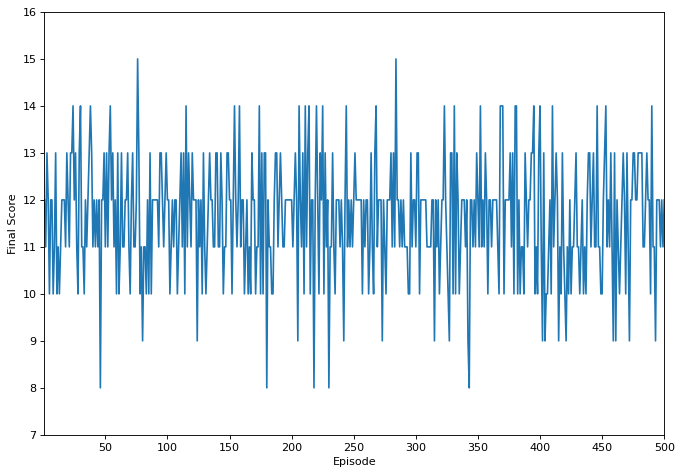

In [169]:
aux_plots.plot_scores(scores)

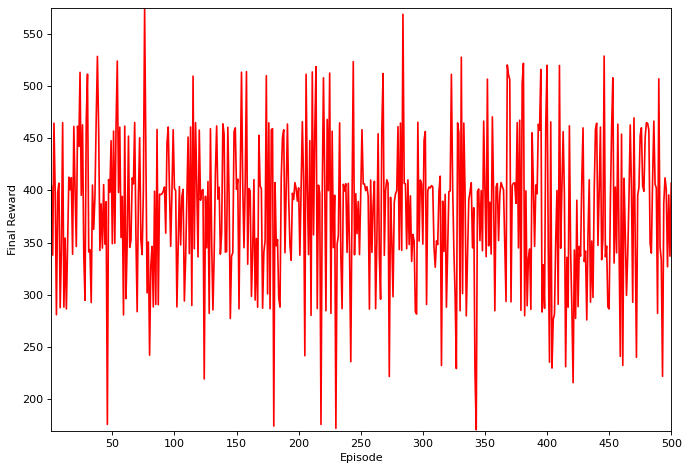

In [170]:
aux_plots.plot_rewards(total_rewards)

In [186]:
%%time

n_runs = 1000

for i in tqdm(range(n_runs)):
    render = i % 201 == 200
    score, total_reward = MonteCarloAprox(RAM_mask=RAM_mask, render=render)
    scores.append(score)
    total_rewards.append(total_reward)
    print_result(i, scores, total_reward, score)

  0%|          | 1/1000 [00:03<58:57,  3.54s/it]

Run [   0] - Total reward:  245.10 Mean scores: 9.00 Means Scores[:-10]:  9.00 Score:  9 


  1%|          | 11/1000 [00:36<52:20,  3.18s/it]

Run [  10] - Total reward:  226.60 Mean scores: 10.82 Means Scores[:-10]: 11.00 Score:  9 


  2%|▏         | 21/1000 [01:06<49:57,  3.06s/it]

Run [  20] - Total reward:  228.90 Mean scores: 10.67 Means Scores[:-10]: 10.50 Score:  9 


  3%|▎         | 31/1000 [01:37<48:25,  3.00s/it]

Run [  30] - Total reward:  415.90 Mean scores: 11.19 Means Scores[:-10]: 12.30 Score: 12 


  4%|▍         | 41/1000 [02:05<45:19,  2.84s/it]

Run [  40] - Total reward:  283.80 Mean scores: 11.22 Means Scores[:-10]: 11.30 Score: 10 


  5%|▌         | 51/1000 [02:33<43:51,  2.77s/it]

Run [  50] - Total reward:  292.50 Mean scores: 11.25 Means Scores[:-10]: 11.40 Score: 10 


  6%|▌         | 61/1000 [03:01<43:03,  2.75s/it]

Run [  60] - Total reward:  393.90 Mean scores: 11.31 Means Scores[:-10]: 11.60 Score: 12 


  7%|▋         | 71/1000 [03:28<42:20,  2.73s/it]

Run [  70] - Total reward:  406.40 Mean scores: 11.37 Means Scores[:-10]: 11.70 Score: 12 


  8%|▊         | 81/1000 [03:55<40:56,  2.67s/it]

Run [  80] - Total reward:  352.00 Mean scores: 11.38 Means Scores[:-10]: 11.50 Score: 11 


  9%|▉         | 91/1000 [04:22<40:33,  2.68s/it]

Run [  90] - Total reward:  358.40 Mean scores: 11.35 Means Scores[:-10]: 11.10 Score: 11 


 10%|█         | 101/1000 [04:48<39:32,  2.64s/it]

Run [ 100] - Total reward:  346.90 Mean scores: 11.34 Means Scores[:-10]: 11.20 Score: 11 


 11%|█         | 111/1000 [05:15<39:54,  2.69s/it]

Run [ 110] - Total reward:  339.00 Mean scores: 11.30 Means Scores[:-10]: 10.90 Score: 11 


 12%|█▏        | 121/1000 [05:42<38:33,  2.63s/it]

Run [ 120] - Total reward:  296.80 Mean scores: 11.37 Means Scores[:-10]: 12.20 Score: 10 


 13%|█▎        | 131/1000 [06:08<37:32,  2.59s/it]

Run [ 130] - Total reward:  394.50 Mean scores: 11.40 Means Scores[:-10]: 11.80 Score: 12 


 14%|█▍        | 141/1000 [06:34<37:41,  2.63s/it]

Run [ 140] - Total reward:  281.50 Mean scores: 11.44 Means Scores[:-10]: 11.90 Score: 10 


 15%|█▌        | 151/1000 [07:00<36:33,  2.58s/it]

Run [ 150] - Total reward:  406.00 Mean scores: 11.48 Means Scores[:-10]: 12.10 Score: 12 


 16%|█▌        | 161/1000 [07:26<36:16,  2.59s/it]

Run [ 160] - Total reward:  342.60 Mean scores: 11.53 Means Scores[:-10]: 12.20 Score: 11 


 17%|█▋        | 171/1000 [07:52<35:37,  2.58s/it]

Run [ 170] - Total reward:  458.00 Mean scores: 11.54 Means Scores[:-10]: 11.80 Score: 13 


 18%|█▊        | 181/1000 [08:18<35:19,  2.59s/it]

Run [ 180] - Total reward:  412.30 Mean scores: 11.55 Means Scores[:-10]: 11.60 Score: 12 


 19%|█▉        | 191/1000 [08:43<35:00,  2.60s/it]

Run [ 190] - Total reward:  343.20 Mean scores: 11.54 Means Scores[:-10]: 11.40 Score: 11 


 20%|██        | 201/1000 [09:28<1:50:55,  8.33s/it]

Run [ 200] - Total reward:  294.00 Mean scores: 11.58 Means Scores[:-10]: 12.30 Score: 10 


 21%|██        | 211/1000 [09:54<35:41,  2.71s/it]  

Run [ 210] - Total reward:  288.30 Mean scores: 11.53 Means Scores[:-10]: 10.60 Score: 10 


 22%|██▏       | 221/1000 [10:19<33:16,  2.56s/it]

Run [ 220] - Total reward:  345.80 Mean scores: 11.51 Means Scores[:-10]: 11.00 Score: 11 


 23%|██▎       | 231/1000 [10:45<32:44,  2.55s/it]

Run [ 230] - Total reward:  410.20 Mean scores: 11.49 Means Scores[:-10]: 11.20 Score: 12 


 24%|██▍       | 241/1000 [11:11<33:44,  2.67s/it]

Run [ 240] - Total reward:  311.10 Mean scores: 11.48 Means Scores[:-10]: 11.10 Score: 10 


 25%|██▌       | 251/1000 [11:37<31:52,  2.55s/it]

Run [ 250] - Total reward:  459.00 Mean scores: 11.51 Means Scores[:-10]: 12.30 Score: 13 


 26%|██▌       | 261/1000 [12:02<31:11,  2.53s/it]

Run [ 260] - Total reward:  337.60 Mean scores: 11.51 Means Scores[:-10]: 11.50 Score: 11 


 27%|██▋       | 271/1000 [12:28<30:48,  2.54s/it]

Run [ 270] - Total reward:  474.00 Mean scores: 11.52 Means Scores[:-10]: 11.90 Score: 13 


 28%|██▊       | 281/1000 [12:53<30:34,  2.55s/it]

Run [ 280] - Total reward:  460.60 Mean scores: 11.54 Means Scores[:-10]: 12.00 Score: 13 


 29%|██▉       | 291/1000 [13:19<30:13,  2.56s/it]

Run [ 290] - Total reward:  465.50 Mean scores: 11.55 Means Scores[:-10]: 11.70 Score: 13 


 30%|███       | 301/1000 [13:44<29:39,  2.55s/it]

Run [ 300] - Total reward:  338.40 Mean scores: 11.53 Means Scores[:-10]: 11.20 Score: 11 


 31%|███       | 311/1000 [14:09<29:04,  2.53s/it]

Run [ 310] - Total reward:  335.70 Mean scores: 11.51 Means Scores[:-10]: 10.80 Score: 11 


 32%|███▏      | 321/1000 [14:35<28:37,  2.53s/it]

Run [ 320] - Total reward:  395.70 Mean scores: 11.53 Means Scores[:-10]: 12.20 Score: 12 


 33%|███▎      | 331/1000 [15:00<28:26,  2.55s/it]

Run [ 330] - Total reward:  459.40 Mean scores: 11.52 Means Scores[:-10]: 11.10 Score: 13 


 34%|███▍      | 341/1000 [15:26<27:49,  2.53s/it]

Run [ 340] - Total reward:  285.90 Mean scores: 11.52 Means Scores[:-10]: 11.50 Score: 10 


 35%|███▌      | 351/1000 [15:51<27:19,  2.53s/it]

Run [ 350] - Total reward:  414.60 Mean scores: 11.51 Means Scores[:-10]: 11.10 Score: 12 


 36%|███▌      | 361/1000 [16:16<27:01,  2.54s/it]

Run [ 360] - Total reward:  280.50 Mean scores: 11.50 Means Scores[:-10]: 11.10 Score: 10 


 37%|███▋      | 371/1000 [16:41<26:24,  2.52s/it]

Run [ 370] - Total reward:  395.90 Mean scores: 11.49 Means Scores[:-10]: 11.10 Score: 12 


 38%|███▊      | 381/1000 [17:07<25:55,  2.51s/it]

Run [ 380] - Total reward:  331.80 Mean scores: 11.49 Means Scores[:-10]: 11.60 Score: 11 


 39%|███▉      | 391/1000 [17:32<25:31,  2.51s/it]

Run [ 390] - Total reward:  336.20 Mean scores: 11.51 Means Scores[:-10]: 12.20 Score: 11 


 40%|████      | 401/1000 [17:57<25:04,  2.51s/it]

Run [ 400] - Total reward:  344.10 Mean scores: 11.52 Means Scores[:-10]: 12.00 Score: 11 


 41%|████      | 411/1000 [18:42<26:55,  2.74s/it]  

Run [ 410] - Total reward:  347.10 Mean scores: 11.50 Means Scores[:-10]: 10.90 Score: 11 


 42%|████▏     | 421/1000 [19:07<24:23,  2.53s/it]

Run [ 420] - Total reward:  409.10 Mean scores: 11.50 Means Scores[:-10]: 11.20 Score: 12 


 43%|████▎     | 431/1000 [19:32<23:50,  2.51s/it]

Run [ 430] - Total reward:  350.40 Mean scores: 11.49 Means Scores[:-10]: 11.20 Score: 11 


 44%|████▍     | 441/1000 [19:57<23:28,  2.52s/it]

Run [ 440] - Total reward:  170.40 Mean scores: 11.48 Means Scores[:-10]: 11.20 Score:  8 


 45%|████▌     | 451/1000 [20:23<23:05,  2.52s/it]

Run [ 450] - Total reward:  401.40 Mean scores: 11.49 Means Scores[:-10]: 11.70 Score: 12 


 46%|████▌     | 461/1000 [20:48<22:32,  2.51s/it]

Run [ 460] - Total reward:  411.00 Mean scores: 11.49 Means Scores[:-10]: 11.40 Score: 12 


 47%|████▋     | 471/1000 [21:13<22:46,  2.58s/it]

Run [ 470] - Total reward:  439.70 Mean scores: 11.50 Means Scores[:-10]: 12.10 Score: 13 


 48%|████▊     | 481/1000 [21:38<21:44,  2.51s/it]

Run [ 480] - Total reward:  346.30 Mean scores: 11.51 Means Scores[:-10]: 11.90 Score: 11 


 49%|████▉     | 491/1000 [22:03<21:17,  2.51s/it]

Run [ 490] - Total reward:  400.00 Mean scores: 11.50 Means Scores[:-10]: 11.10 Score: 12 


 50%|█████     | 501/1000 [22:28<20:47,  2.50s/it]

Run [ 500] - Total reward:  462.10 Mean scores: 11.51 Means Scores[:-10]: 12.00 Score: 13 


 51%|█████     | 511/1000 [22:54<20:26,  2.51s/it]

Run [ 510] - Total reward:  324.60 Mean scores: 11.53 Means Scores[:-10]: 12.50 Score: 11 


 52%|█████▏    | 521/1000 [23:19<20:18,  2.54s/it]

Run [ 520] - Total reward:  399.00 Mean scores: 11.52 Means Scores[:-10]: 11.20 Score: 12 


 53%|█████▎    | 531/1000 [23:44<19:34,  2.51s/it]

Run [ 530] - Total reward:  392.40 Mean scores: 11.52 Means Scores[:-10]: 11.40 Score: 12 


 54%|█████▍    | 541/1000 [24:09<19:07,  2.50s/it]

Run [ 540] - Total reward:  399.80 Mean scores: 11.52 Means Scores[:-10]: 11.80 Score: 12 


 55%|█████▌    | 551/1000 [24:34<18:46,  2.51s/it]

Run [ 550] - Total reward:  344.20 Mean scores: 11.52 Means Scores[:-10]: 11.50 Score: 11 


 56%|█████▌    | 561/1000 [24:59<18:15,  2.50s/it]

Run [ 560] - Total reward:  345.50 Mean scores: 11.52 Means Scores[:-10]: 11.20 Score: 11 


 57%|█████▋    | 571/1000 [25:25<18:06,  2.53s/it]

Run [ 570] - Total reward:  453.60 Mean scores: 11.52 Means Scores[:-10]: 11.70 Score: 13 


 58%|█████▊    | 581/1000 [25:50<17:28,  2.50s/it]

Run [ 580] - Total reward:  349.40 Mean scores: 11.53 Means Scores[:-10]: 11.90 Score: 11 


 59%|█████▉    | 591/1000 [26:15<17:16,  2.53s/it]

Run [ 590] - Total reward:  227.00 Mean scores: 11.54 Means Scores[:-10]: 12.00 Score:  9 


 60%|██████    | 601/1000 [26:40<16:39,  2.51s/it]

Run [ 600] - Total reward:  459.60 Mean scores: 11.54 Means Scores[:-10]: 12.00 Score: 13 


 61%|██████    | 611/1000 [27:25<18:22,  2.84s/it]

Run [ 610] - Total reward:  353.40 Mean scores: 11.54 Means Scores[:-10]: 11.30 Score: 11 


 62%|██████▏   | 621/1000 [27:50<15:49,  2.50s/it]

Run [ 620] - Total reward:  232.80 Mean scores: 11.54 Means Scores[:-10]: 11.70 Score:  9 


 63%|██████▎   | 631/1000 [28:15<15:21,  2.50s/it]

Run [ 630] - Total reward:  241.40 Mean scores: 11.54 Means Scores[:-10]: 11.50 Score:  9 


 64%|██████▍   | 641/1000 [28:40<14:59,  2.50s/it]

Run [ 640] - Total reward:  397.70 Mean scores: 11.54 Means Scores[:-10]: 11.60 Score: 12 


 65%|██████▌   | 651/1000 [29:05<14:32,  2.50s/it]

Run [ 650] - Total reward:  400.40 Mean scores: 11.54 Means Scores[:-10]: 11.20 Score: 12 


 66%|██████▌   | 661/1000 [29:30<14:08,  2.50s/it]

Run [ 660] - Total reward:  352.90 Mean scores: 11.54 Means Scores[:-10]: 11.70 Score: 11 


 67%|██████▋   | 671/1000 [29:55<13:43,  2.50s/it]

Run [ 670] - Total reward:  504.40 Mean scores: 11.54 Means Scores[:-10]: 11.50 Score: 14 


 68%|██████▊   | 681/1000 [30:20<13:21,  2.51s/it]

Run [ 680] - Total reward:  390.60 Mean scores: 11.55 Means Scores[:-10]: 12.10 Score: 12 


 69%|██████▉   | 691/1000 [30:46<12:57,  2.51s/it]

Run [ 690] - Total reward:  517.50 Mean scores: 11.56 Means Scores[:-10]: 12.20 Score: 14 


 70%|███████   | 701/1000 [31:11<12:52,  2.58s/it]

Run [ 700] - Total reward:  405.90 Mean scores: 11.55 Means Scores[:-10]: 11.40 Score: 12 


 71%|███████   | 711/1000 [31:36<12:06,  2.51s/it]

Run [ 710] - Total reward:  223.70 Mean scores: 11.55 Means Scores[:-10]: 11.50 Score:  9 


 72%|███████▏  | 721/1000 [32:01<11:36,  2.50s/it]

Run [ 720] - Total reward:  292.90 Mean scores: 11.56 Means Scores[:-10]: 11.90 Score: 10 


 73%|███████▎  | 731/1000 [32:26<11:10,  2.49s/it]

Run [ 730] - Total reward:  351.00 Mean scores: 11.56 Means Scores[:-10]: 11.70 Score: 11 


 74%|███████▍  | 741/1000 [32:51<10:45,  2.49s/it]

Run [ 740] - Total reward:  471.90 Mean scores: 11.57 Means Scores[:-10]: 11.90 Score: 13 


 75%|███████▌  | 751/1000 [33:16<10:27,  2.52s/it]

Run [ 750] - Total reward:  463.60 Mean scores: 11.56 Means Scores[:-10]: 11.20 Score: 13 


 76%|███████▌  | 761/1000 [33:41<09:56,  2.49s/it]

Run [ 760] - Total reward:  506.70 Mean scores: 11.57 Means Scores[:-10]: 12.00 Score: 14 


 77%|███████▋  | 771/1000 [34:06<09:32,  2.50s/it]

Run [ 770] - Total reward:  340.40 Mean scores: 11.56 Means Scores[:-10]: 10.70 Score: 11 


 78%|███████▊  | 781/1000 [34:32<09:15,  2.53s/it]

Run [ 780] - Total reward:  288.80 Mean scores: 11.55 Means Scores[:-10]: 11.50 Score: 10 


 79%|███████▉  | 791/1000 [34:57<08:44,  2.51s/it]

Run [ 790] - Total reward:  297.90 Mean scores: 11.57 Means Scores[:-10]: 12.40 Score: 10 


 80%|████████  | 801/1000 [35:22<08:23,  2.53s/it]

Run [ 800] - Total reward:  279.70 Mean scores: 11.56 Means Scores[:-10]: 11.10 Score: 10 


 81%|████████  | 811/1000 [36:07<09:22,  2.98s/it]

Run [ 810] - Total reward:  183.20 Mean scores: 11.56 Means Scores[:-10]: 11.50 Score:  8 


 82%|████████▏ | 821/1000 [36:32<07:27,  2.50s/it]

Run [ 820] - Total reward:  338.30 Mean scores: 11.56 Means Scores[:-10]: 11.60 Score: 11 


 83%|████████▎ | 831/1000 [36:57<07:01,  2.49s/it]

Run [ 830] - Total reward:  400.50 Mean scores: 11.56 Means Scores[:-10]: 11.70 Score: 12 


 84%|████████▍ | 841/1000 [37:22<06:37,  2.50s/it]

Run [ 840] - Total reward:  344.50 Mean scores: 11.57 Means Scores[:-10]: 12.00 Score: 11 


 85%|████████▌ | 851/1000 [37:47<06:10,  2.48s/it]

Run [ 850] - Total reward:  414.20 Mean scores: 11.57 Means Scores[:-10]: 11.50 Score: 12 


 86%|████████▌ | 861/1000 [38:12<05:44,  2.48s/it]

Run [ 860] - Total reward:  470.30 Mean scores: 11.56 Means Scores[:-10]: 11.50 Score: 13 


 87%|████████▋ | 871/1000 [38:36<05:20,  2.48s/it]

Run [ 870] - Total reward:  344.30 Mean scores: 11.57 Means Scores[:-10]: 12.20 Score: 11 


 88%|████████▊ | 881/1000 [39:01<04:55,  2.48s/it]

Run [ 880] - Total reward:  423.90 Mean scores: 11.57 Means Scores[:-10]: 11.70 Score: 12 


 89%|████████▉ | 891/1000 [39:27<04:32,  2.50s/it]

Run [ 890] - Total reward:  455.60 Mean scores: 11.57 Means Scores[:-10]: 11.20 Score: 13 


 90%|█████████ | 901/1000 [39:52<04:06,  2.49s/it]

Run [ 900] - Total reward:  334.70 Mean scores: 11.57 Means Scores[:-10]: 11.70 Score: 11 


 91%|█████████ | 911/1000 [40:16<03:40,  2.48s/it]

Run [ 910] - Total reward:  515.10 Mean scores: 11.57 Means Scores[:-10]: 11.80 Score: 14 


 92%|█████████▏| 921/1000 [40:41<03:16,  2.49s/it]

Run [ 920] - Total reward:  508.50 Mean scores: 11.58 Means Scores[:-10]: 12.10 Score: 14 


 93%|█████████▎| 931/1000 [41:06<02:51,  2.49s/it]

Run [ 930] - Total reward:  339.50 Mean scores: 11.57 Means Scores[:-10]: 11.10 Score: 11 


 94%|█████████▍| 941/1000 [41:31<02:26,  2.48s/it]

Run [ 940] - Total reward:  398.10 Mean scores: 11.58 Means Scores[:-10]: 11.80 Score: 12 


 95%|█████████▌| 951/1000 [41:56<02:02,  2.49s/it]

Run [ 950] - Total reward:  449.40 Mean scores: 11.57 Means Scores[:-10]: 11.20 Score: 13 


 96%|█████████▌| 961/1000 [42:21<01:36,  2.49s/it]

Run [ 960] - Total reward:  407.10 Mean scores: 11.57 Means Scores[:-10]: 11.50 Score: 12 


 97%|█████████▋| 971/1000 [42:46<01:11,  2.48s/it]

Run [ 970] - Total reward:  460.50 Mean scores: 11.57 Means Scores[:-10]: 11.70 Score: 13 


 98%|█████████▊| 981/1000 [43:12<00:49,  2.59s/it]

Run [ 980] - Total reward:  342.70 Mean scores: 11.57 Means Scores[:-10]: 11.50 Score: 11 


 99%|█████████▉| 991/1000 [43:37<00:22,  2.50s/it]

Run [ 990] - Total reward:  410.70 Mean scores: 11.57 Means Scores[:-10]: 11.80 Score: 12 


100%|██████████| 1000/1000 [44:00<00:00,  2.64s/it]

CPU times: user 43min 1s, sys: 1.19 s, total: 43min 2s
Wall time: 44min


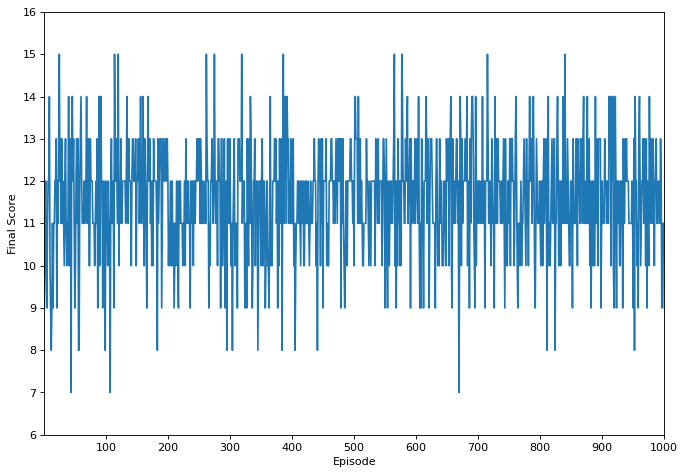

In [187]:
aux_plots.plot_scores(scores)